In [30]:
import pandas as pd
import numpy as np
from collections import Counter


In [31]:
from google.colab import drive
!cd ~
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA
'family msa_gen_vector_iadf+.ipynb'
 msa_gen_vector_iadf+.ipynb
 msa_gen_vector_iadf.ipynb
 msa.ipynb
 RE_df.gsheet
 RE_df.tsv
 res_of_iadf_pca.csv
 res_of_iadf_plus_pca
 res_of_iadf_plus_pca.csv
 res_of_pca_tfidf.csv
'results summerizetion.ipynb'
'submission of PCA msa_gen_vector_iadf+.ipynb'
'submission of PCA msa_gen_vector_iadf.ipynb'
'submission of PCA msa_gen_vector_tf_idf.ipynb'
'submission of TSNE msa_gen_vector_iadf+.ipynb'


In [32]:
df_data = pd.read_csv('RE_df.tsv', sep='\t')
df_data['family_lable'] =  df_data['msa'].str.split('_').str[0]
family_lables = df_data['family_lable'].to_list()
dataset = df_data['seq'].tolist()
true_lables = df_data['is_RE'].tolist()

In [33]:
def kmers_extraction(msa, kmer_size=3):
  kmers=[]
  for i,_ in enumerate(msa):
    if i < len(msa)-kmer_size+1:
      kmers.append(msa[i:i+kmer_size])
  return kmers


In [34]:
def preprocess(dataset):
 return [kmers_extraction(i) for i in dataset ]
processed_text = preprocess(dataset)

In [35]:

DF = {}
for i in range(len(processed_text)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [36]:
total_vocab = [x for x in DF]
# total_vocab

In [37]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return len(c)

In [38]:
import math 

 # mean df for ne algo

tf_idf = {}

N = len(dataset)


def gen_vector_iadf(tokens):
  doc = 0
  sum_df = 0
  for token in np.unique(tokens):
    df = doc_freq(token)
    sum_df +=df
    doc += 1
    mean_df = sum_df /  len(np.unique(tokens))

  Q = np.zeros((len(total_vocab)))

  counter = Counter(tokens)
  words_count = len(tokens)

  query_weights = {}
  
  doc = 0
  n_ = np.unique(tokens)
  for token in n_:
      
      tf = counter[token]/words_count
      df = doc_freq(token)
      if abs(df- mean_df) == 0:
        df =+ df + 0.00001
      df_ = math.log((abs(df- mean_df))/len(n_)) # for new algo. - mean_df devide n
      if (abs(df_)+1) <= 0:
        print("ghjmk,l")
      idf = math.log(N+1/(abs(df_)+1))

      try:
          ind = total_vocab.index(token)
          Q[ind] = tf*idf
      except:
          pass
  return Q


# the run

# PCA

In [39]:
vecs = [ gen_vector_iadf(i)  for i in preprocess(dataset)]
# vecs

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns
from numpy import reshape

def pca(vecs):
  x = np.array(vecs)
  # x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])
  pca = PCA(n_components=2)
  z = pca.fit_transform(x)
  df = pd.DataFrame()

  df["y"] = family_lables
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df['color'] = true_lables
  # df = df.query('y=="Salmonella"')
  return df, z
  

In [41]:
df , z = pca(vecs)


# families clusters


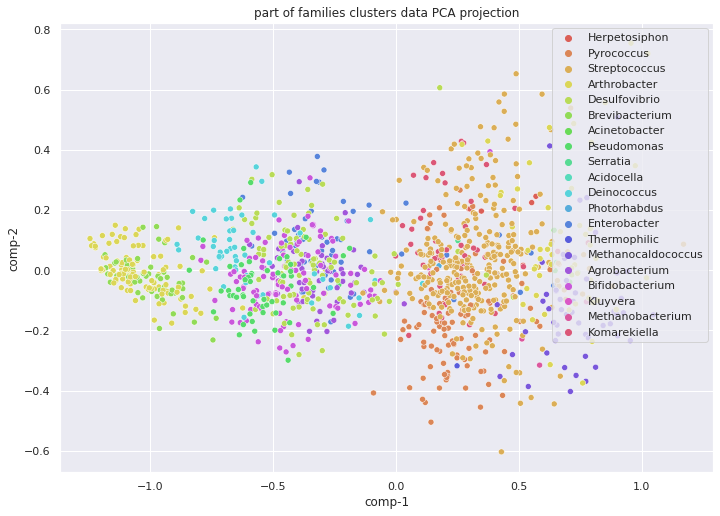

In [42]:
## families clusters
part_of_families = list(set(family_lables))[30:50]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

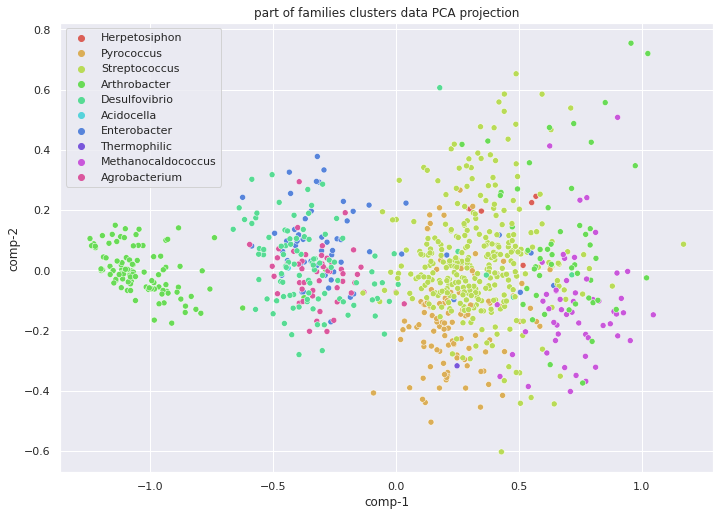

In [43]:
## families clusters
part_of_families = list(set(family_lables))[30:40]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [44]:
# tsne visualizetion by family

<ipython-input-45-93fa05f27660>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


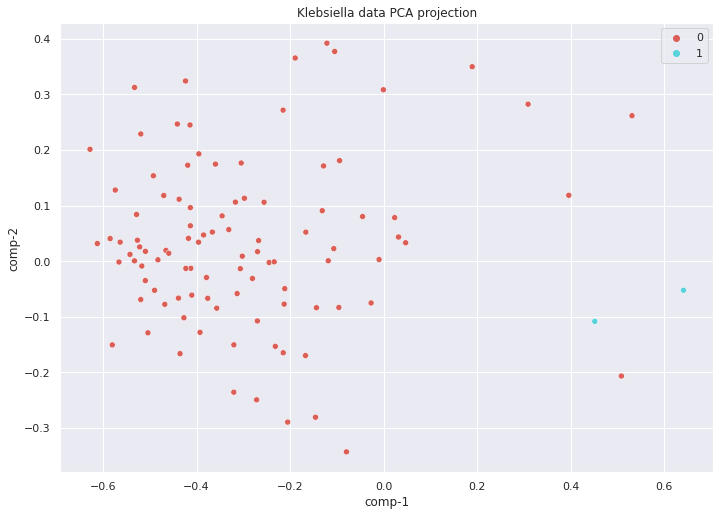

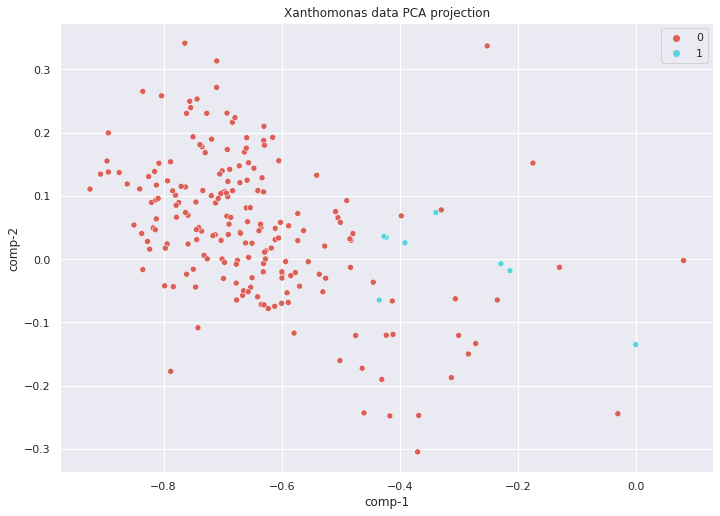

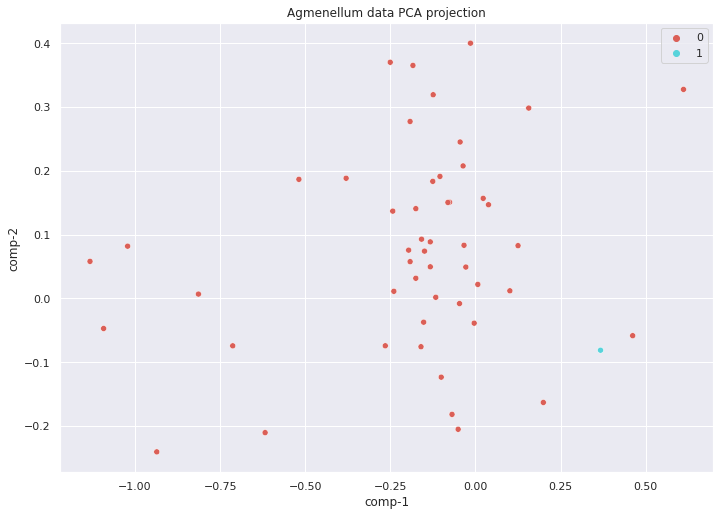

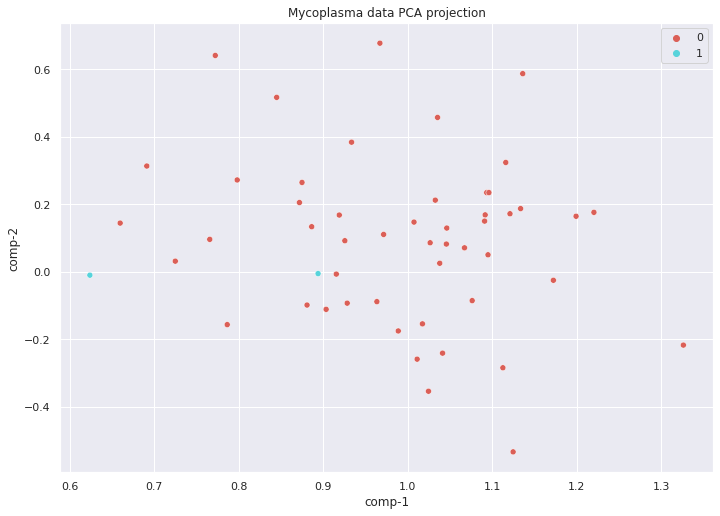

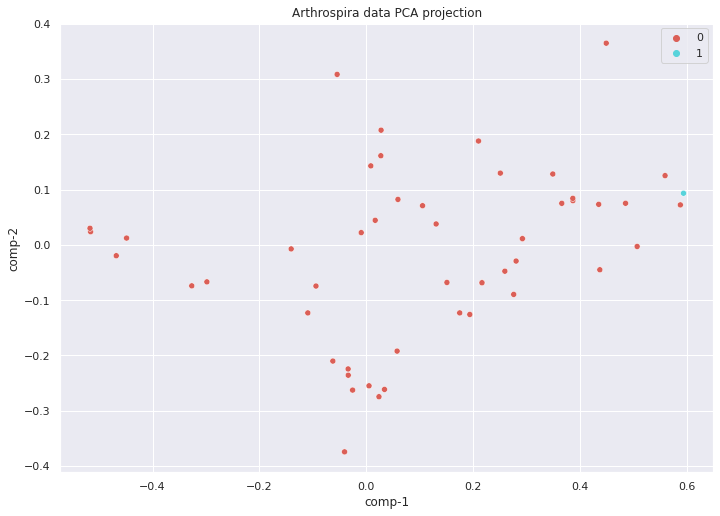

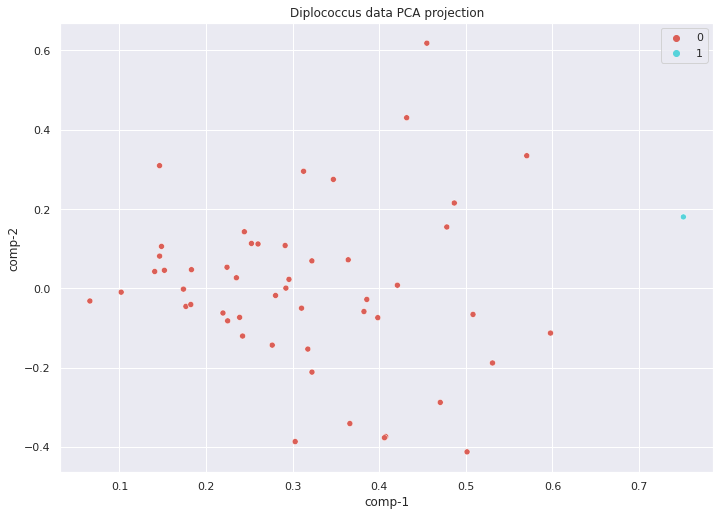

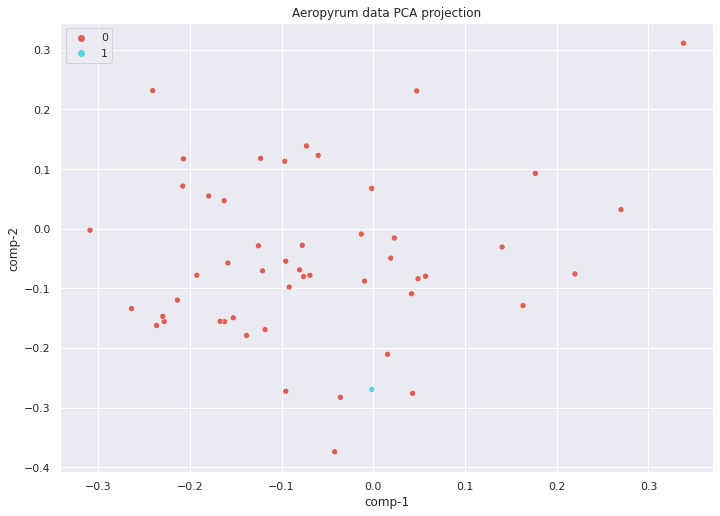

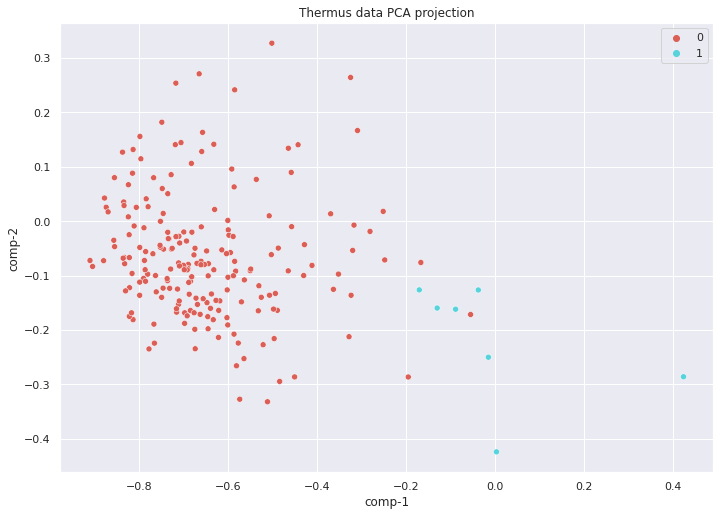

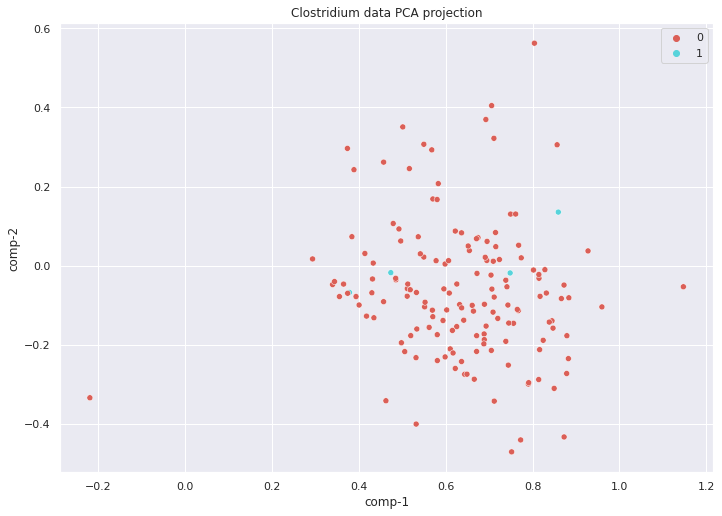

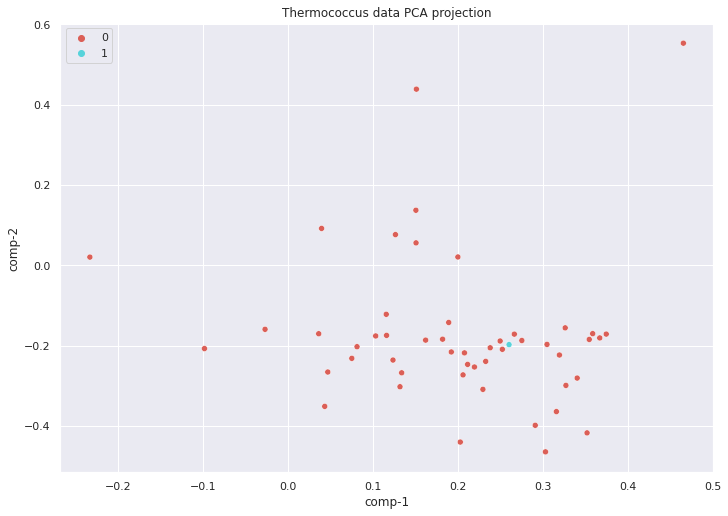

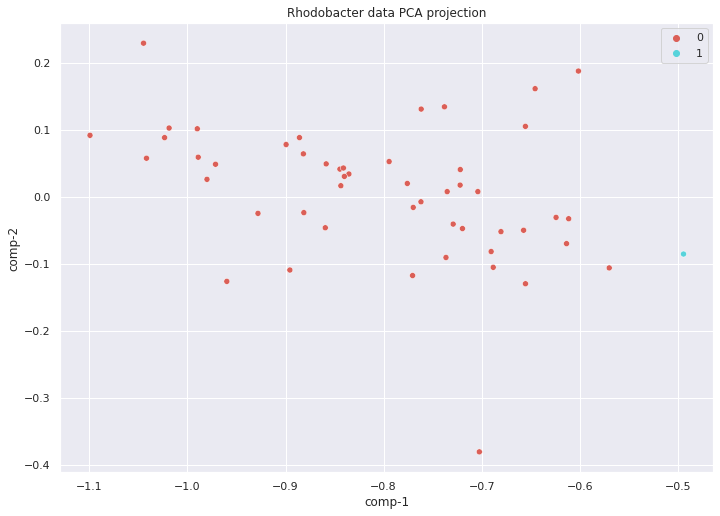

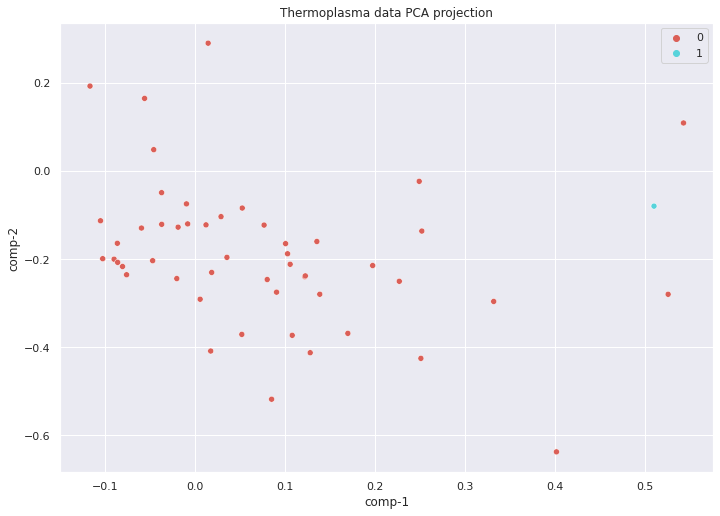

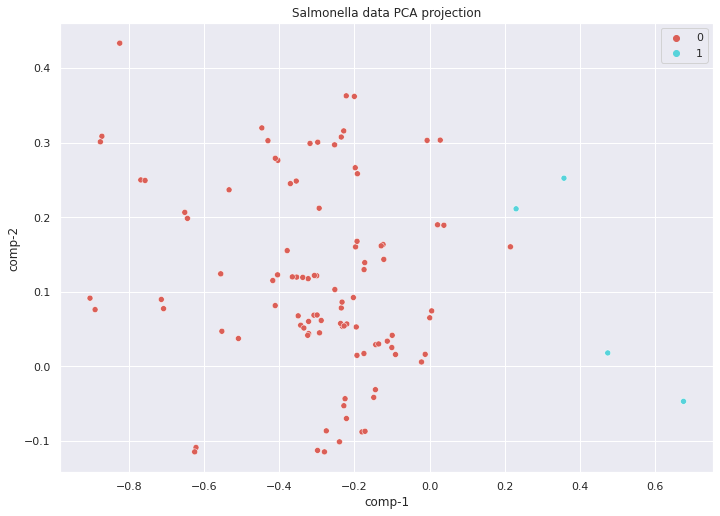

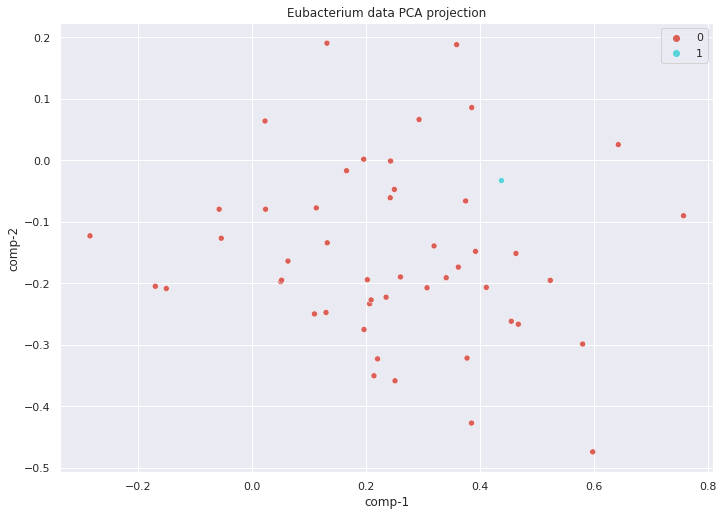

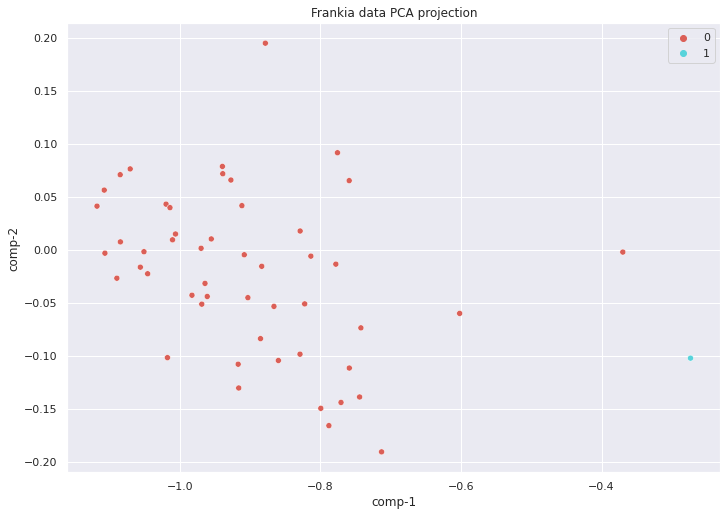

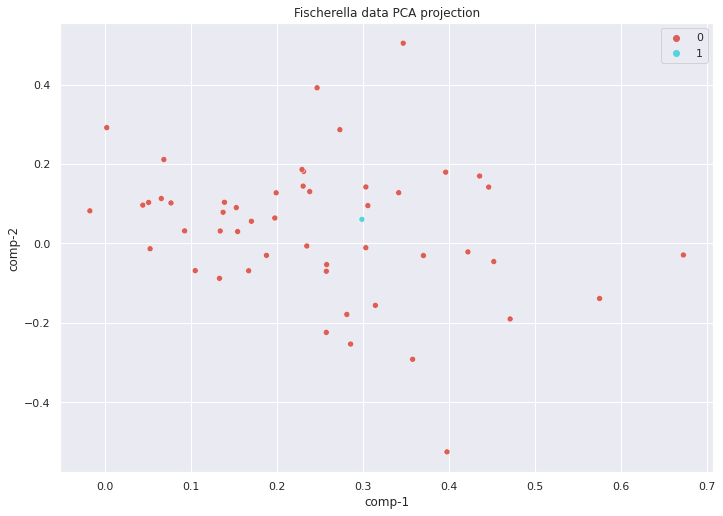

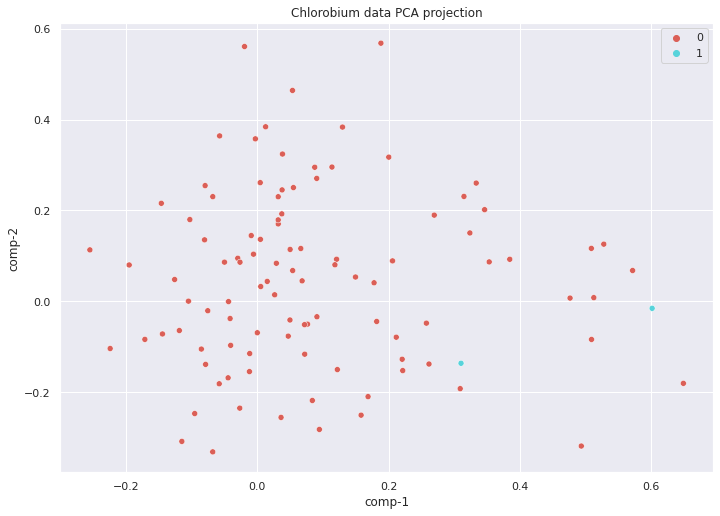

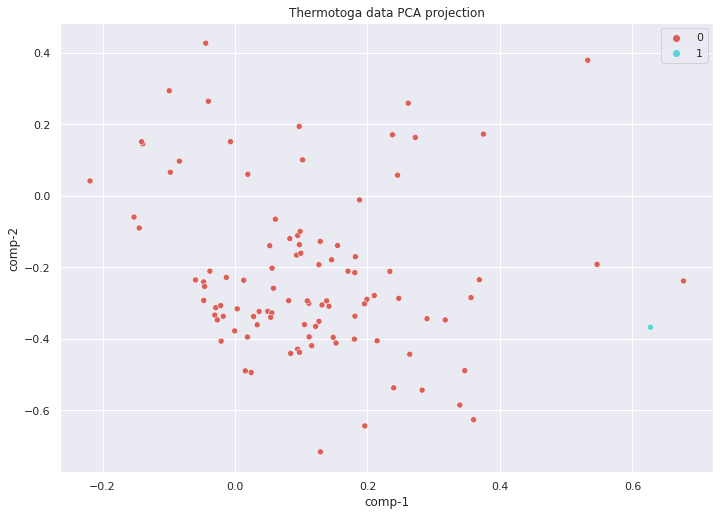

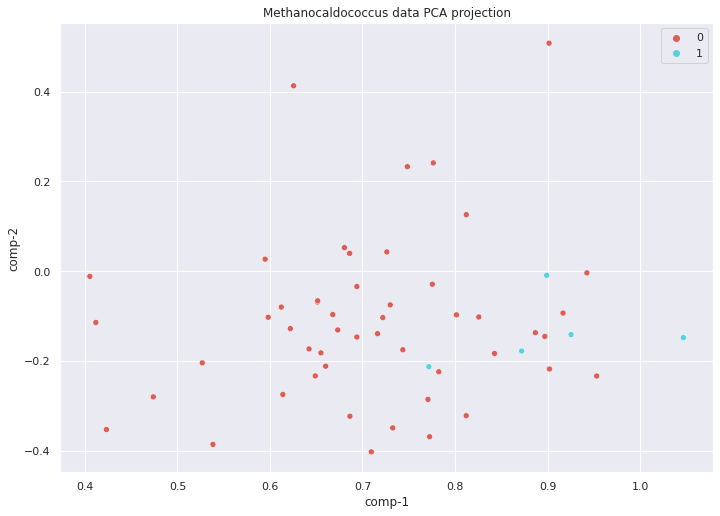

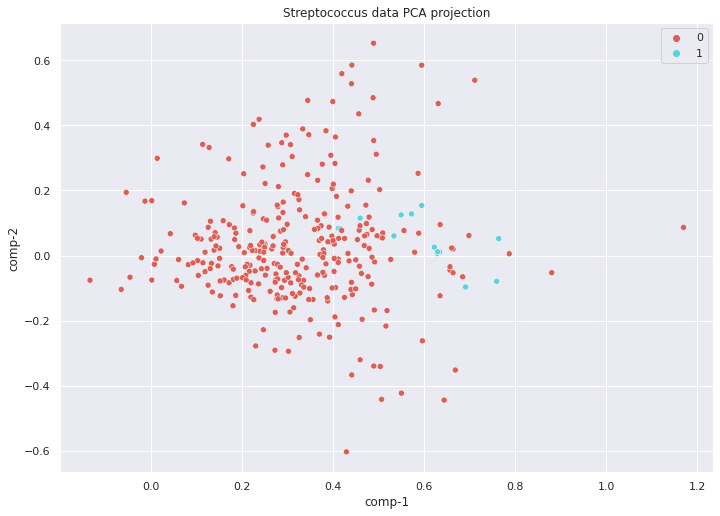

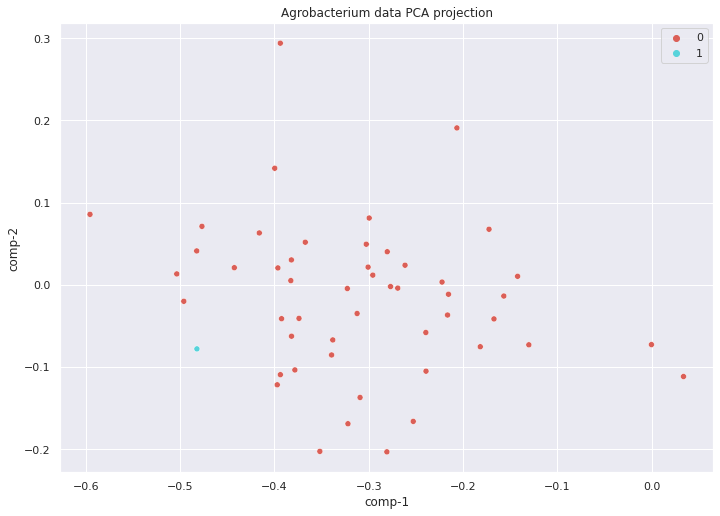

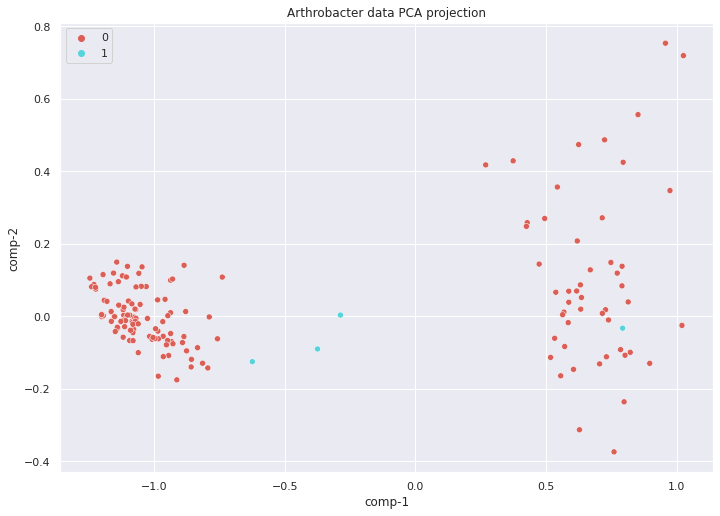

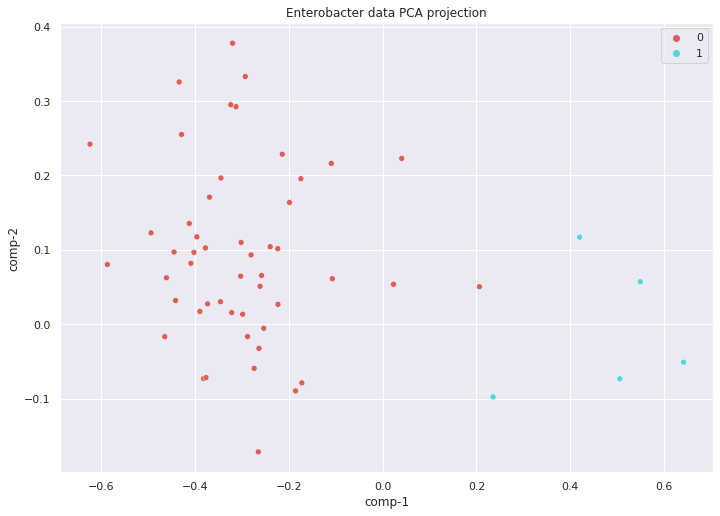

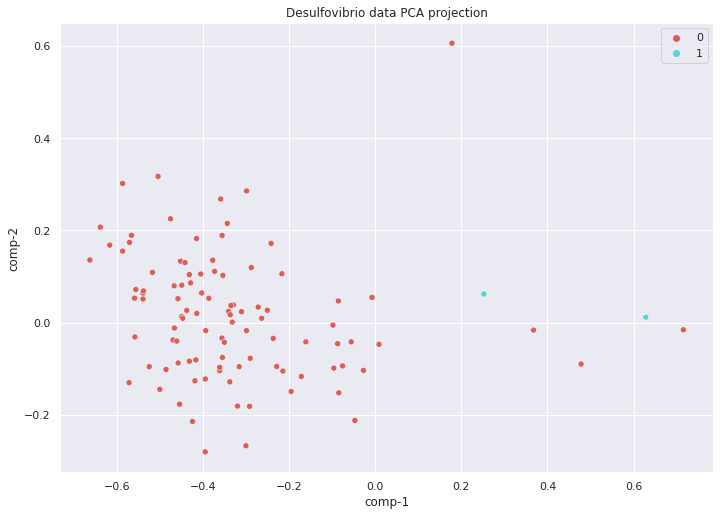

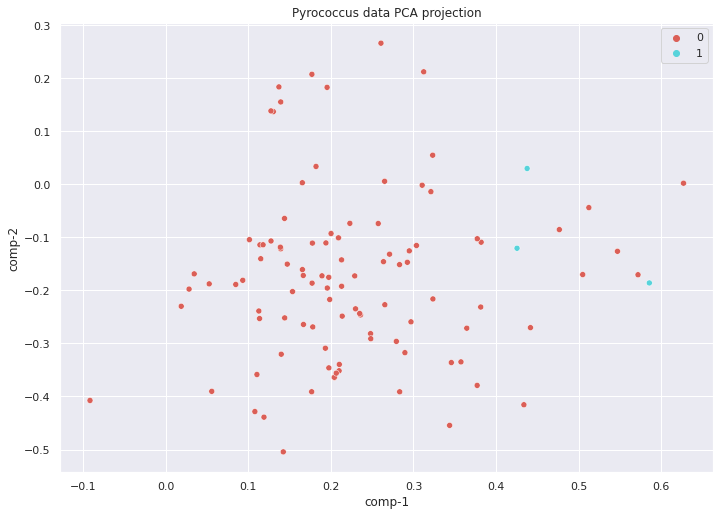

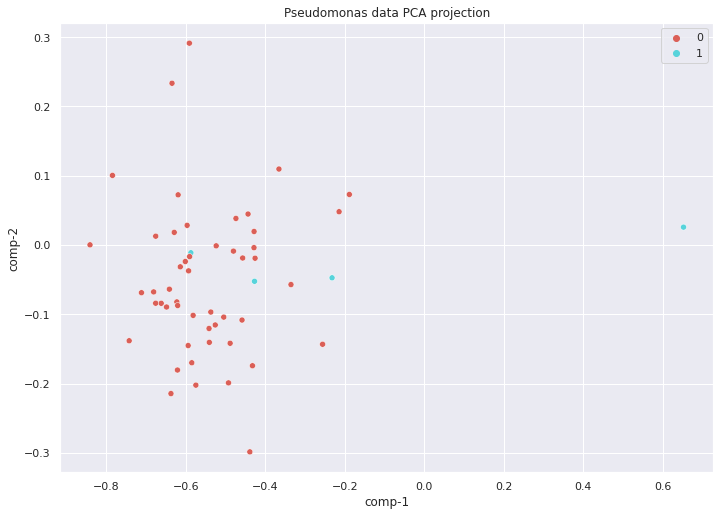

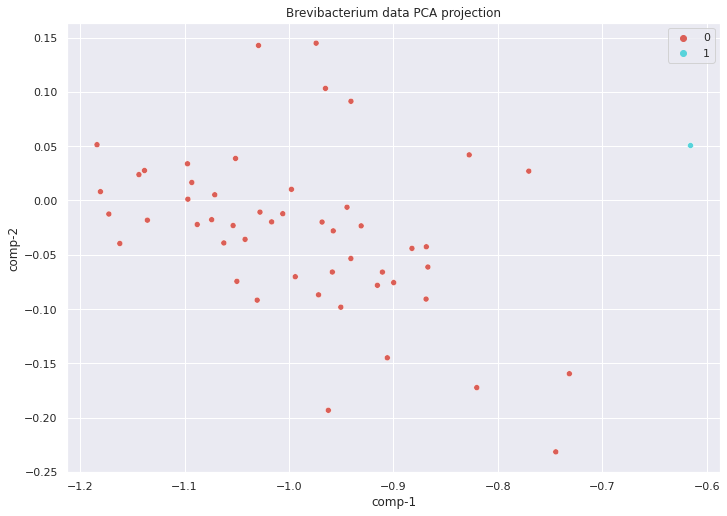

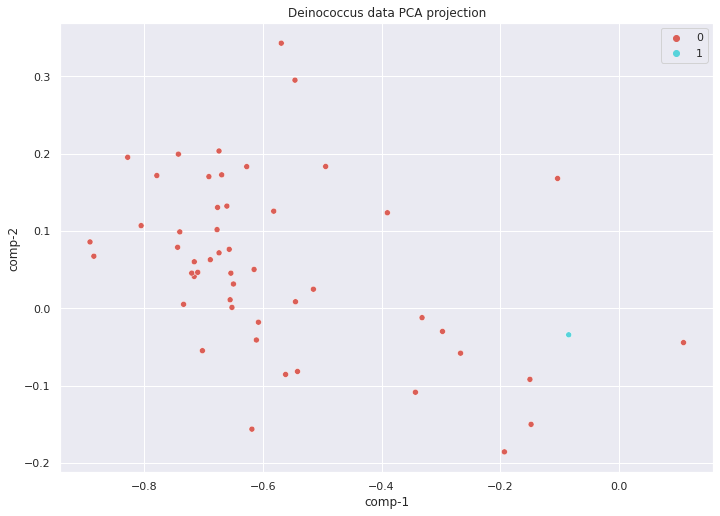

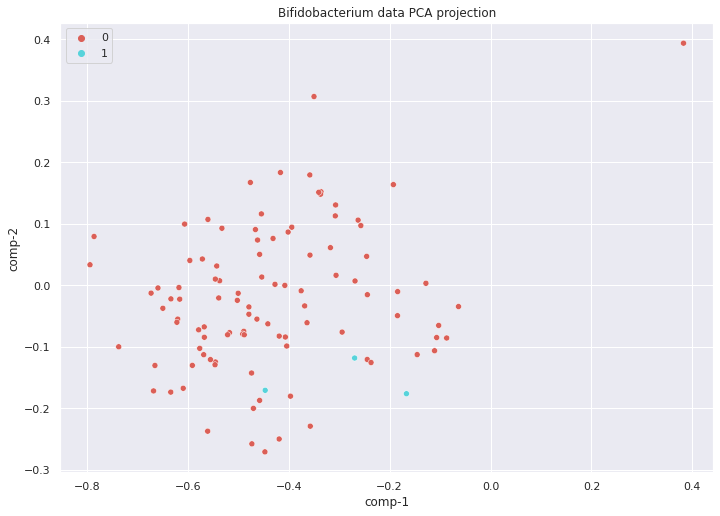

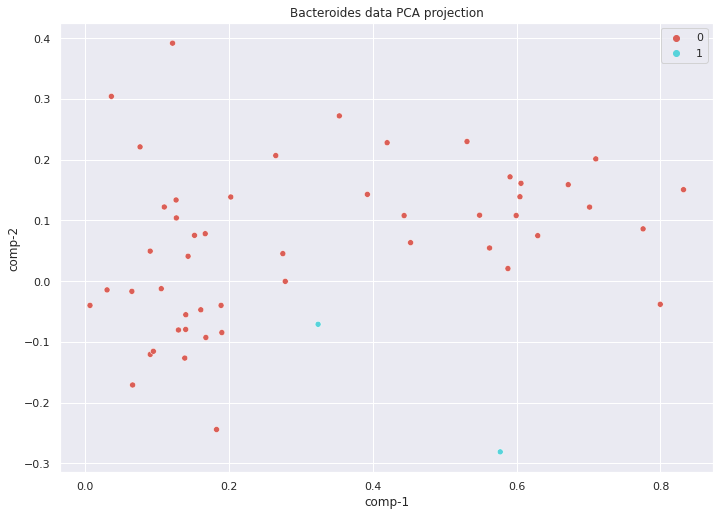

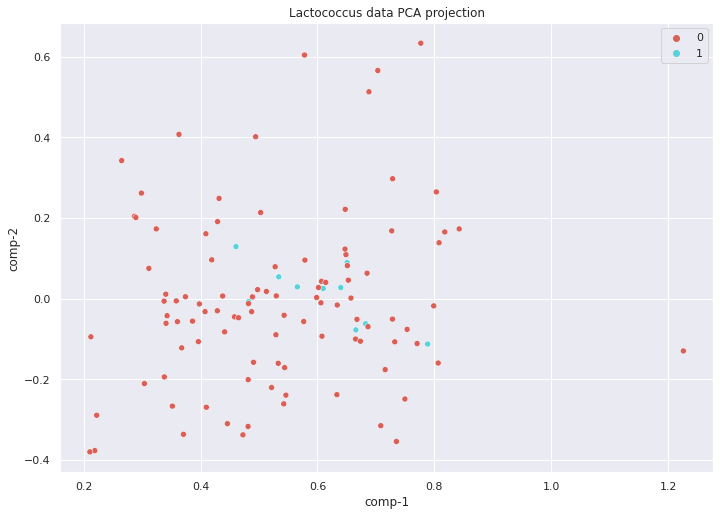

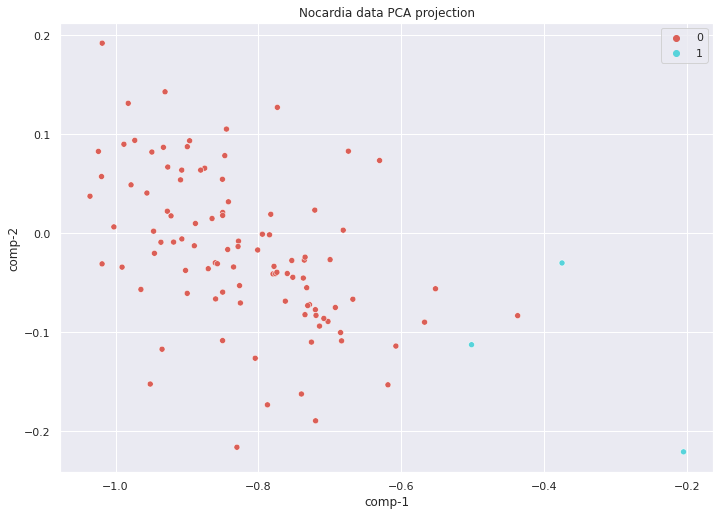

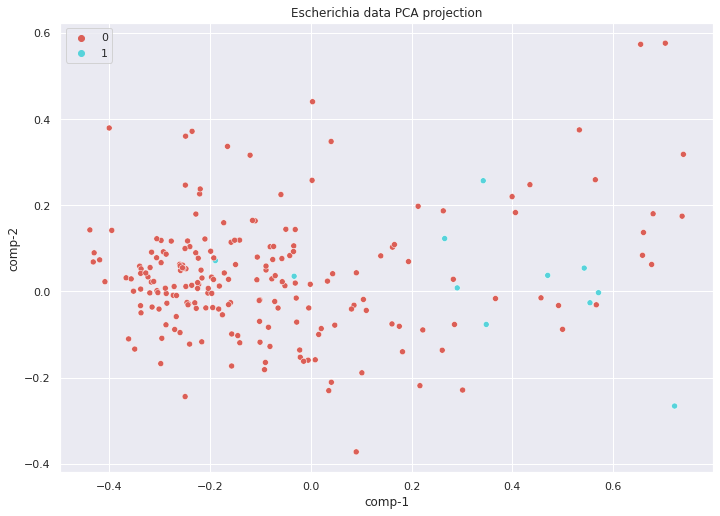

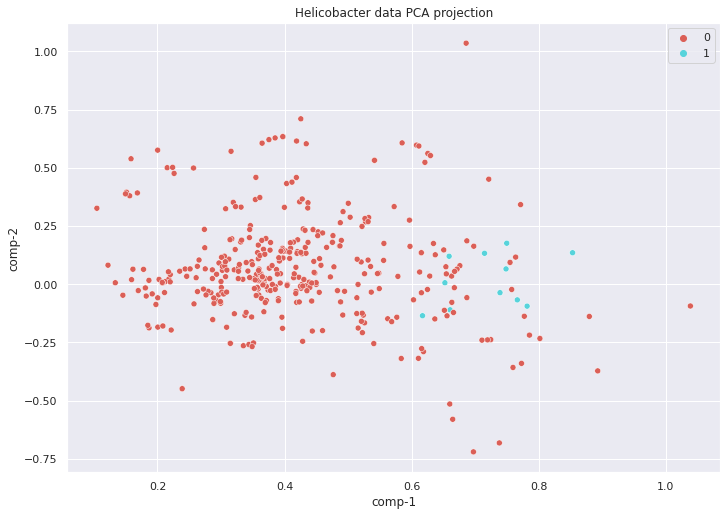

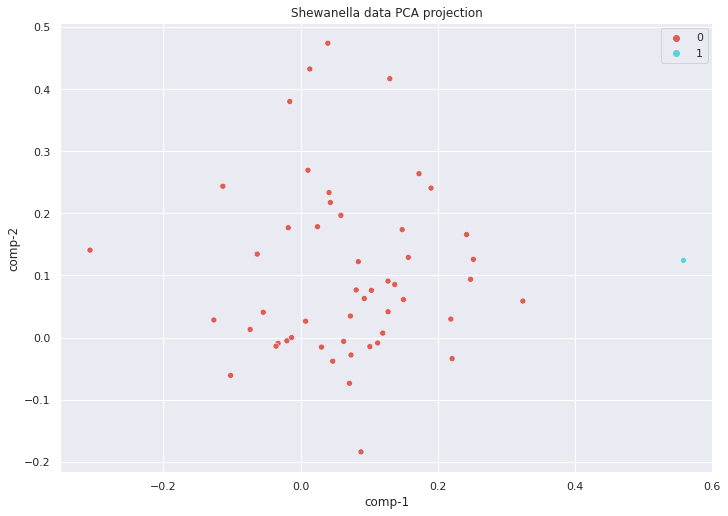

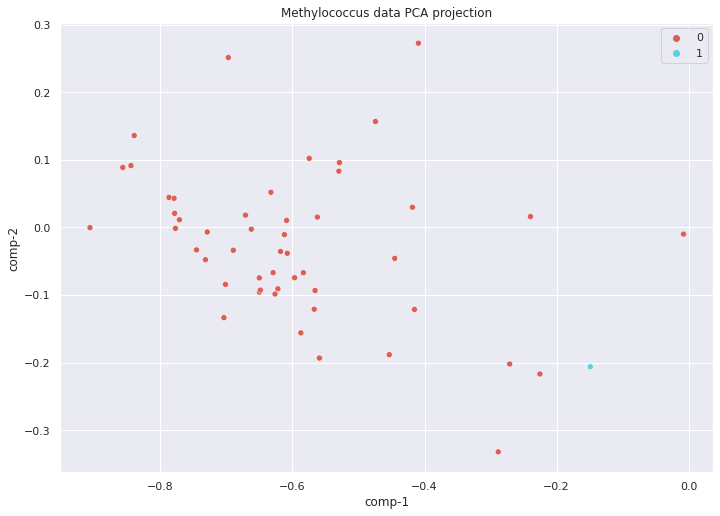

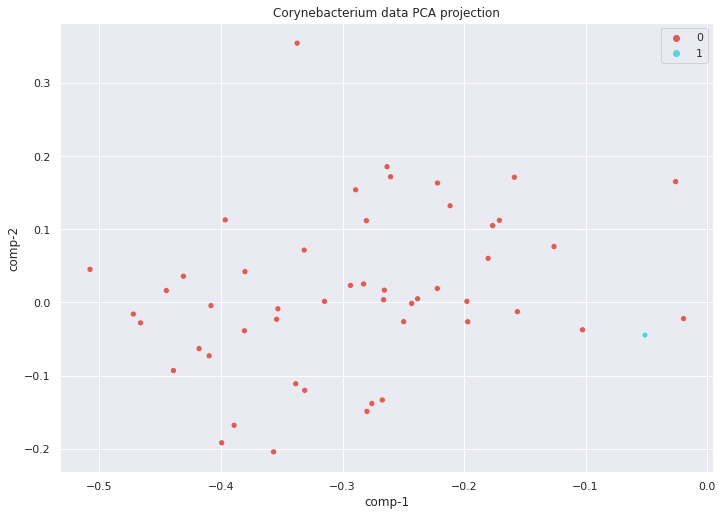

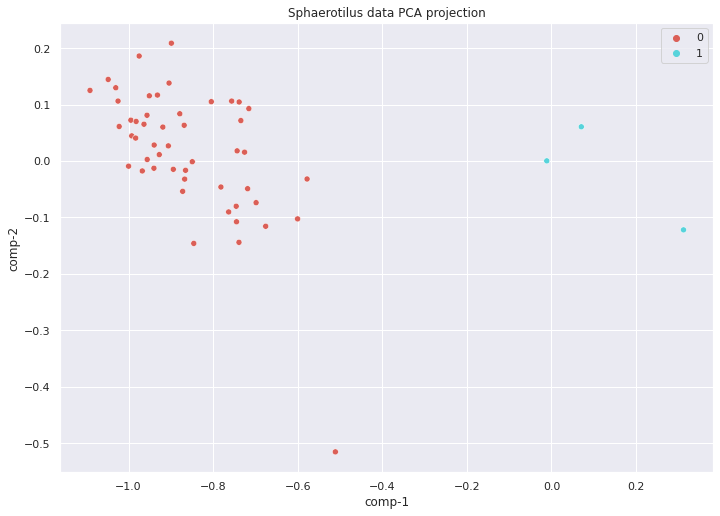

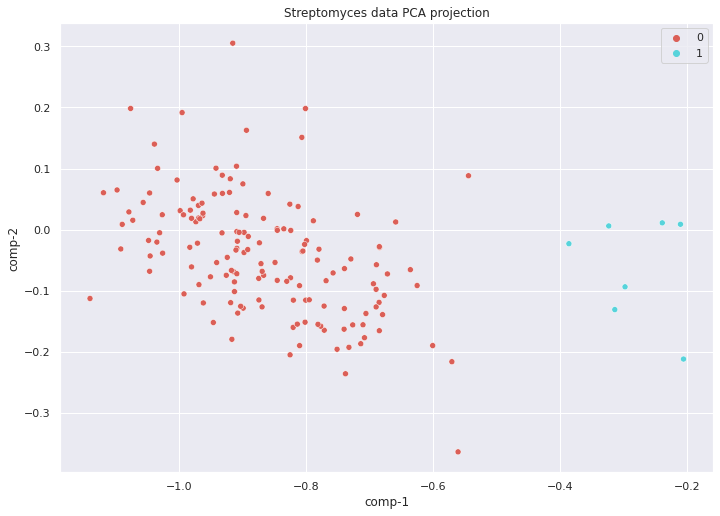

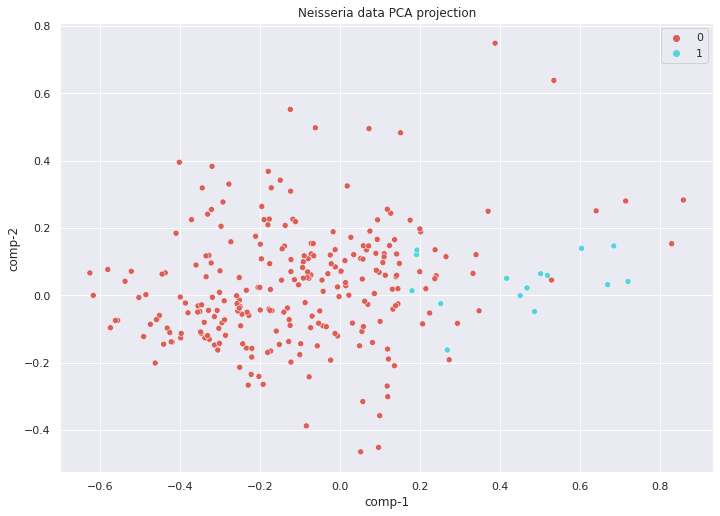

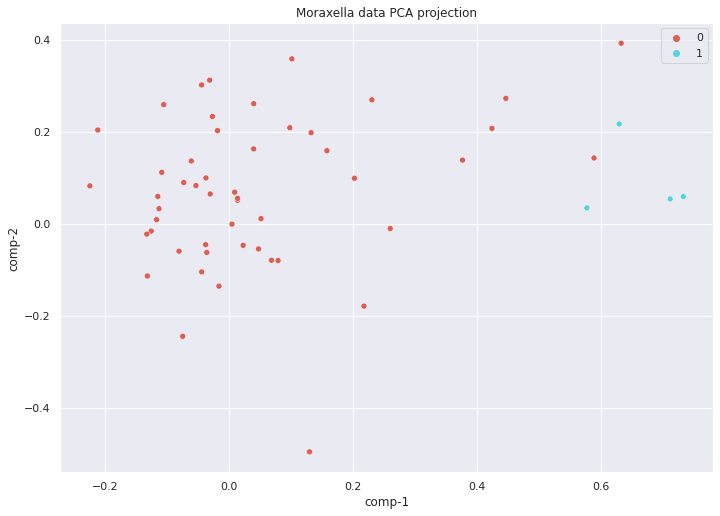

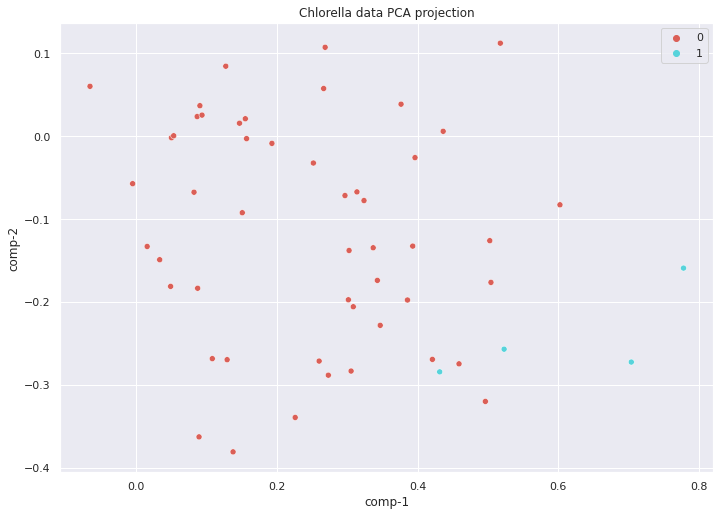

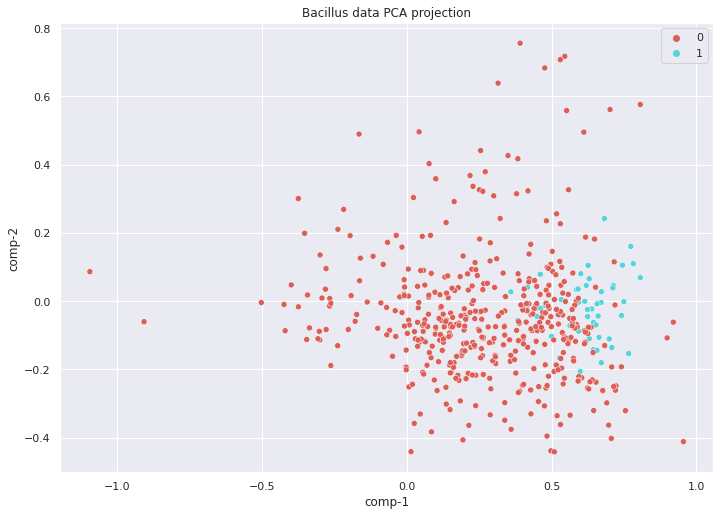

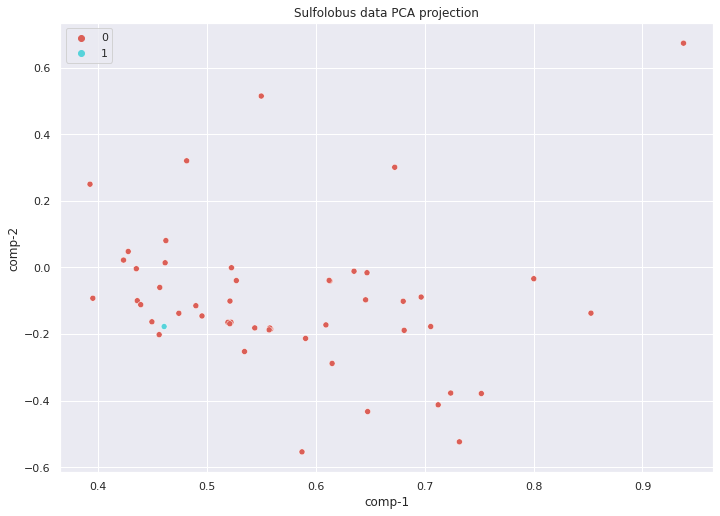

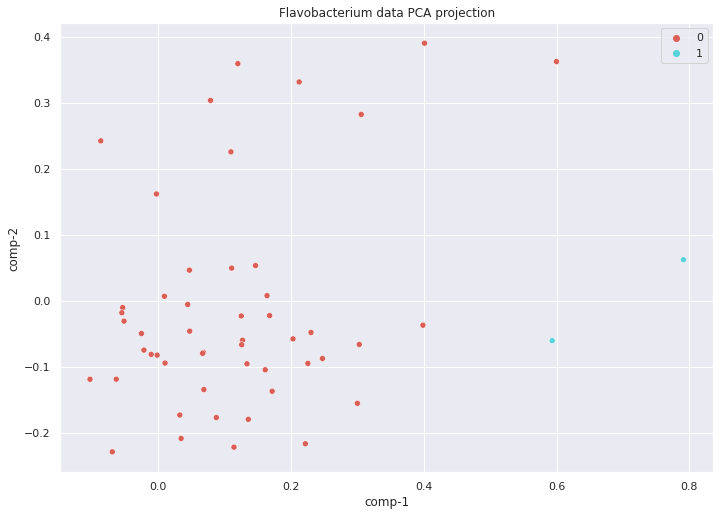

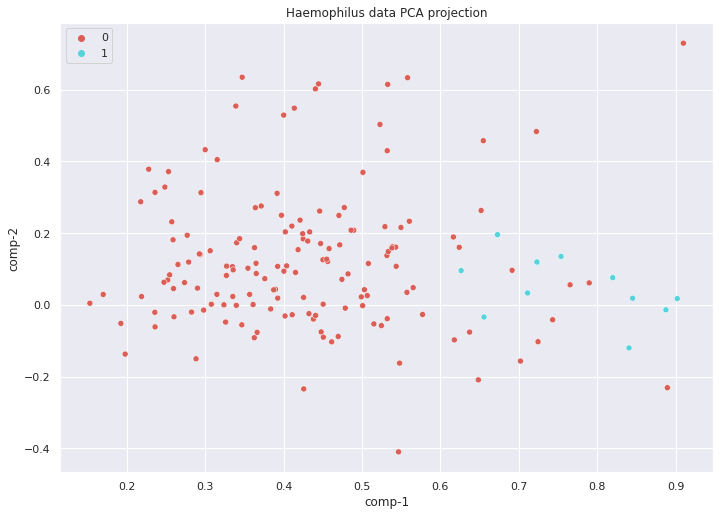

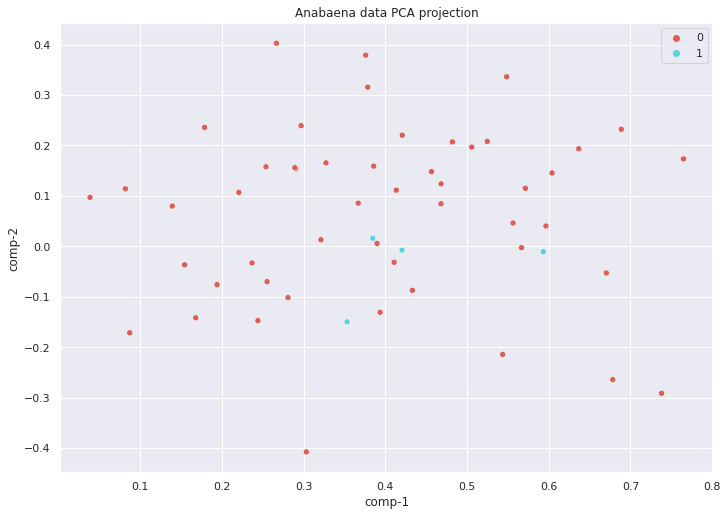

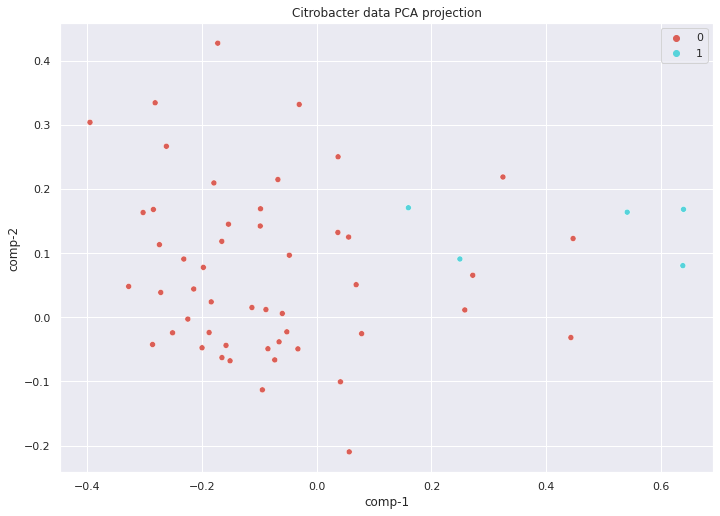

In [45]:
import matplotlib.pyplot as plt

for i in set(family_lables):
  df1= df.query('y==@i') ### very bad example: Thermococcus - maybe good
  if len(df1.color.unique())>1:
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.color.tolist(),
                      palette=sns.color_palette("hls", 2),sizes=[600,800],
                      data=df1).set(title=f"{i} data PCA projection")
      
    sns.set(rc={'figure.figsize':(11.7,8.27)})


# general function

In [46]:
def confusion_matrix_re(true_lables, pred_lables):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  sum = 0
  for true, pred in zip(true_lables, pred_lables):
    if true == 1 and  pred == -1:
      tp +=1
    if true == 1 and  pred != -1:
      fp += 1
    if true == 0 and  pred == -1:
      fn +=1
    if true == 0 and  pred != -1:
      tn +=1
  return tp/len(true_lables) , fp/len(true_lables), fn/len(true_lables),  tn/len(true_lables)



In [47]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics import homogeneity_completeness_v_measure


all_res_table= []


def clustering_function(familyes,df_data, df, algorithem, params):
  familyes =  sorted(familyes)
  num_of_family = 0
  for  i  in familyes:
    d = {}
    d['algo'] = algorithem
    df1= df.query('y==@i')
    df_data1 = df_data.query('family_lable==@i')
   
    true_labels = df_data1.is_RE.tolist()

    if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
      print('-------------------')
      print(i)
      d['family_lable'] = i 
      print (num_of_family ,i)
      if params:
        algo = algorithem(**params[num_of_family])
      else:
        algo = algorithem()
      pred_labels = algo.fit_predict(df1[['comp-1','comp-2']].values)
      if len(set(pred_labels))>1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        print(f"Adjusted Rand Index: {ari}")

        d['ari'] = ari 

        fmi = fowlkes_mallows_score(true_labels, pred_labels)
        print(f"fowlkes_mallows_score: {fmi}")

        d['fmi'] = fmi 

        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, pred_labels)
        print(f"homogeneity_completeness_v_measure: {homogeneity} {completeness} {v_measure}")


        d['homogeneity'] = homogeneity 
        d['completeness'] = completeness 
        d['v_measure'] = v_measure 

        tp, fp, fn, tn = confusion_matrix_re(true_labels, pred_labels)
        d['tp'] = tp
        d['fp'] = fp
        d['fn'] = fn
        d['tn'] = tn

        d['family_size'] = len(true_labels)
        d['re_size'] = np.sum(true_labels)


        all_res_table.append(d)
      else:
        print('caoudnot seperate to clusters')

      num_of_family +=1

      markers = ["." if label == 0 else "d" for label in true_labels]
      if -1 in pred_labels:
        colors = ["red" if label == -1 else "black" for label in pred_labels]
      else:
        colors = ["blue" if label == 1 else  "orange" for label in pred_labels]

    

      for i in range(len(markers)):
        plt.scatter(df1['comp-1'].values[i], df1['comp-2'].values[i], c=colors[i] ,marker=markers[i])
      plt.show()





# dbscan

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

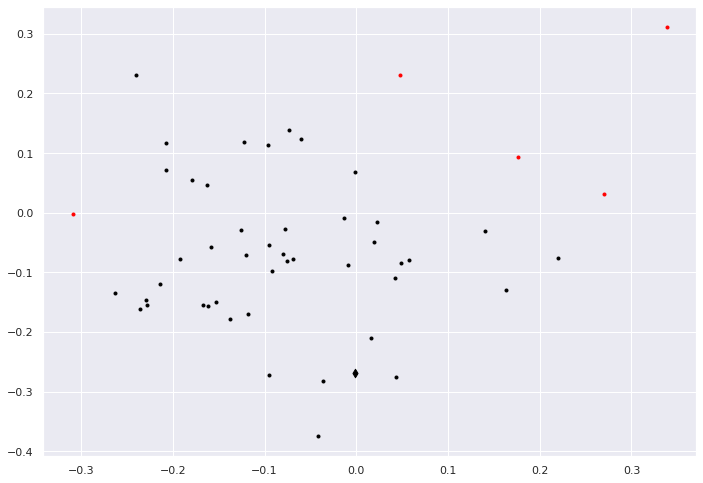

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


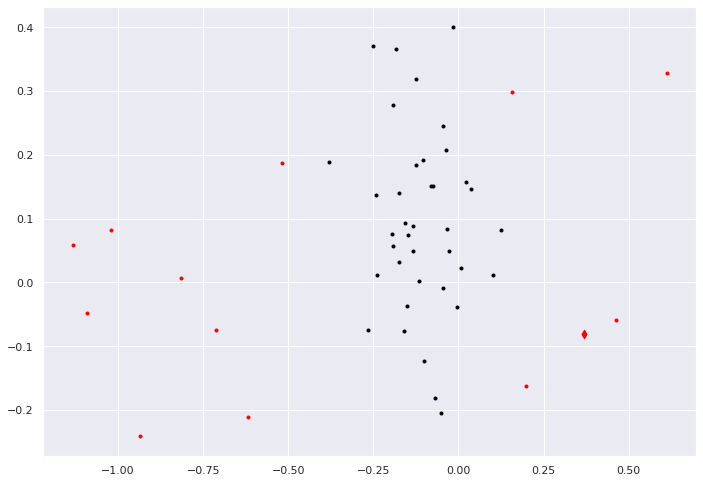

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


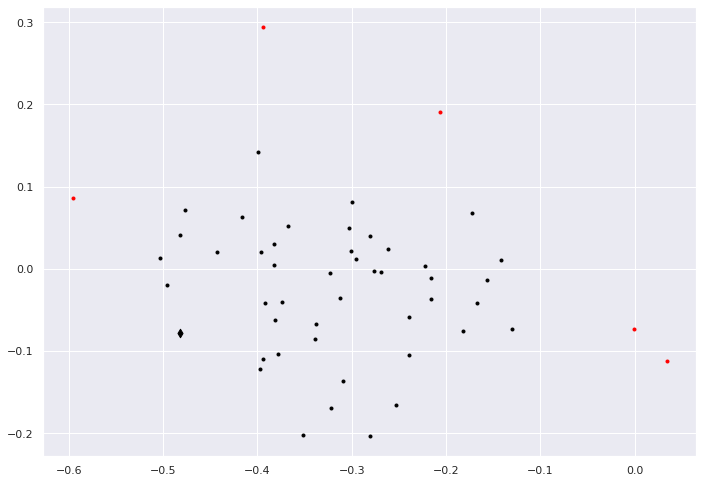

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.08355668802057667
fowlkes_mallows_score: 0.7823973604005919
homogeneity_completeness_v_measure: 0.04689086501750941 0.02951637663307366 0.036228200432540124


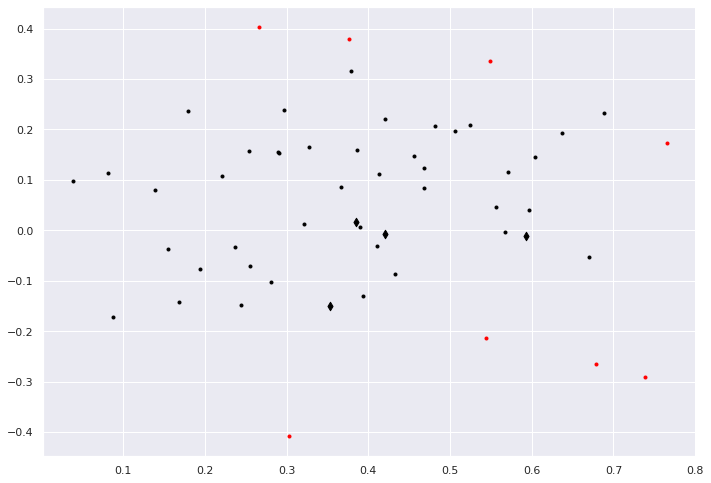

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.07272002669111087
fowlkes_mallows_score: 0.7090961329680366
homogeneity_completeness_v_measure: 0.3344797952096191 0.04679808577309396 0.082108167960031


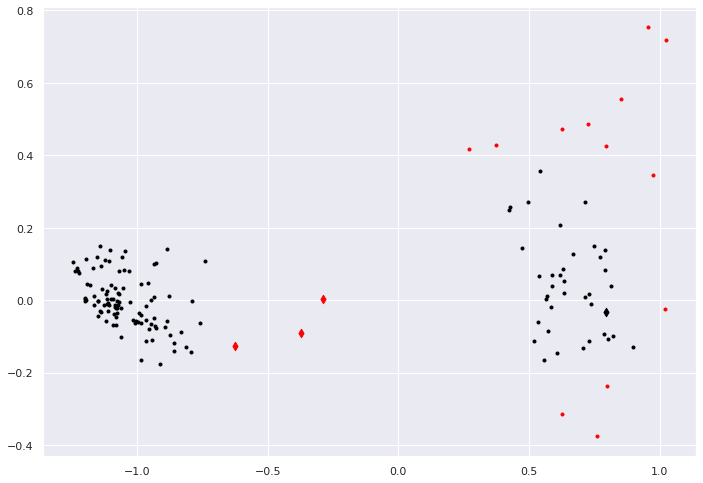

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.015323613233654124
fowlkes_mallows_score: 0.46265194557299216
homogeneity_completeness_v_measure: 0.1933483228506048 0.012427688645966098 0.023354255329680065


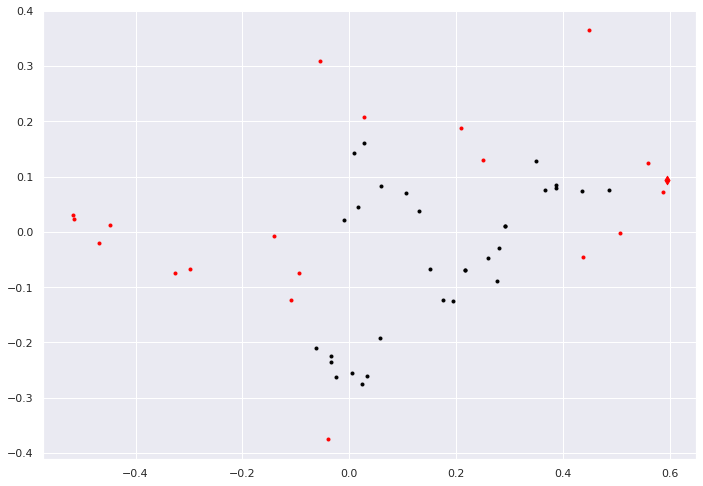

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.0673476038055237
fowlkes_mallows_score: 0.700948142095668
homogeneity_completeness_v_measure: 0.028370843093581108 0.012689701053894588 0.017535935043209952


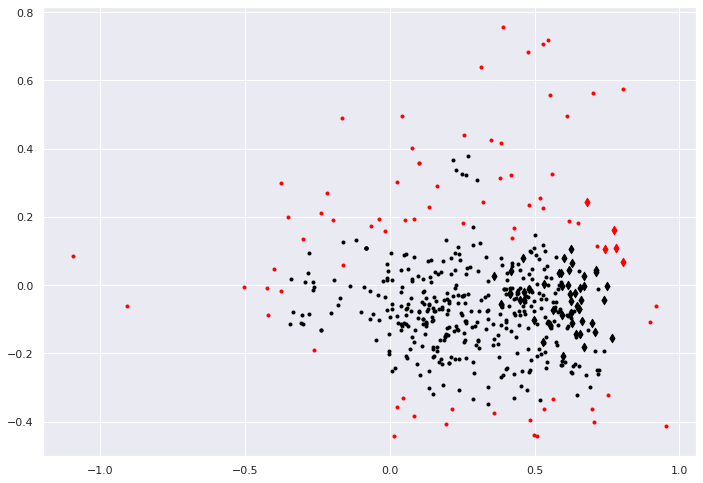

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.024074074074074074
fowlkes_mallows_score: 0.6282341820534548
homogeneity_completeness_v_measure: 0.17219431297355753 0.02955775899495014 0.05045477802049933


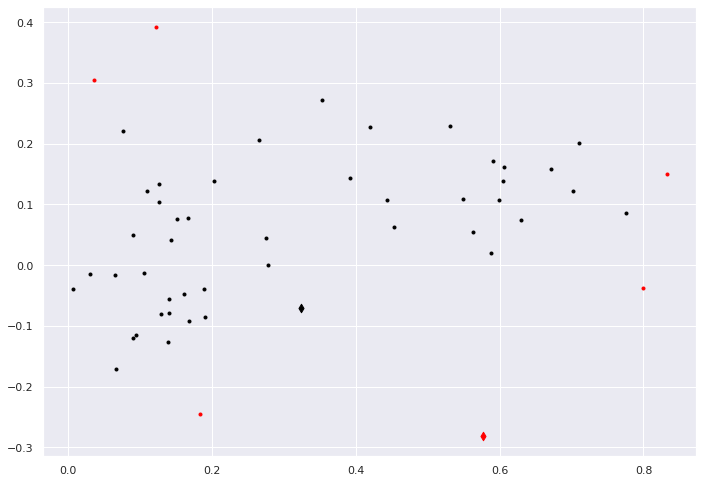

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.029874758939028478
fowlkes_mallows_score: 0.6744340586648653
homogeneity_completeness_v_measure: 0.1539387066214905 0.02025933759319995 0.035806328827224974


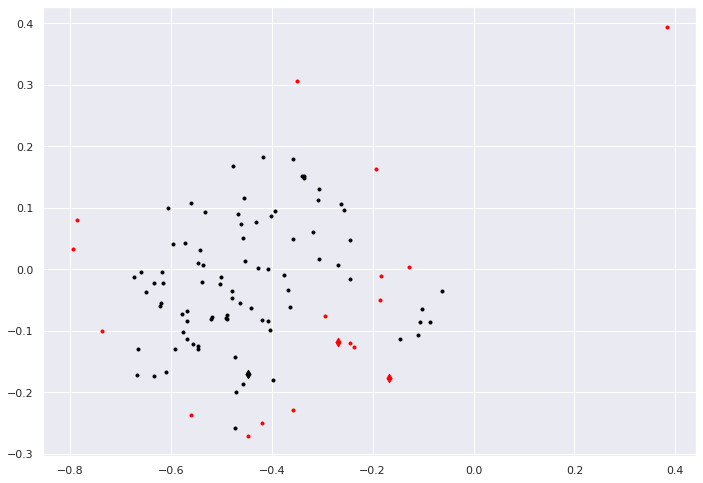

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


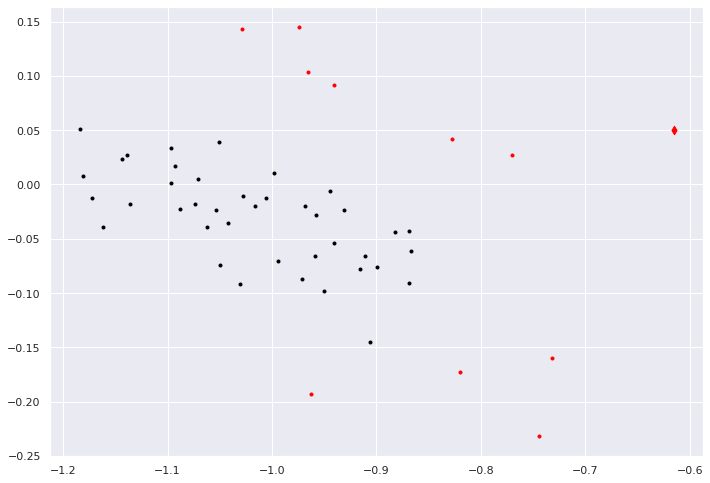

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.4187652315190902
fowlkes_mallows_score: 0.9187652315190902
homogeneity_completeness_v_measure: 0.21663901241626124 0.21663901241626124 0.21663901241626124


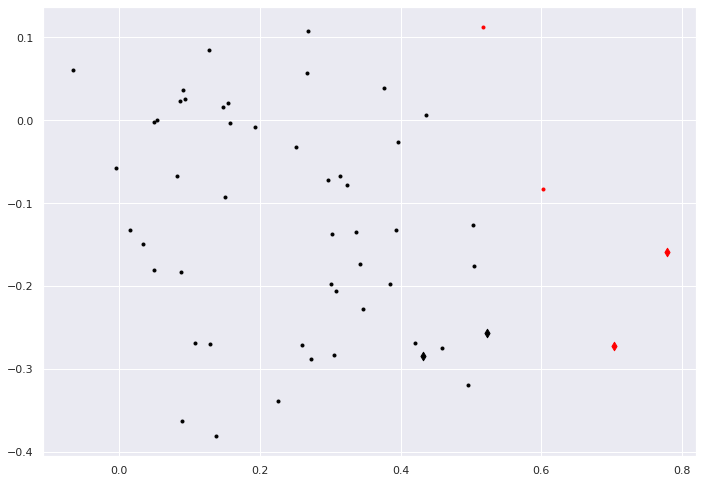

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.05421772071724674
fowlkes_mallows_score: 0.6867652688645912
homogeneity_completeness_v_measure: 0.3798733828471206 0.0334947982946263 0.06156149852084809


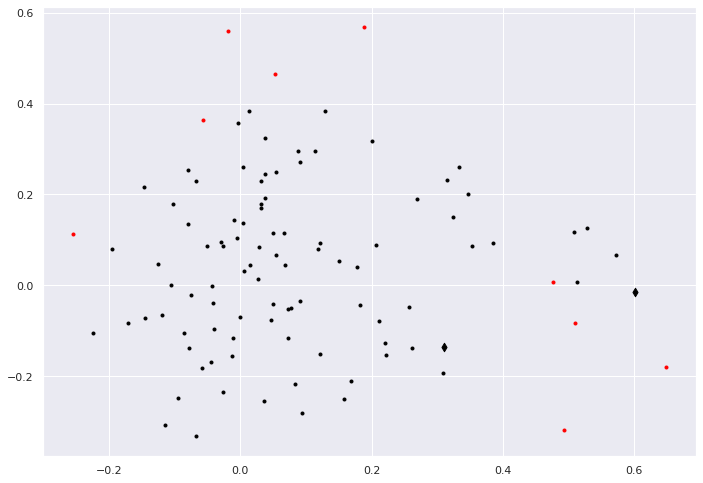

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.34154883901932803
fowlkes_mallows_score: 0.8364354502155553
homogeneity_completeness_v_measure: 0.28480758549359114 0.17338579363136494 0.2155491174374741


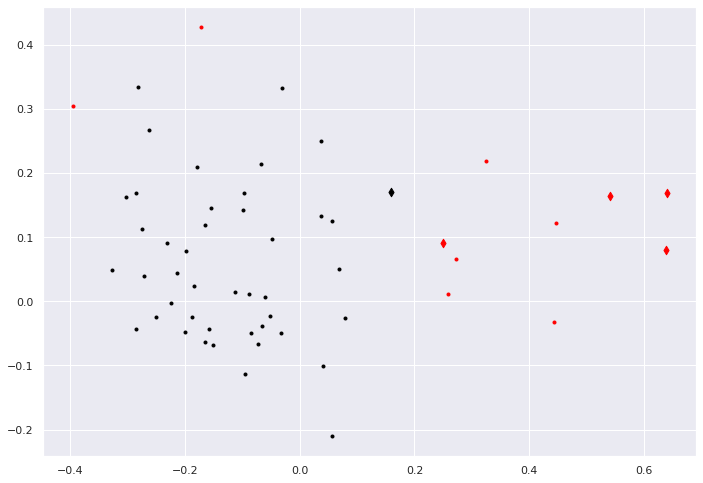

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.02456661365704707
fowlkes_mallows_score: 0.8393118154917149
homogeneity_completeness_v_measure: 0.027731408379997338 0.00650699604084759 0.01054068772117841


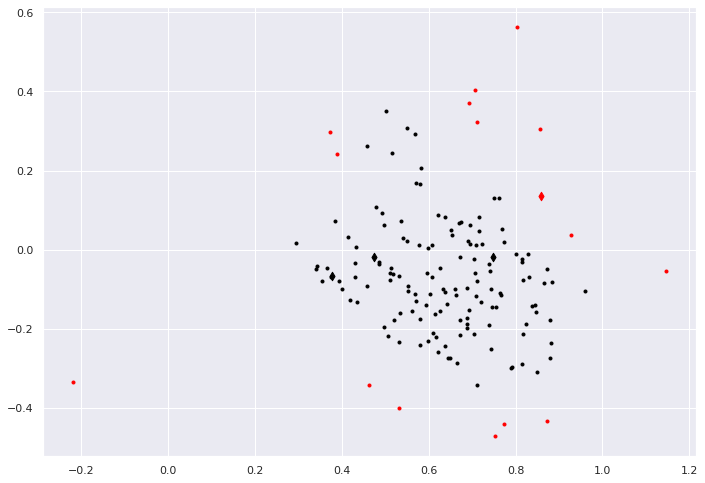

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.07004239771121298
fowlkes_mallows_score: 0.7538147272186949
homogeneity_completeness_v_measure: 0.36214622269949165 0.04559099561789445 0.08098650851773632


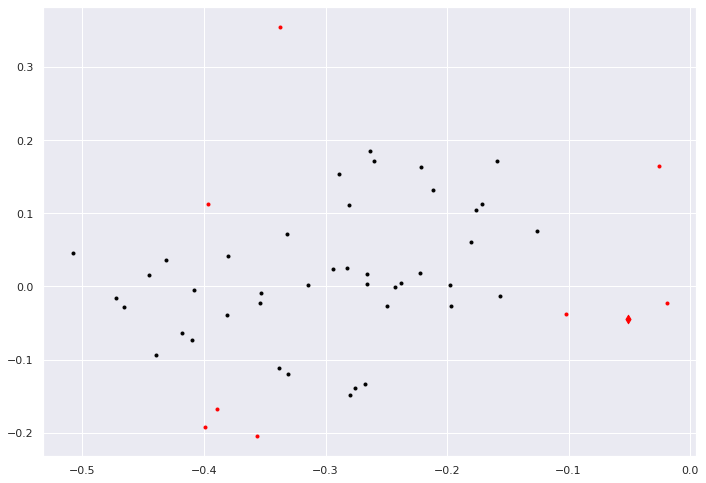

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


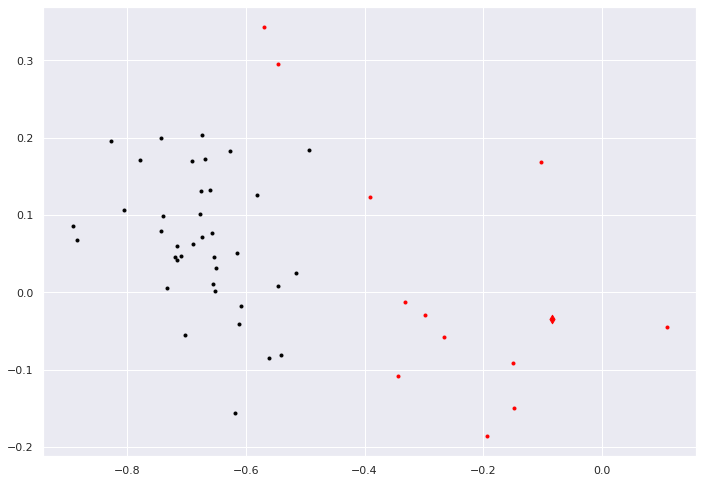

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.2828243031075036
fowlkes_mallows_score: 0.9209363243736874
homogeneity_completeness_v_measure: 0.49166314964863217 0.14793273715302432 0.22743446912551596


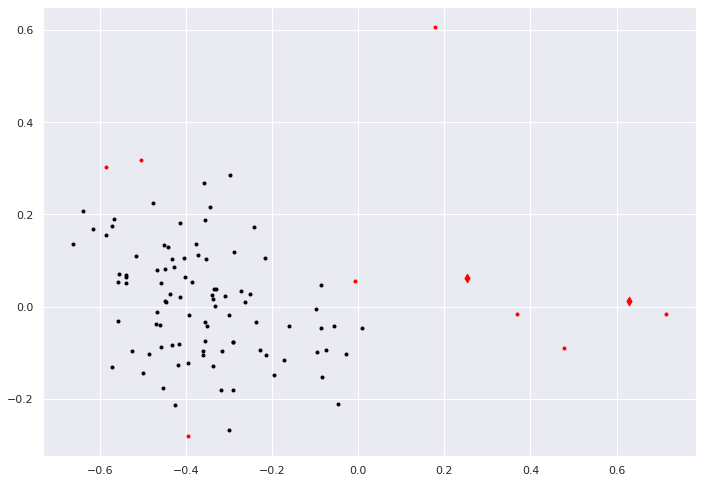

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


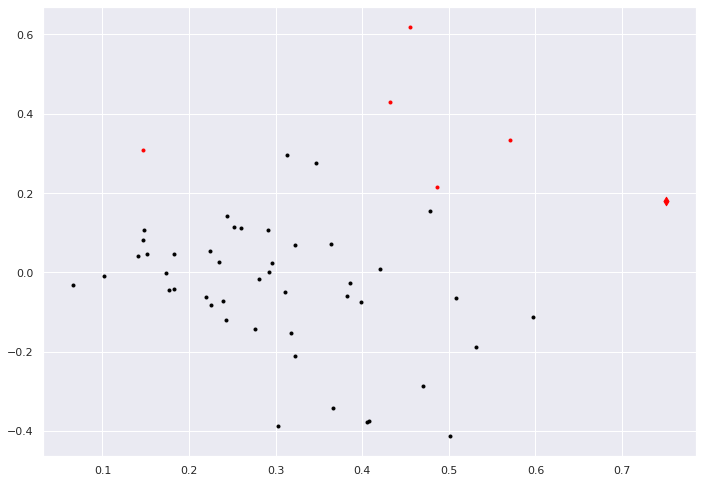

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.7758362882898279
fowlkes_mallows_score: 0.9561592502843783
homogeneity_completeness_v_measure: 0.7500512813611632 0.599452157462862 0.6663485929484374


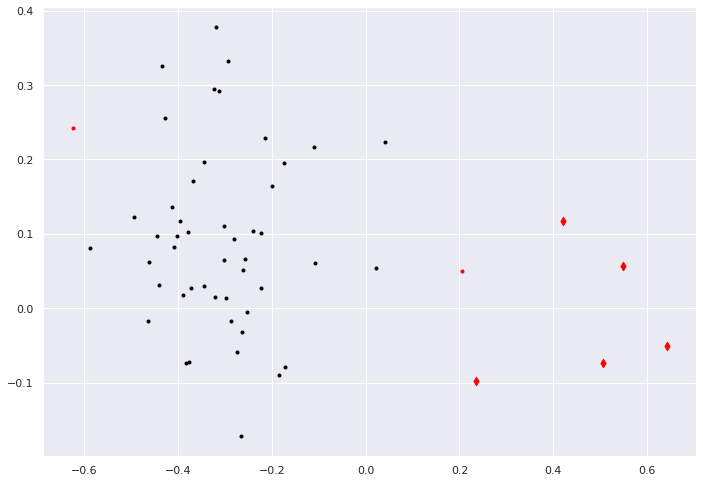

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.1969659402268887
fowlkes_mallows_score: 0.8197618130521077
homogeneity_completeness_v_measure: 0.2281864189623399 0.09014948145263033 0.12924013482093719


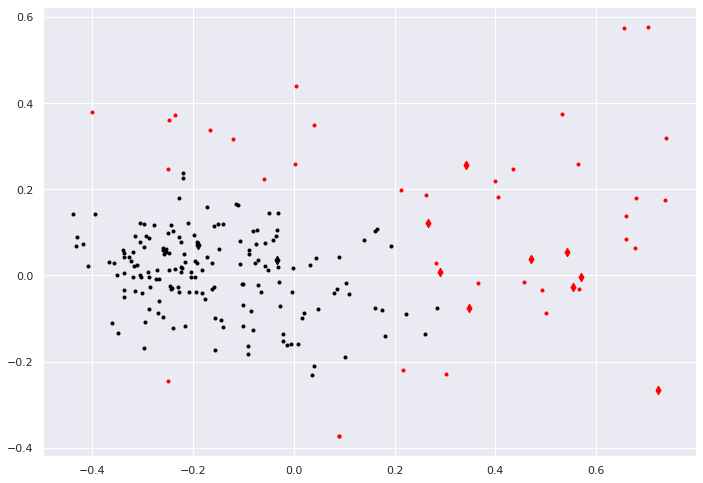

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030212541717899173
fowlkes_mallows_score: 0.9021274818888028
homogeneity_completeness_v_measure: 0.016766492616712907 0.005885742781720218 0.008712893995478197


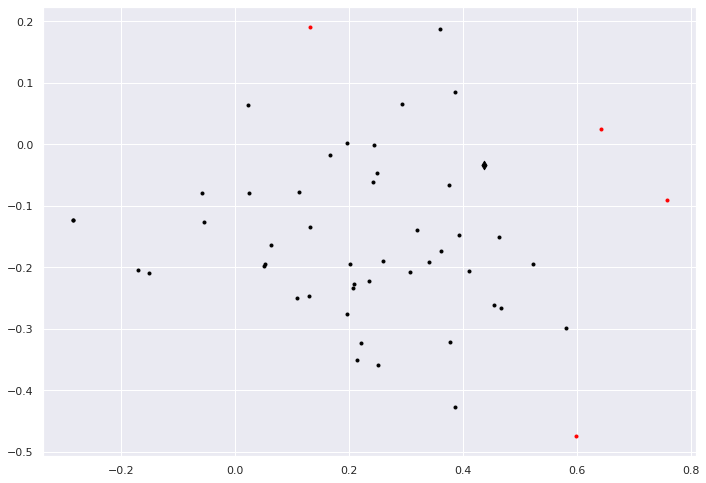

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


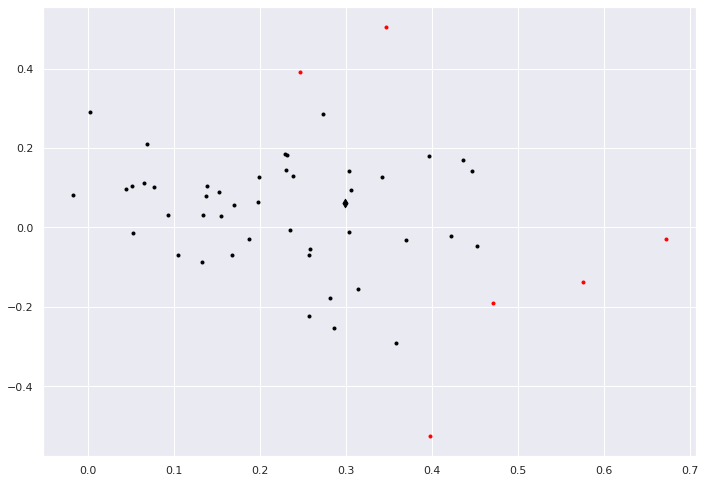

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.6198307300626161
fowlkes_mallows_score: 0.9583555915861839
homogeneity_completeness_v_measure: 0.672936898444718 0.4045313958088335 0.505303226593225


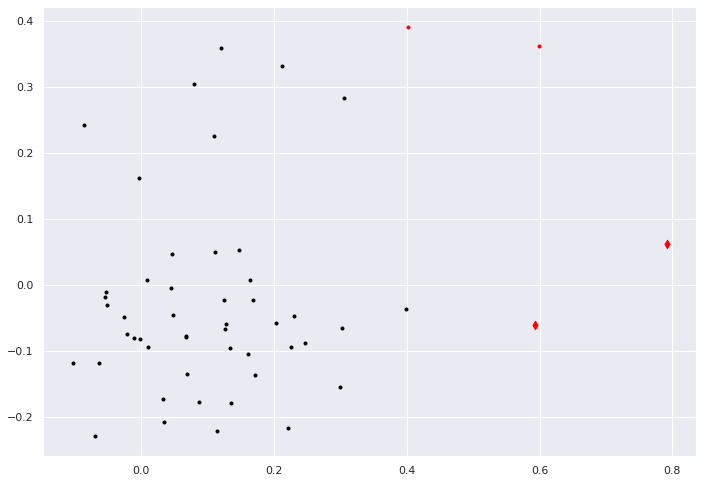

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.463618802318094
fowlkes_mallows_score: 0.9591678096644419
homogeneity_completeness_v_measure: 0.6120359227353217 0.2640240425582367 0.36890670710490103


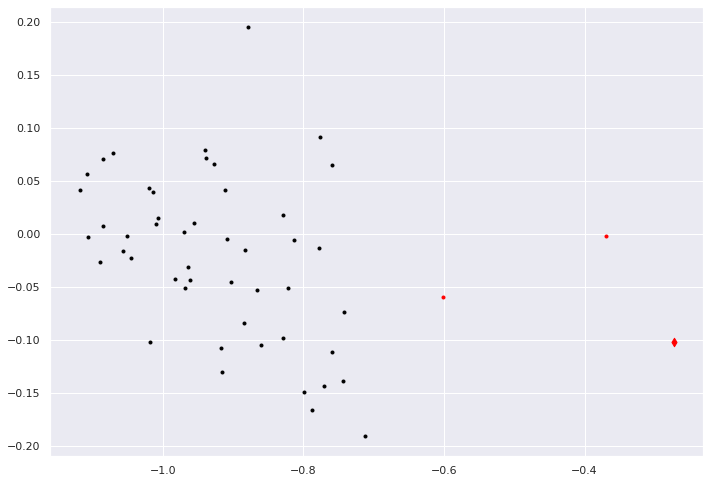

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.21754285051626585
fowlkes_mallows_score: 0.7511952582087417
homogeneity_completeness_v_measure: 0.5351957592312341 0.14065369278888057 0.2227633970133967


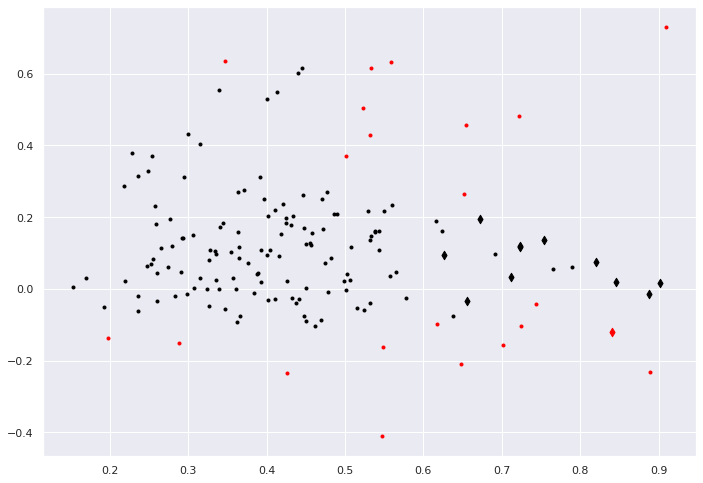

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.042669243452844154
fowlkes_mallows_score: 0.7183202258054832
homogeneity_completeness_v_measure: 0.12462384233030616 0.013815251466313416 0.024873172357235053


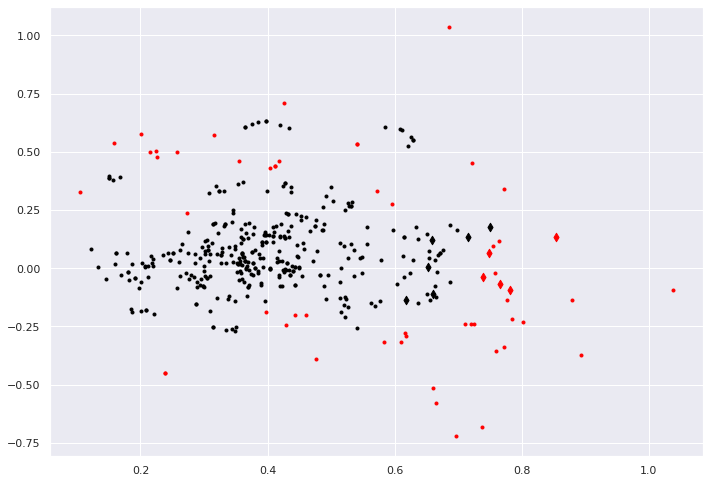

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.21004037470199277
fowlkes_mallows_score: 0.8932206327229614
homogeneity_completeness_v_measure: 0.433030470614115 0.10954123194031691 0.17485132746673832


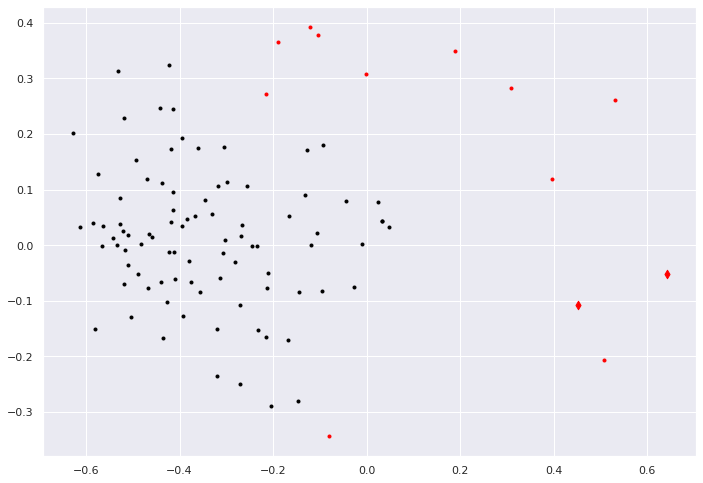

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.09077367563406612
fowlkes_mallows_score: 0.7708547611282796
homogeneity_completeness_v_measure: 0.049380025491908175 0.03627052046444513 0.041822015379838304


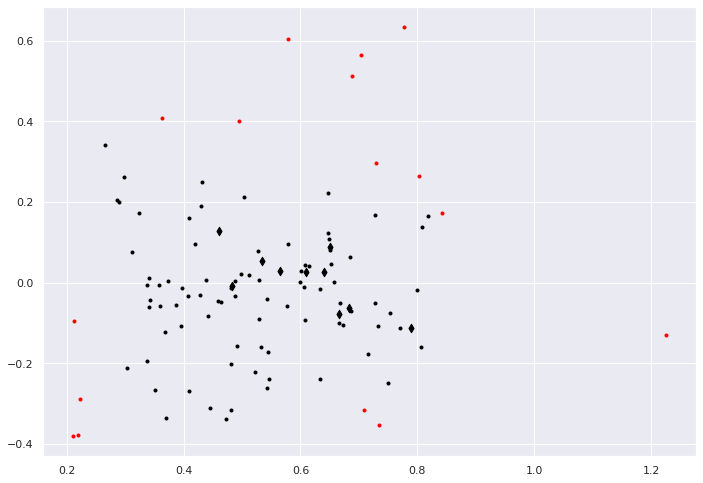

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.004530386740331491
fowlkes_mallows_score: 0.7624363825389481
homogeneity_completeness_v_measure: 0.00035665563765597906 0.0002291524422482721 0.00027902827978692514


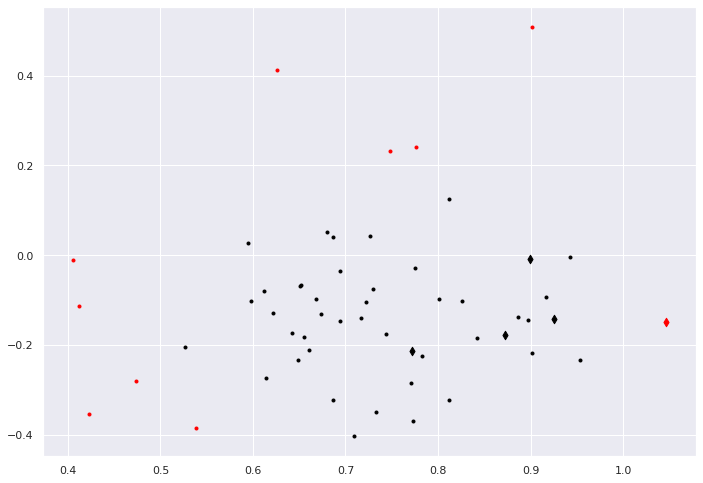

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.19123693175143897
fowlkes_mallows_score: 0.8829621891004893
homogeneity_completeness_v_measure: 0.4167331755524075 0.1005590683364424 0.16202175993746998


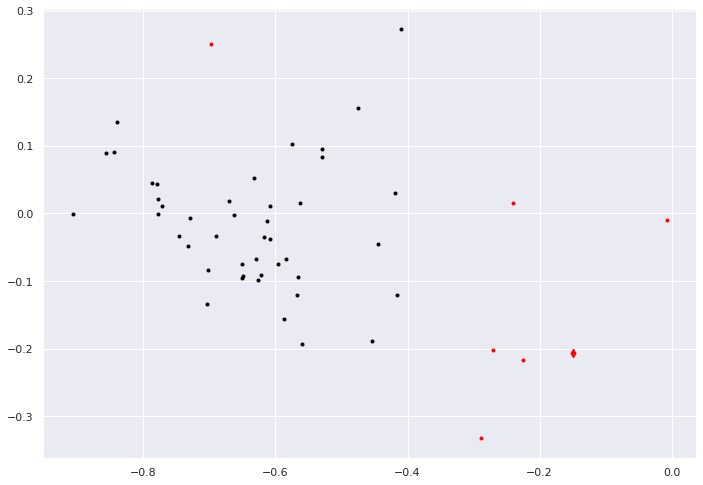

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.3464974982130093
fowlkes_mallows_score: 0.8378265945976596
homogeneity_completeness_v_measure: 0.4643192810794364 0.23145747414196582 0.30892140959742714


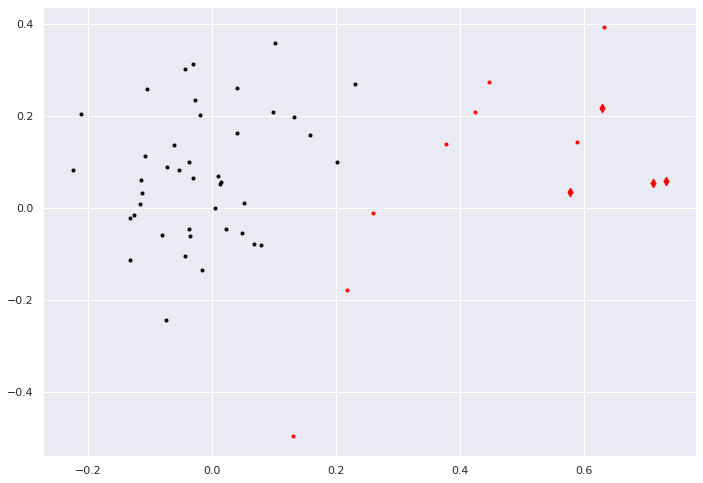

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.051559628408146825
fowlkes_mallows_score: 0.865518723145527
homogeneity_completeness_v_measure: 0.02434732630227051 0.012538942970179568 0.0165530286473585


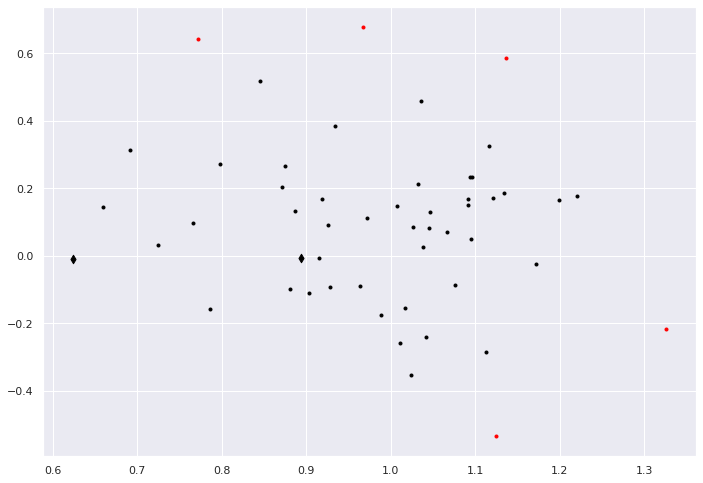

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.33276342945037823
fowlkes_mallows_score: 0.8640547316471278
homogeneity_completeness_v_measure: 0.3739551817689216 0.17615931118108788 0.2394980974951266


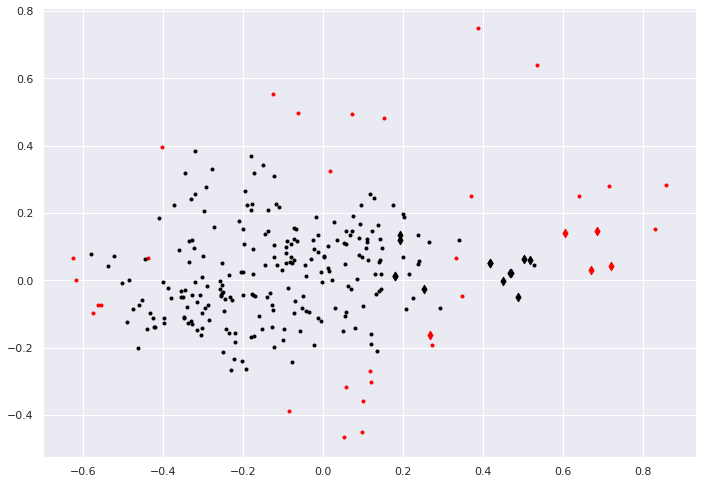

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.23679316557215088
fowlkes_mallows_score: 0.8739903106280192
homogeneity_completeness_v_measure: 0.43076452853860614 0.13135726706192516 0.2013230999363743


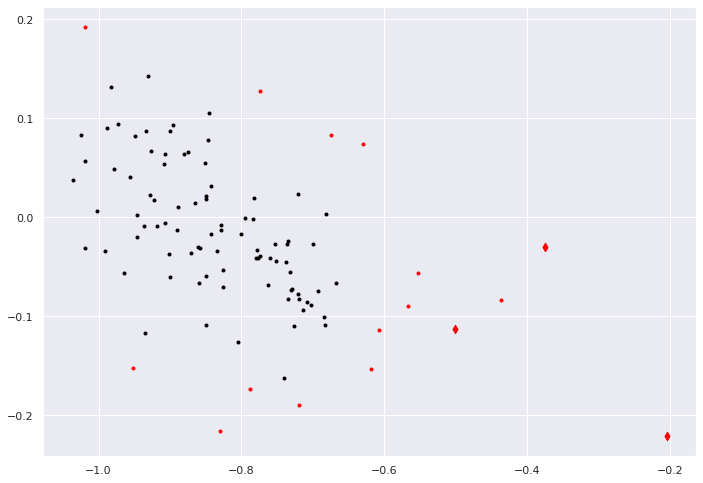

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.0540378120455283
fowlkes_mallows_score: 0.8103713442361439
homogeneity_completeness_v_measure: 0.010841514979421834 0.006824404695589074 0.00837622802480222


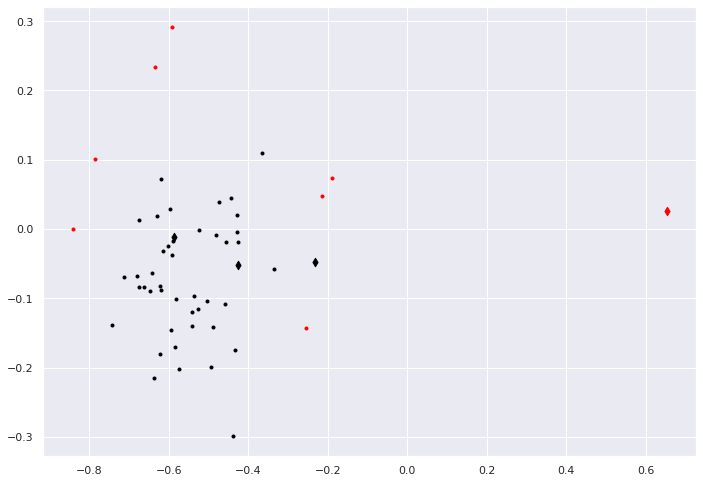

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.0943216257303731
fowlkes_mallows_score: 0.7585853626102242
homogeneity_completeness_v_measure: 0.34342867841968117 0.061286486377227355 0.10401160545629132


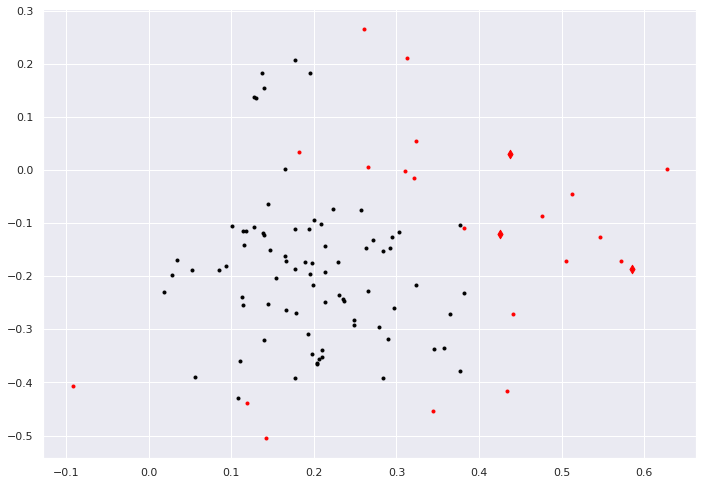

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.050876132930513594
fowlkes_mallows_score: 0.7051428571428571
homogeneity_completeness_v_measure: 0.3621462226994948 0.040312470743262524 0.07254910501483737


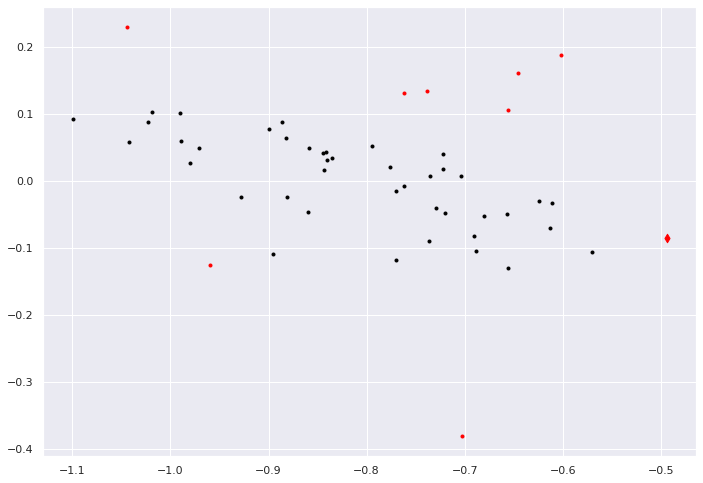

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: -0.016338964205780907
fowlkes_mallows_score: 0.6307919900460566
homogeneity_completeness_v_measure: 0.15899339002802168 0.02921839754553487 0.049364942938395495


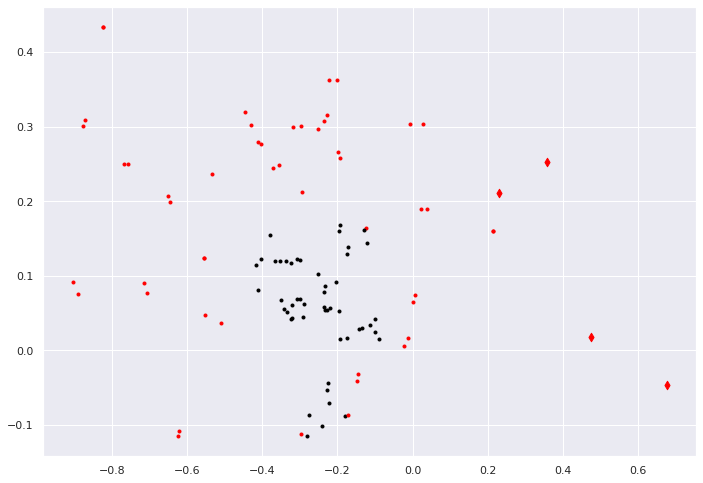

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


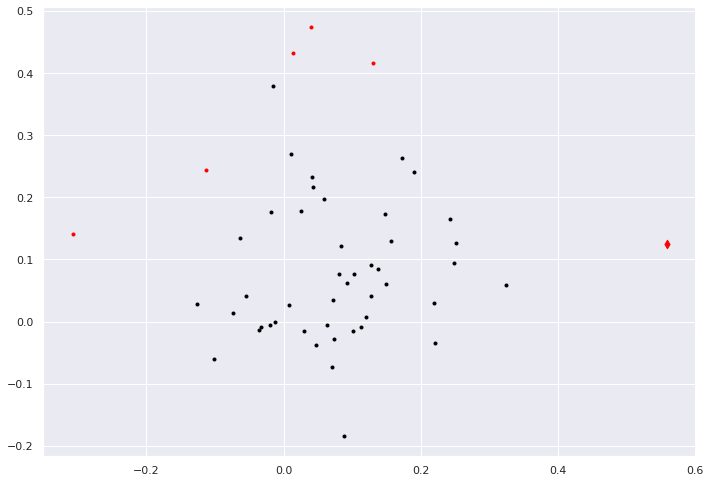

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.6980018048214516
fowlkes_mallows_score: 0.9575823054437779
homogeneity_completeness_v_measure: 0.7081092142671571 0.49294165155975356 0.5812518611777698


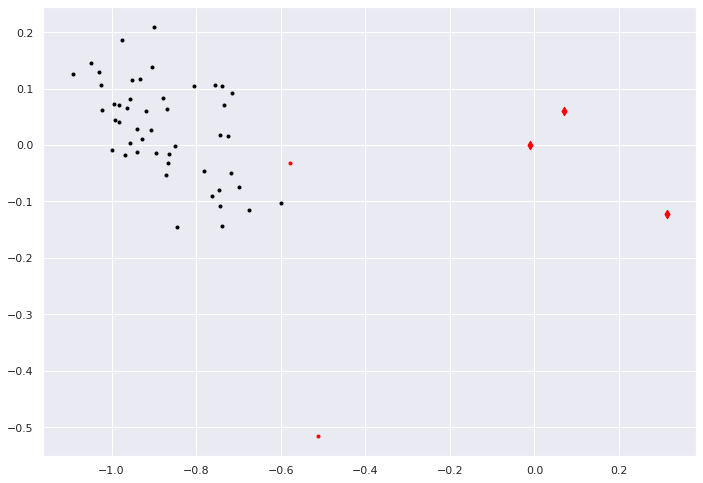

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.038263335062352764
fowlkes_mallows_score: 0.7645780095443745
homogeneity_completeness_v_measure: 0.01304072847887799 0.005385452344638831 0.00762287339248717


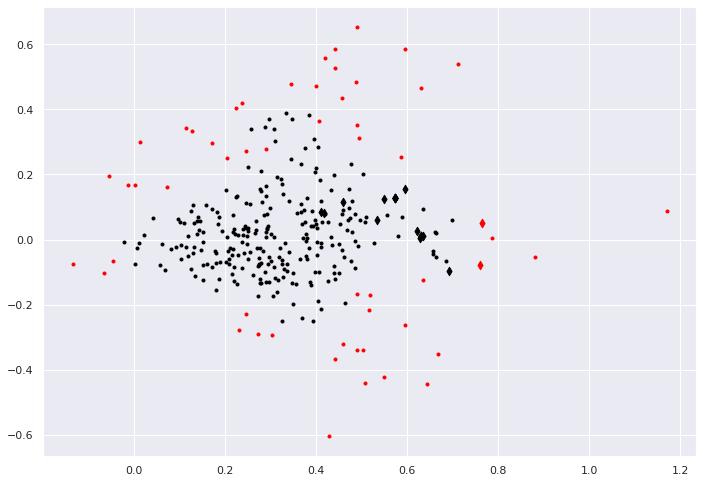

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.513545721776436
fowlkes_mallows_score: 0.9320662360091536
homogeneity_completeness_v_measure: 0.597489531419879 0.31756656014498963 0.4147127087939871


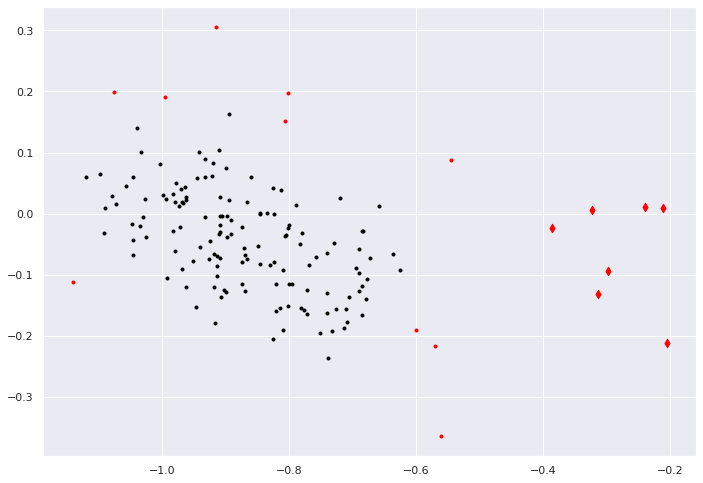

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


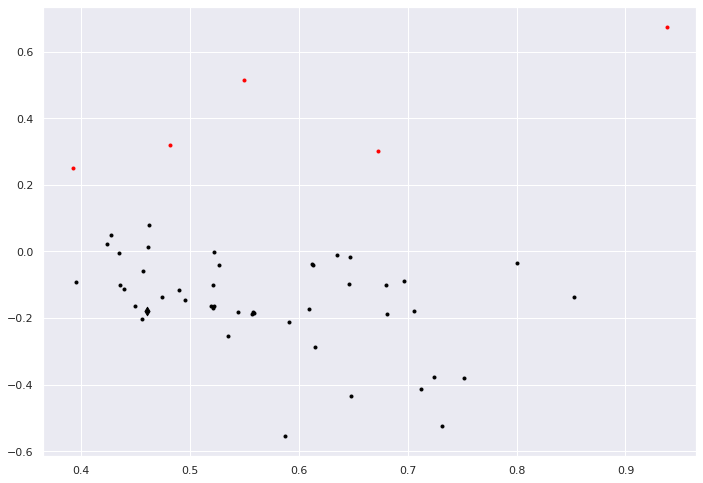

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.028976175144880875
fowlkes_mallows_score: 0.9209370289426528
homogeneity_completeness_v_measure: 0.012443374527241603 0.005367903947640151 0.007500285770158736


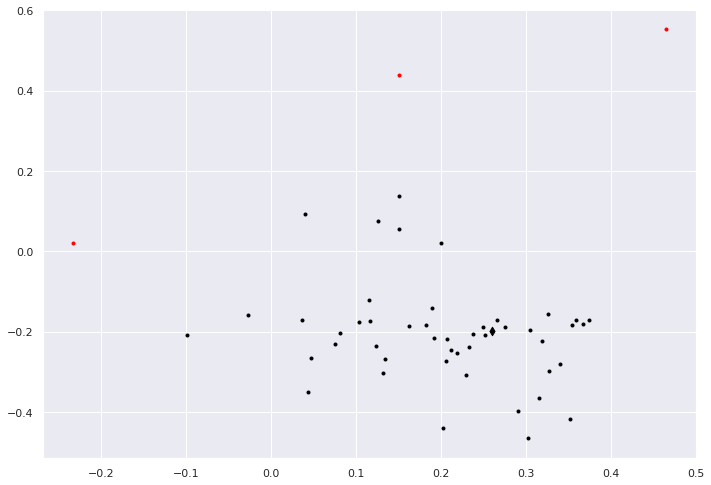

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


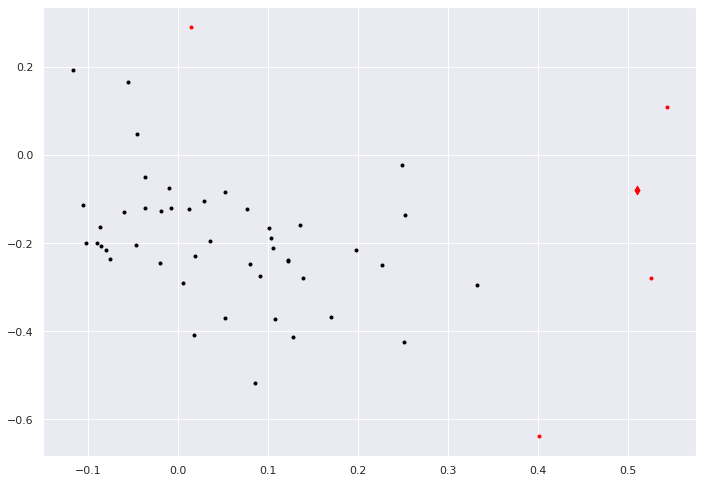

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.06109972331032261
fowlkes_mallows_score: 0.7555977566648331
homogeneity_completeness_v_measure: 0.3006782061690181 0.039877695276661886 0.07041636237129739


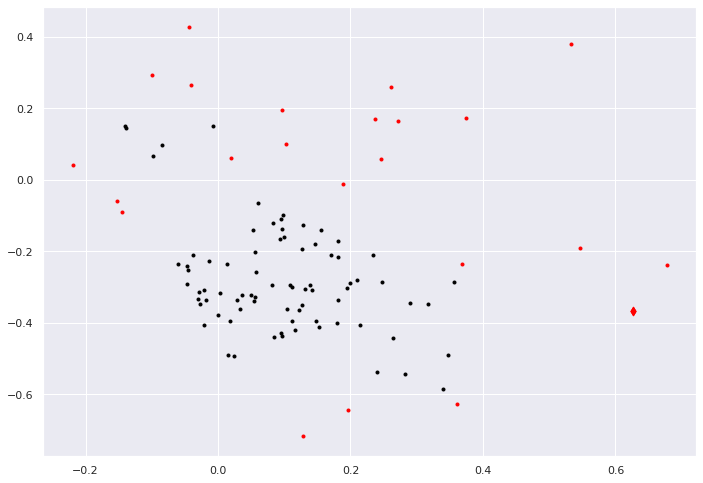

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.22639408707376582
fowlkes_mallows_score: 0.8565012520046696
homogeneity_completeness_v_measure: 0.41327638145856493 0.13007690092967075 0.19787387937098252


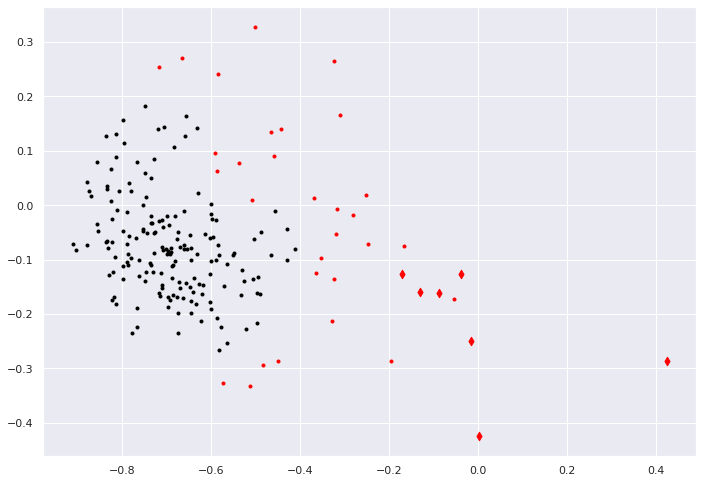

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.17093873162247514
fowlkes_mallows_score: 0.8546222800433261
homogeneity_completeness_v_measure: 0.1442379221710897 0.047407662112418654 0.07136071205239647


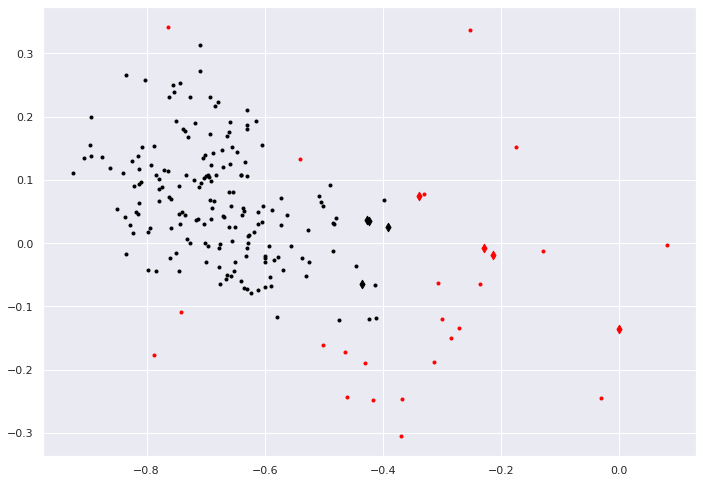

In [48]:
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
  if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df1[['comp-1','comp-2']])
    distances, indices = nbrs.kneighbors(df1[['comp-1','comp-2']])
    distances = np.sort(distances[:,1], axis=0)
    values.append({'eps':np.round(np.quantile(distances,0.95),5)})
print(len(values))
clustering_function(familyes,df_data, df, DBSCAN, params = values)

In [49]:

# from sklearn.cluster import KMeans

# # params for dbscan
# values = []
# familyes = sorted(set(family_lables))
# print(familyes)
# for i in familyes:    
#   df1= df.query('y==@i')
#   df_data1 = df_data.query('family_lable==@i')
#   true_labels = df_data1.is_RE.tolist()
# # print(len(familyes))
#   values.append({'n_clusters':2})
# clustering_function(familyes,df_data, df, KMeans, params=values)

# IsolationForest

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

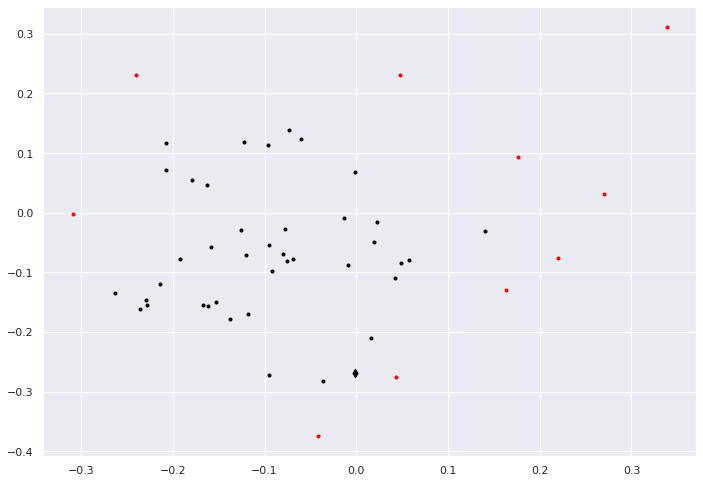

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.04606858330446831
fowlkes_mallows_score: 0.7479575920067657
homogeneity_completeness_v_measure: 0.24000422165857632 0.03723589815953225 0.06446954907824871


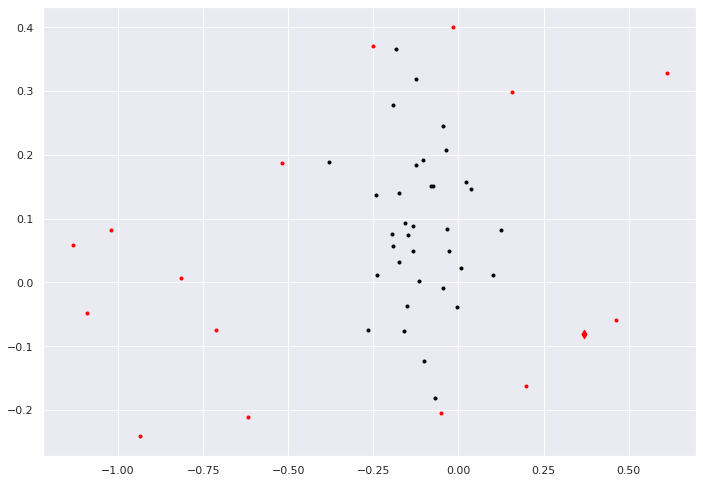

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.02841429880843263
fowlkes_mallows_score: 0.8014526153676969
homogeneity_completeness_v_measure: 0.04483591126959422 0.008743003913873719 0.014632642201502092


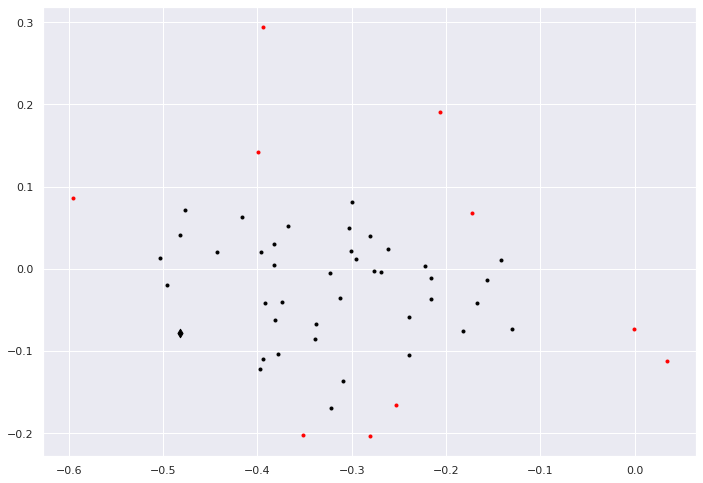

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.06574900771919986
fowlkes_mallows_score: 0.6825395047309912
homogeneity_completeness_v_measure: 0.10323245263598924 0.04485607357718154 0.06253830204680641


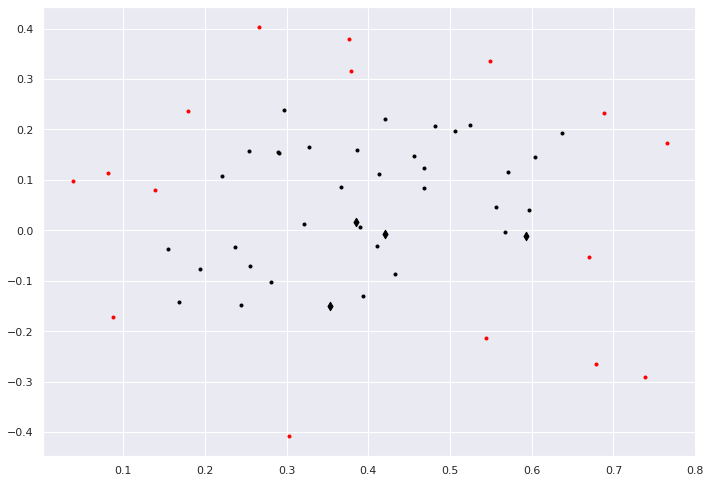

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.08011448916192537
fowlkes_mallows_score: 0.8021309786996907
homogeneity_completeness_v_measure: 0.13679199290838914 0.030743757619945508 0.050204208487591565


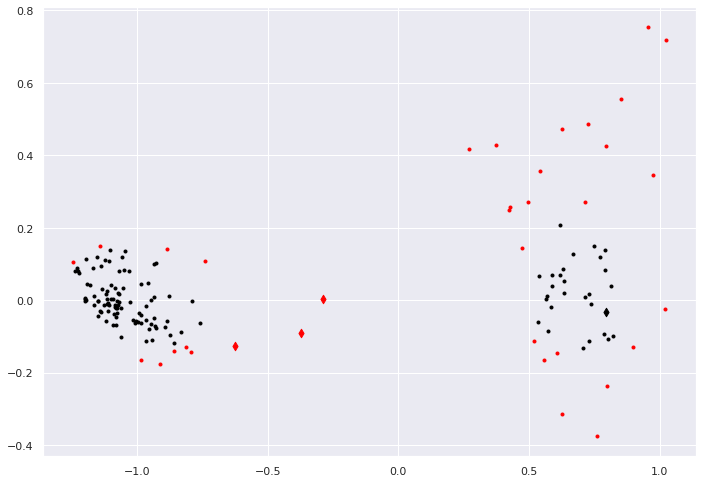

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


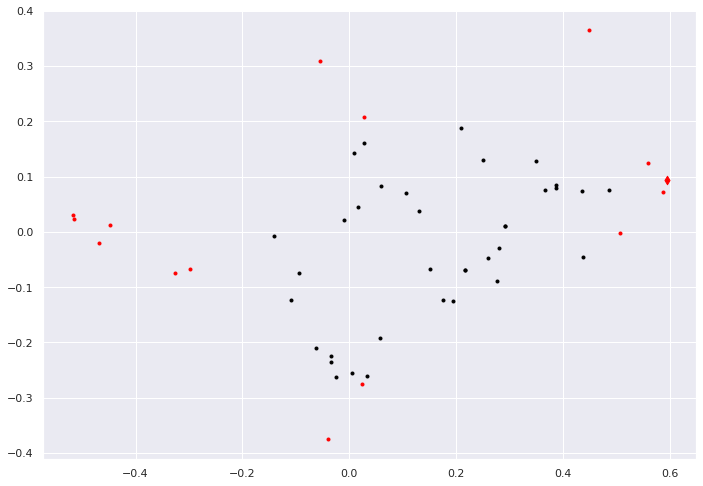

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.04882600349904066
fowlkes_mallows_score: 0.7104005841959085
homogeneity_completeness_v_measure: 0.015168234049677185 0.009500211815283316 0.011683057548461951


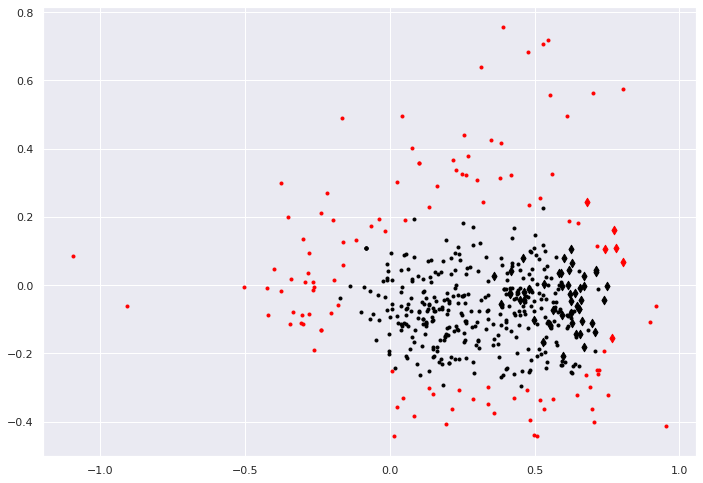

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.09696150419367723
fowlkes_mallows_score: 0.7529416662666737
homogeneity_completeness_v_measure: 0.28888050924787845 0.07629805923268018 0.12071366782267709


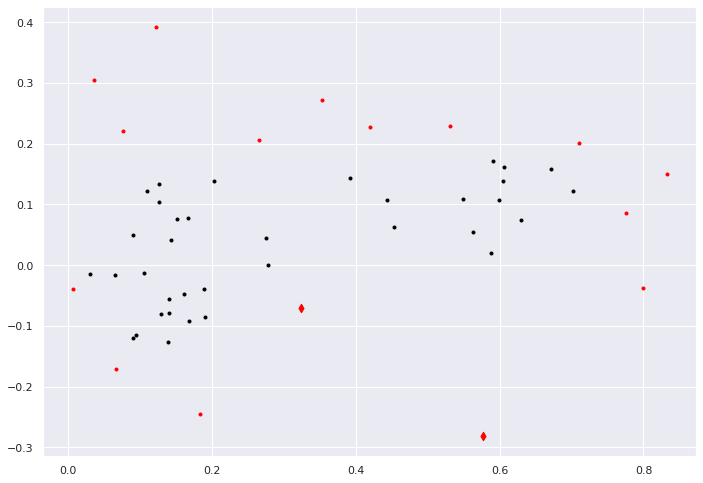

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.02372875628652473
fowlkes_mallows_score: 0.8012931037831442
homogeneity_completeness_v_measure: 0.010420898032865838 0.0027135415173292344 0.004305861601778969


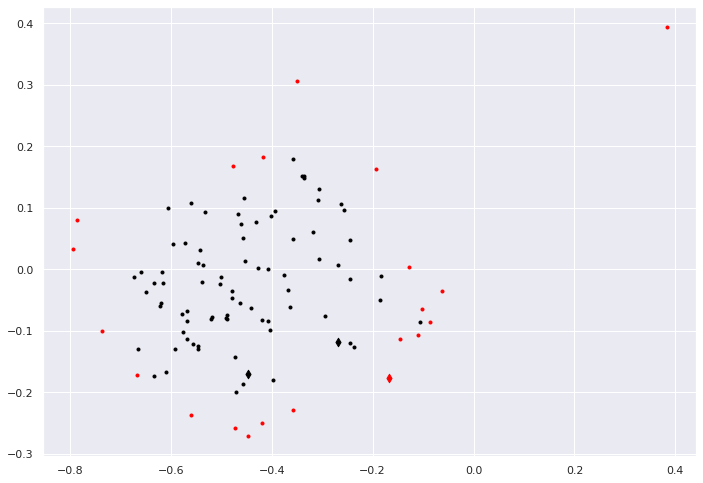

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.04606858330446831
fowlkes_mallows_score: 0.7479575920067657
homogeneity_completeness_v_measure: 0.24000422165857632 0.03723589815953225 0.06446954907824871


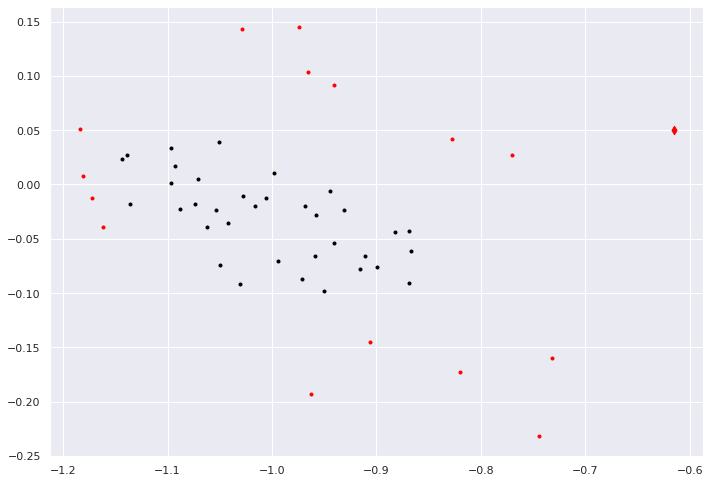

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.14236704953701362
fowlkes_mallows_score: 0.7564898273245104
homogeneity_completeness_v_measure: 0.14742774455400898 0.0658866198057096 0.09107230807826015


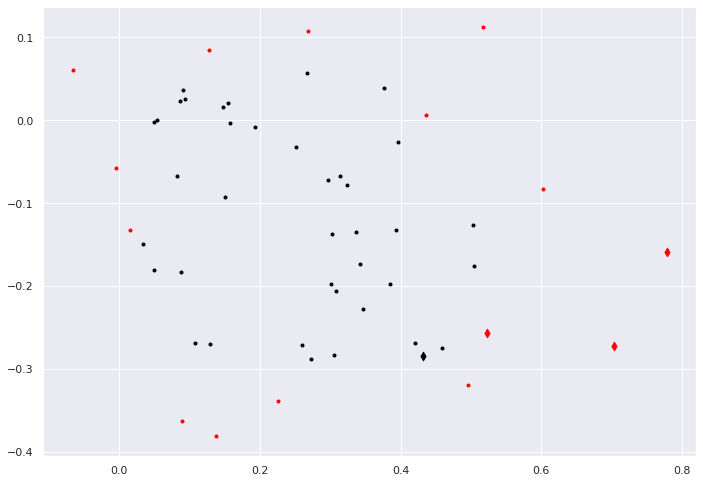

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.04680084026990072
fowlkes_mallows_score: 0.7509822139600585
homogeneity_completeness_v_measure: 0.2400042216585749 0.03723589815953174 0.0644695490782479


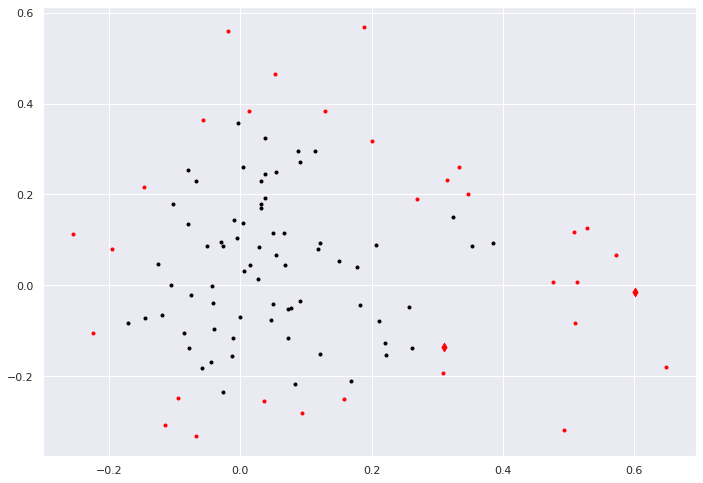

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.13434190297232662
fowlkes_mallows_score: 0.754218741095829
homogeneity_completeness_v_measure: 0.08890556453433503 0.04774385233393644 0.06212531662516183


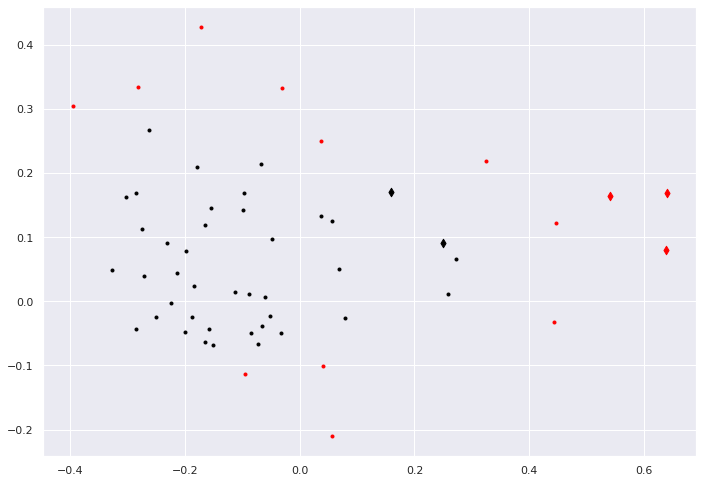

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.01487223468218581
fowlkes_mallows_score: 0.8230951072087648
homogeneity_completeness_v_measure: 0.003888622570811556 0.0010090010140041822 0.0016022562980107125


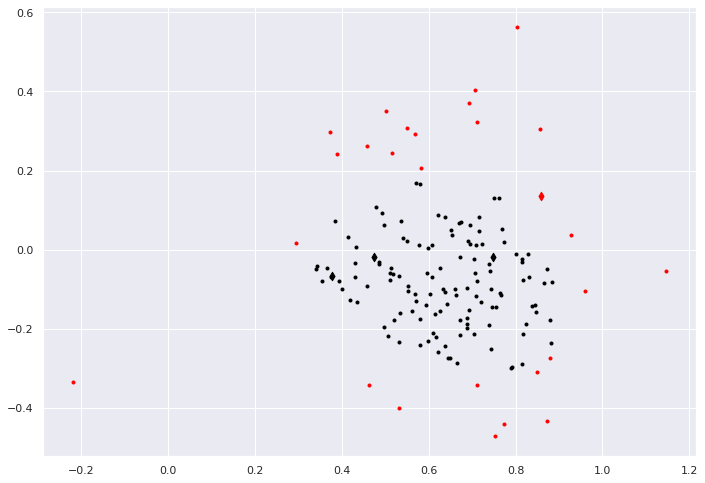

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


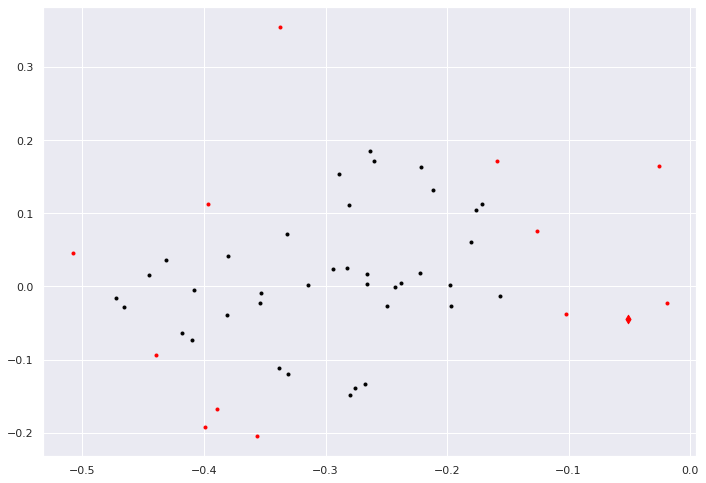

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


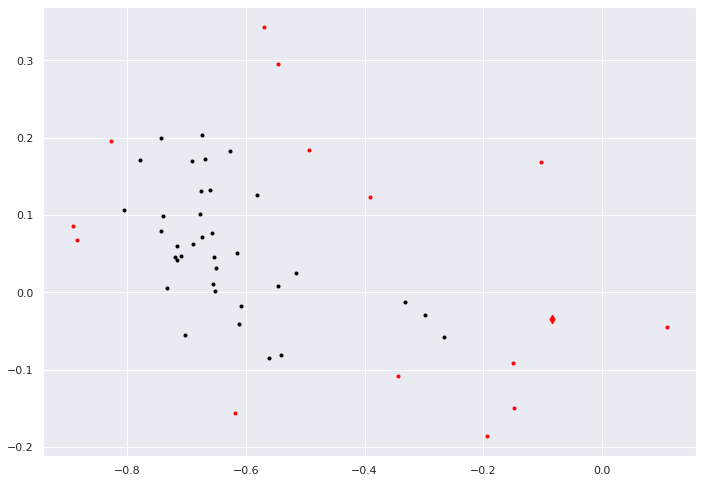

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.13708004371227042
fowlkes_mallows_score: 0.8497841987262109
homogeneity_completeness_v_measure: 0.36214622269948704 0.07500088265183213 0.12426611554323326


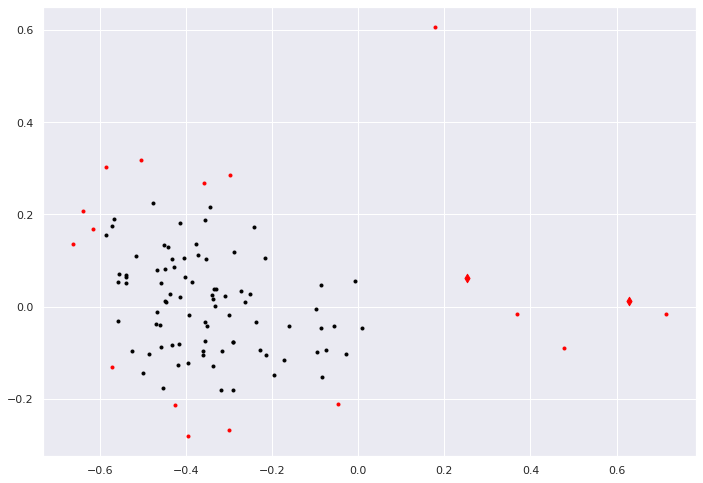

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


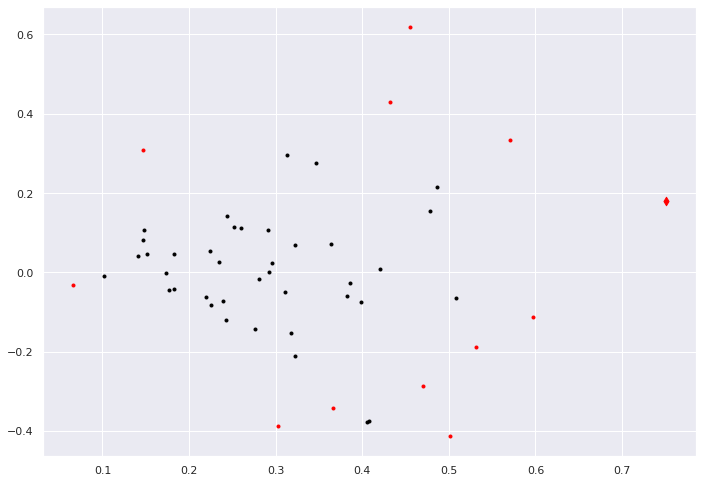

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.38578311662596526
fowlkes_mallows_score: 0.8348210990982834
homogeneity_completeness_v_measure: 0.48304223678623703 0.2690894500871971 0.3456351384583295


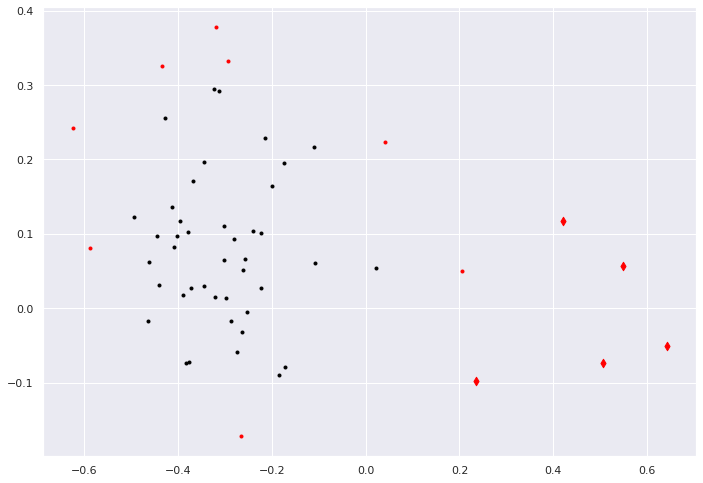

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.11304592376425374
fowlkes_mallows_score: 0.7740582483047485
homogeneity_completeness_v_measure: 0.1288418096569317 0.04597832179452089 0.06777171640143613


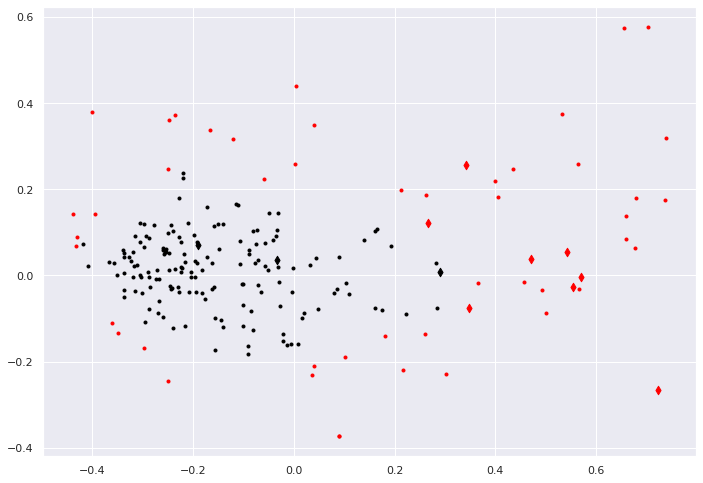

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.025225085377212048
fowlkes_mallows_score: 0.7606403751737113
homogeneity_completeness_v_measure: 0.06047303865436228 0.010281196615568478 0.017574501313579943


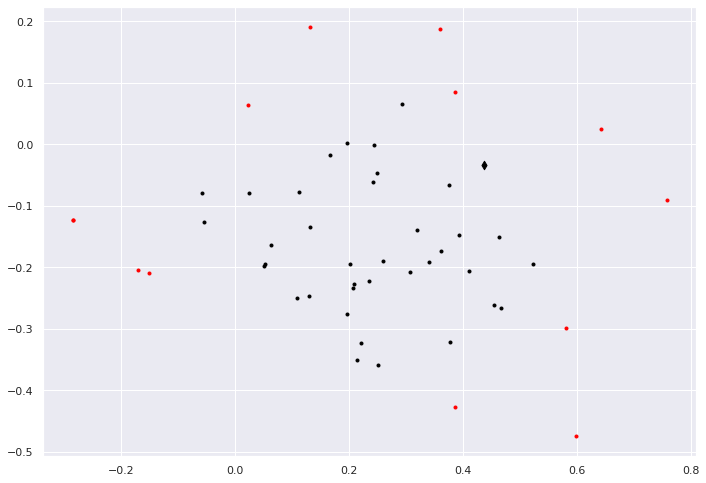

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


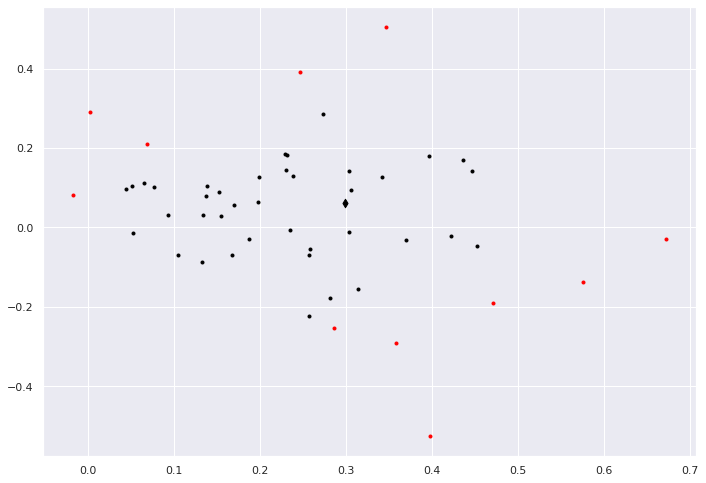

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.070506454816286
fowlkes_mallows_score: 0.7289370647927045
homogeneity_completeness_v_measure: 0.25931245665128994 0.06553780646242785 0.10463140423167659


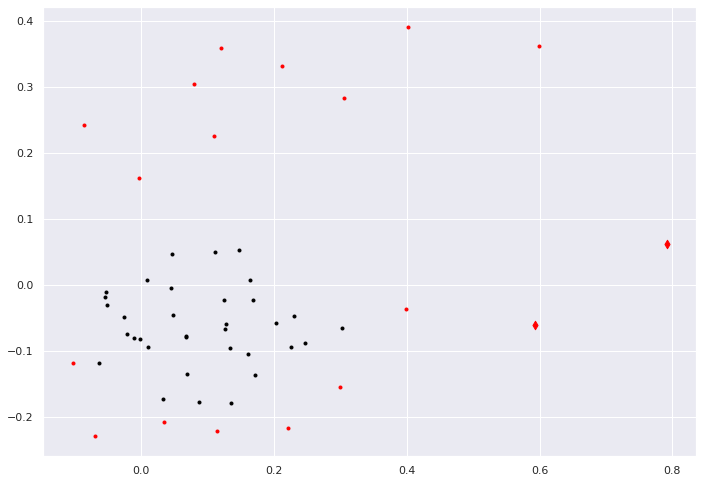

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.1364441819255759
fowlkes_mallows_score: 0.8480813153836058
homogeneity_completeness_v_measure: 0.3621462226994919 0.07500088265183384 0.12426611554323588


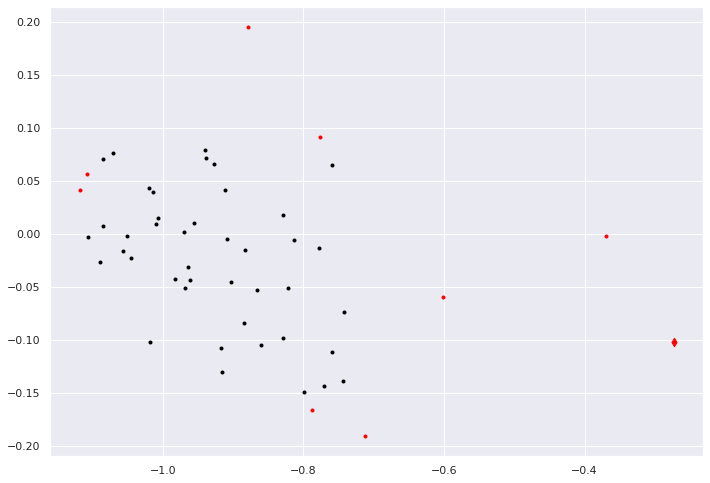

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.07038674973824378
fowlkes_mallows_score: 0.7442344950234472
homogeneity_completeness_v_measure: 0.03808245714960523 0.01737757850957408 0.023865144733105585


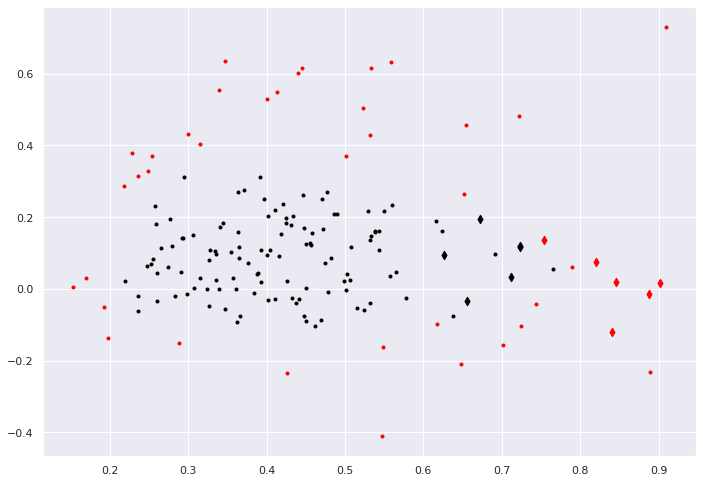

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.06059376782764756
fowlkes_mallows_score: 0.7940162847869536
homogeneity_completeness_v_measure: 0.08232415604556122 0.01867521494028332 0.03044417591756598


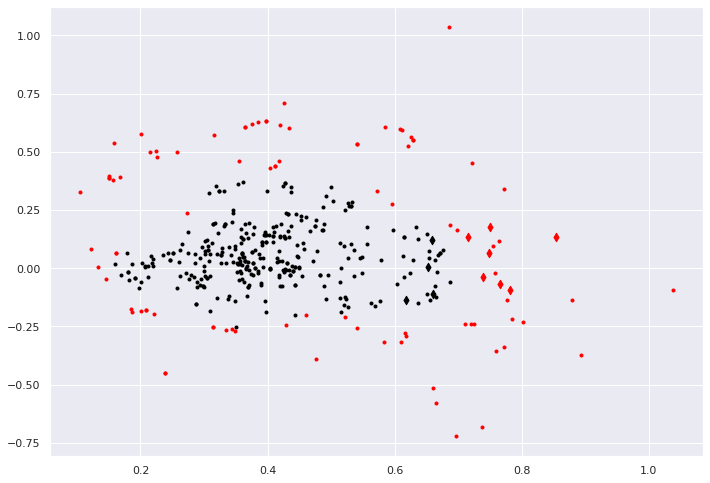

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.08023958627636445
fowlkes_mallows_score: 0.7956983826217061
homogeneity_completeness_v_measure: 0.2920260886363456 0.05060849648510717 0.08626683891279346


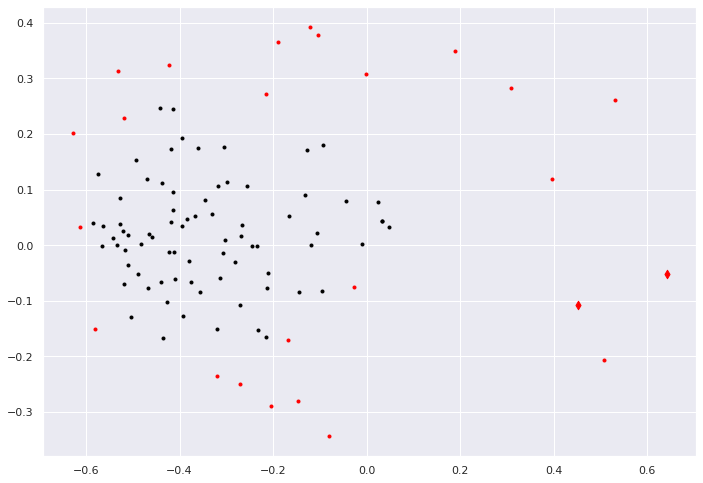

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.0793861601228408
fowlkes_mallows_score: 0.6879865893750301
homogeneity_completeness_v_measure: 0.09655966004798348 0.05099553226412813 0.06674263619235588


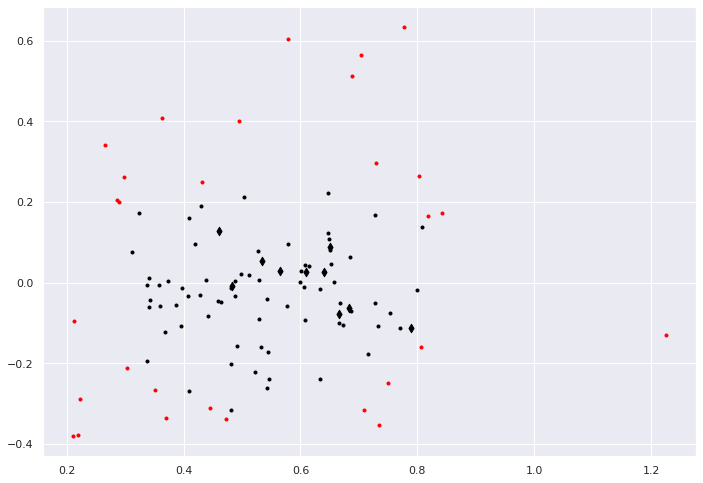

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.024203536043730784
fowlkes_mallows_score: 0.7070800697773397
homogeneity_completeness_v_measure: 0.0026982932588702903 0.0014490309530108968 0.001885509910801112


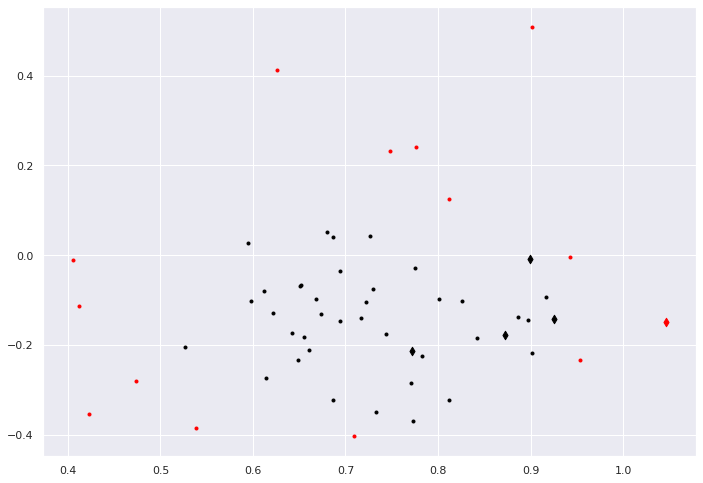

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


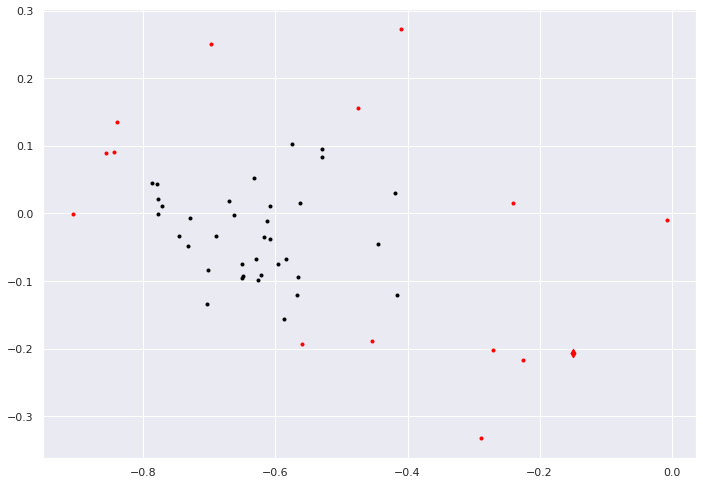

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.2100919119257695
fowlkes_mallows_score: 0.769968145802792
homogeneity_completeness_v_measure: 0.3689963040399926 0.16033451633750725 0.22353825494758517


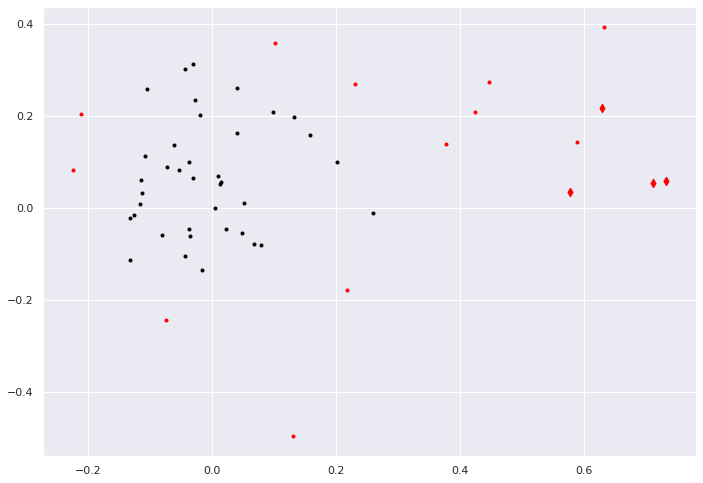

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.03581035274564262
fowlkes_mallows_score: 0.754080046578137
homogeneity_completeness_v_measure: 0.029544615604291842 0.008268728928824626 0.012921174826218271


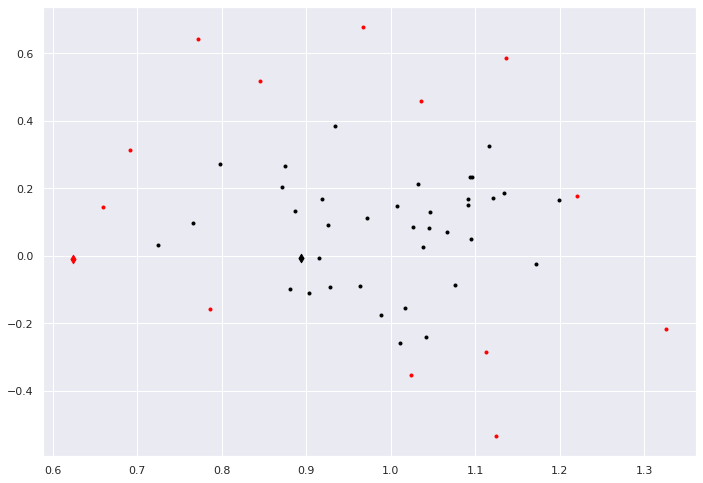

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.12122421574743404
fowlkes_mallows_score: 0.8117493349182685
homogeneity_completeness_v_measure: 0.05585511714572471 0.029261402558156825 0.03840380394828397


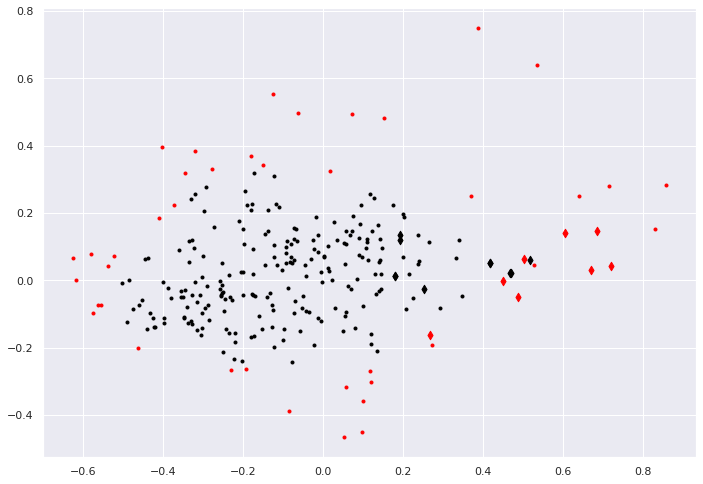

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.12098542150855694
fowlkes_mallows_score: 0.8003026382300061
homogeneity_completeness_v_measure: 0.32372684896302184 0.07692640594417868 0.12431269529622226


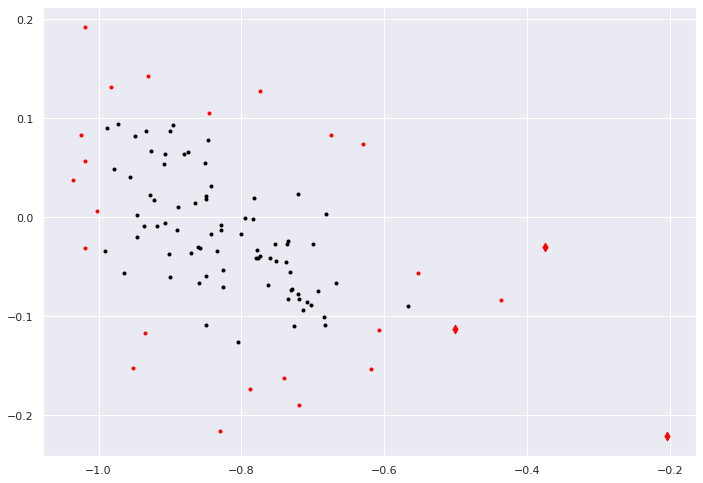

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.10498570407433881
fowlkes_mallows_score: 0.7741704957902397
homogeneity_completeness_v_measure: 0.05690690909825109 0.028367397129162614 0.03786136671644444


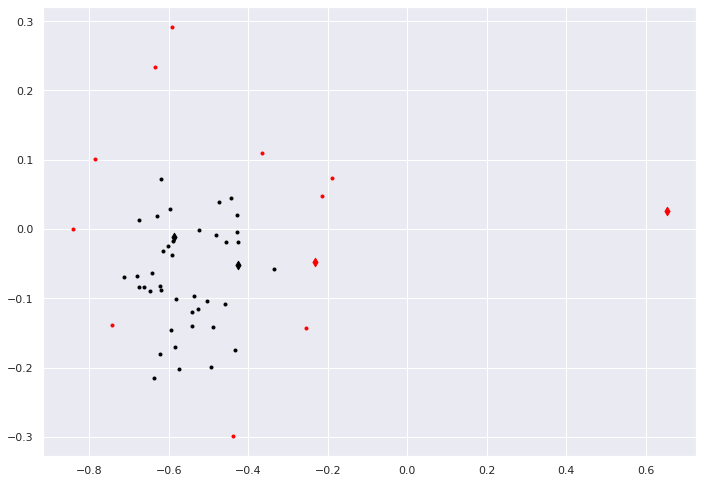

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.05006027918781726
fowlkes_mallows_score: 0.7659779565197902
homogeneity_completeness_v_measure: 0.077300130161576 0.017398796993471667 0.028404319091137862


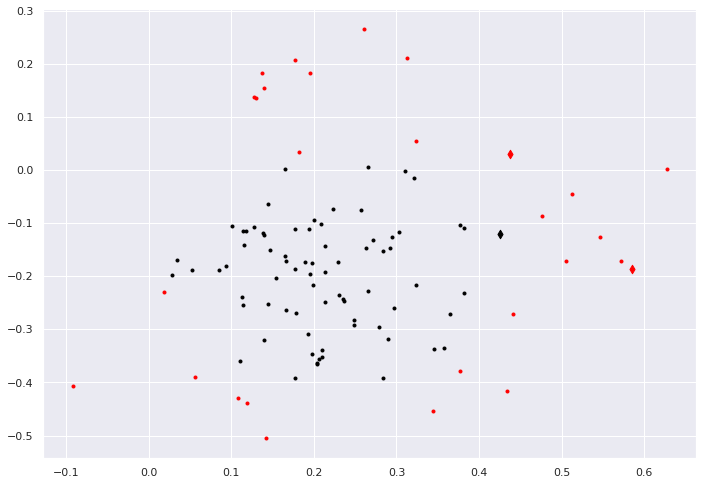

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


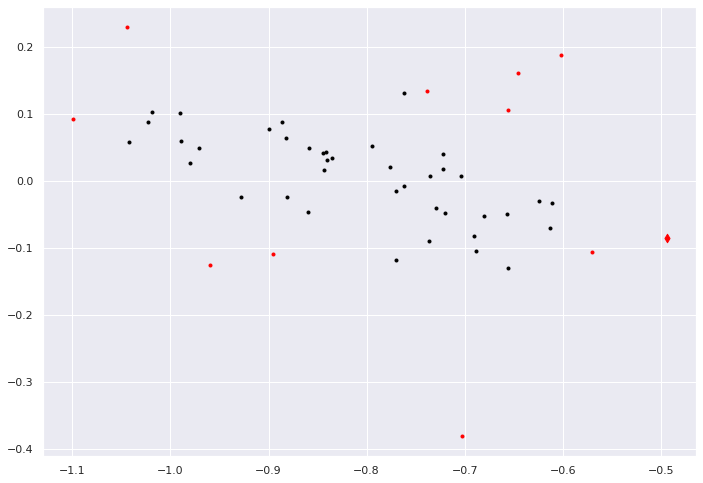

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.10580128146444269
fowlkes_mallows_score: 0.7624102503476757
homogeneity_completeness_v_measure: 0.2968910662370311 0.07944548305504825 0.12534872956824278


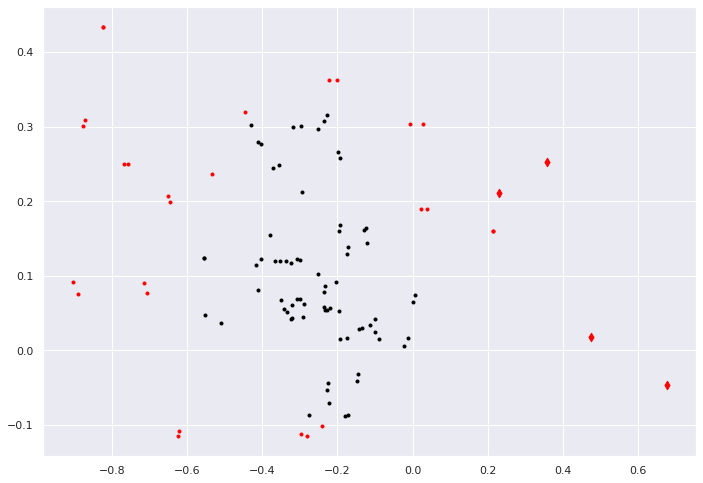

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.06328078524687686
fowlkes_mallows_score: 0.7726039985050023
homogeneity_completeness_v_measure: 0.2680836160455999 0.04402378816165864 0.07562817263101922


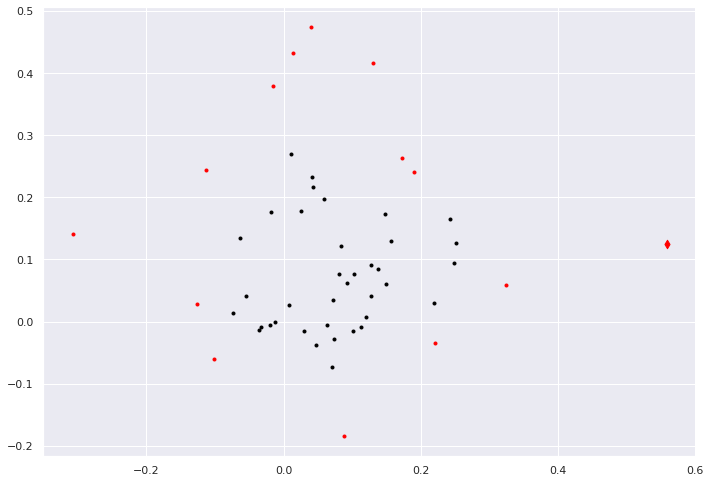

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.29607682876992236
fowlkes_mallows_score: 0.8410424841027447
homogeneity_completeness_v_measure: 0.4409083931315069 0.18779692915150345 0.2634023900626311


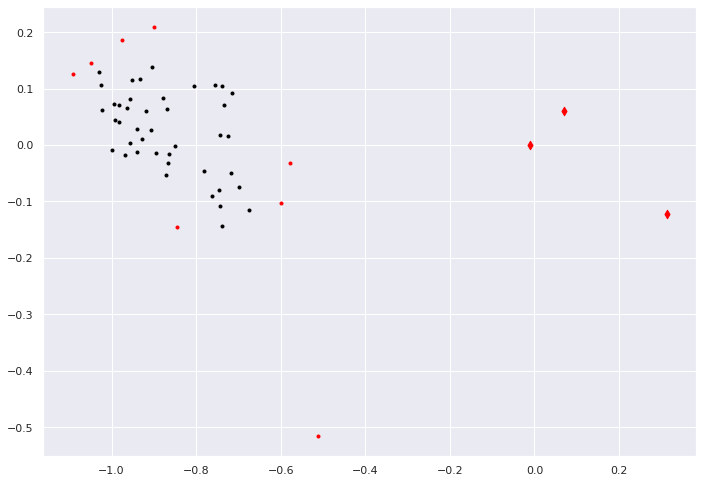

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.011085078575754678
fowlkes_mallows_score: 0.789358552311356
homogeneity_completeness_v_measure: 0.0006406231897509887 0.0003229756711651648 0.0004294436472809363


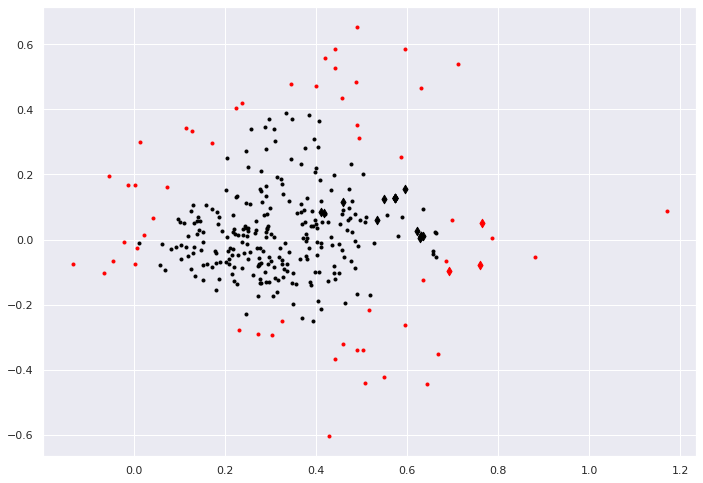

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.3388125619064266
fowlkes_mallows_score: 0.8812978148751368
homogeneity_completeness_v_measure: 0.48193642528585223 0.20035341199468845 0.2830398516718391


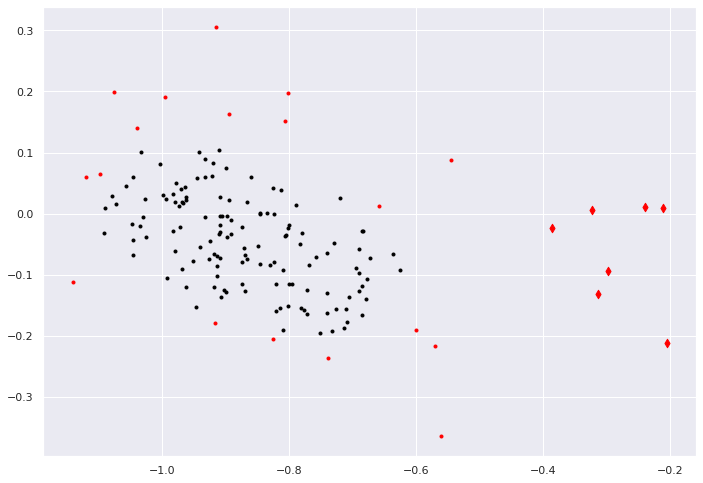

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.025225085377212048
fowlkes_mallows_score: 0.7606403751737113
homogeneity_completeness_v_measure: 0.06047303865436228 0.010281196615568478 0.017574501313579943


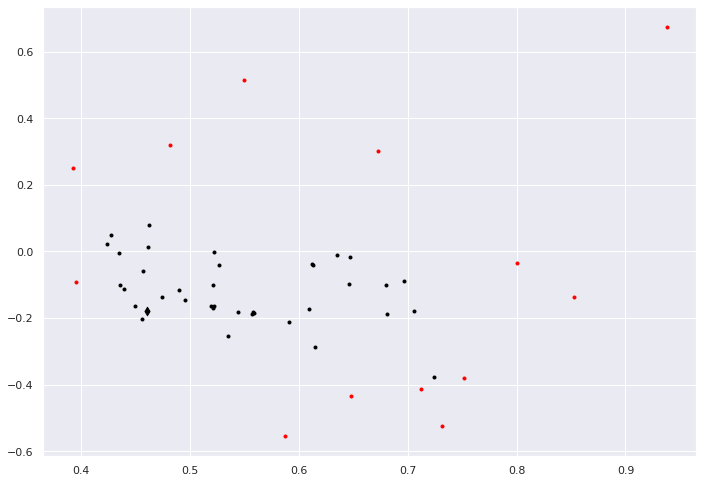

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


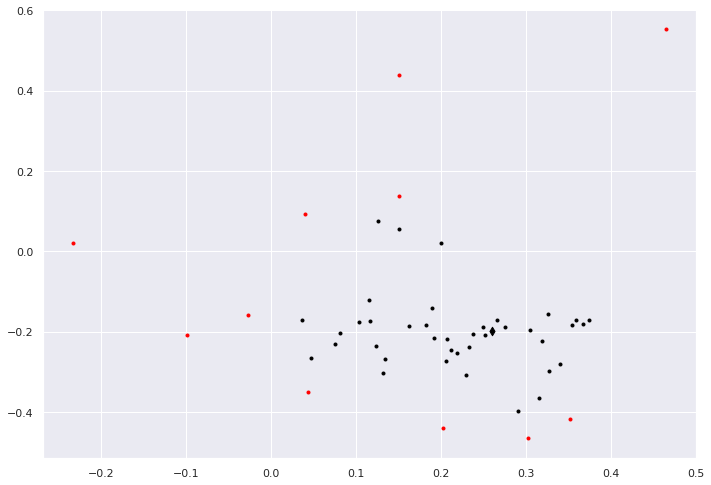

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


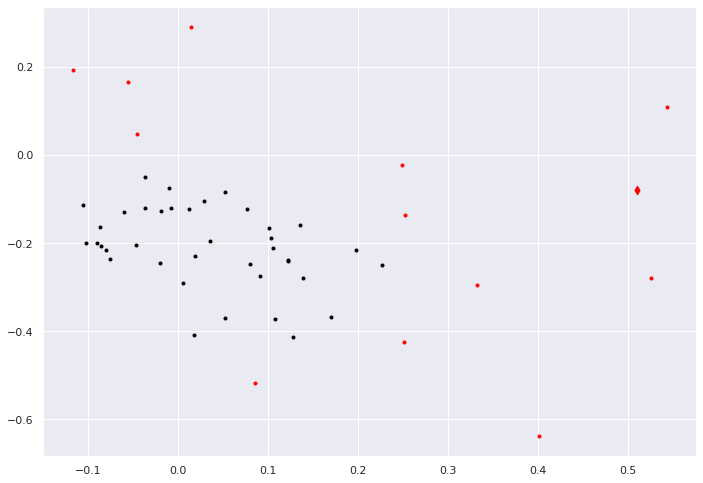

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.05070743824991941
fowlkes_mallows_score: 0.7567297662975718
homogeneity_completeness_v_measure: 0.24666855967775259 0.0387620393197061 0.06699615558211014


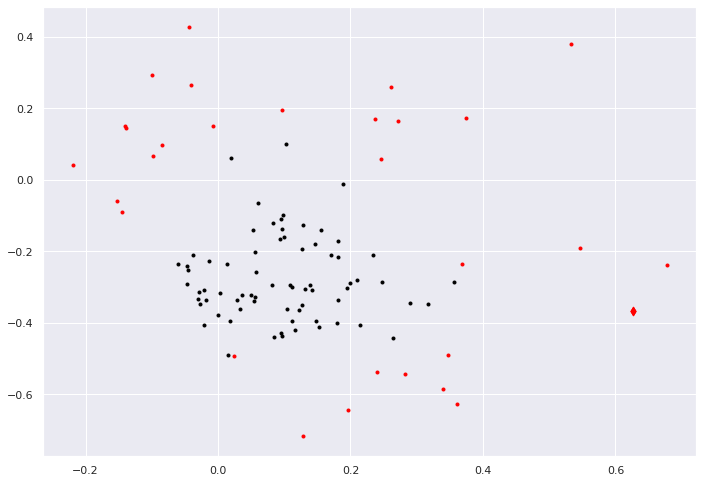

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.20280369145784508
fowlkes_mallows_score: 0.8437679845974804
homogeneity_completeness_v_measure: 0.3935827635514321 0.11847824861351697 0.18213062663329851


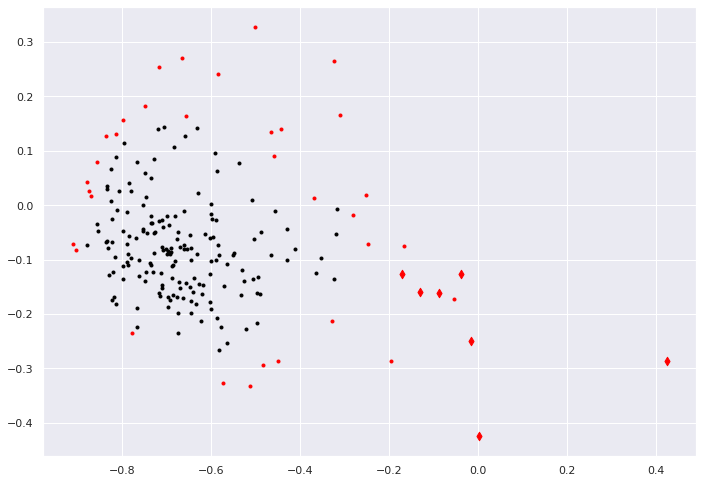

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.12785810967126673
fowlkes_mallows_score: 0.8311188714658863
homogeneity_completeness_v_measure: 0.11877847476360277 0.040726967988748385 0.06065607613102346


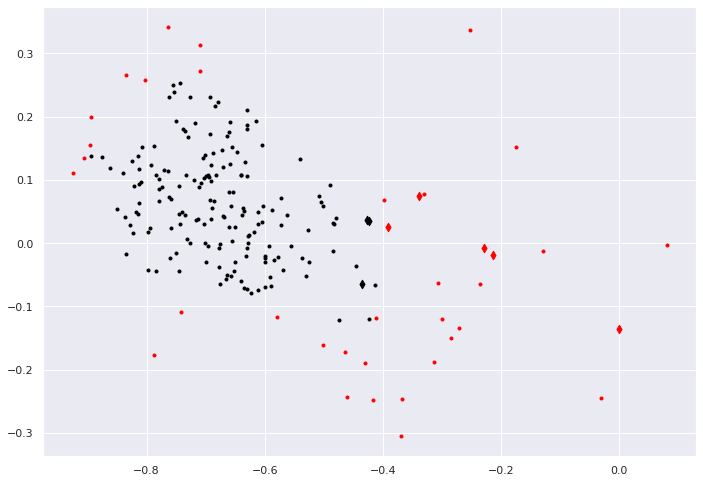

In [50]:
from sklearn.ensemble import IsolationForest


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, IsolationForest, params=None)

# one class svm 

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

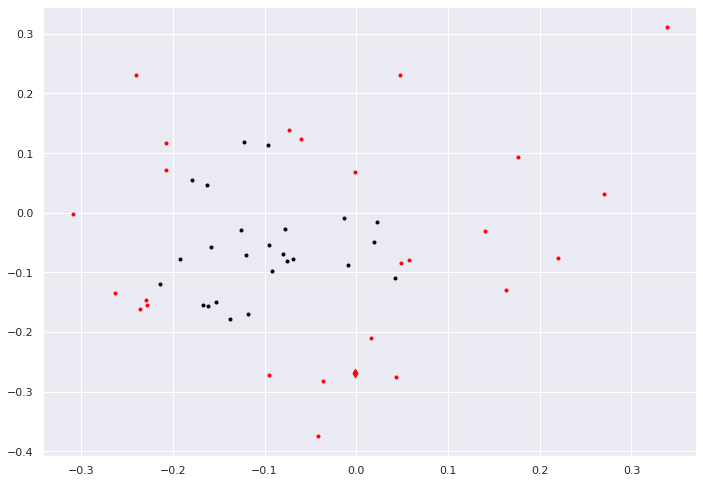

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


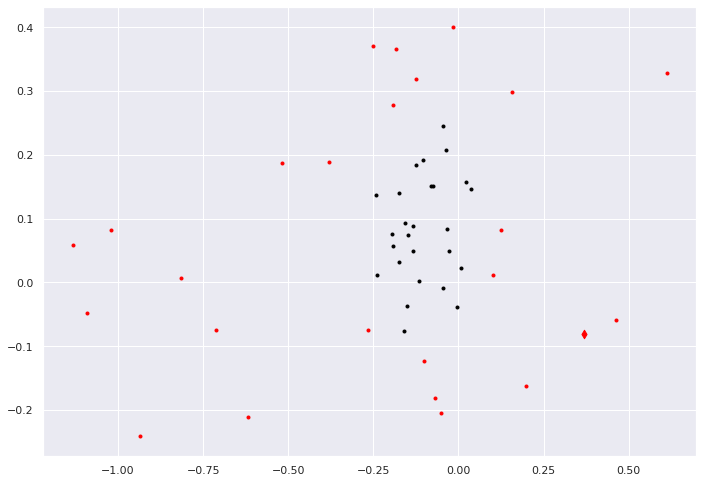

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


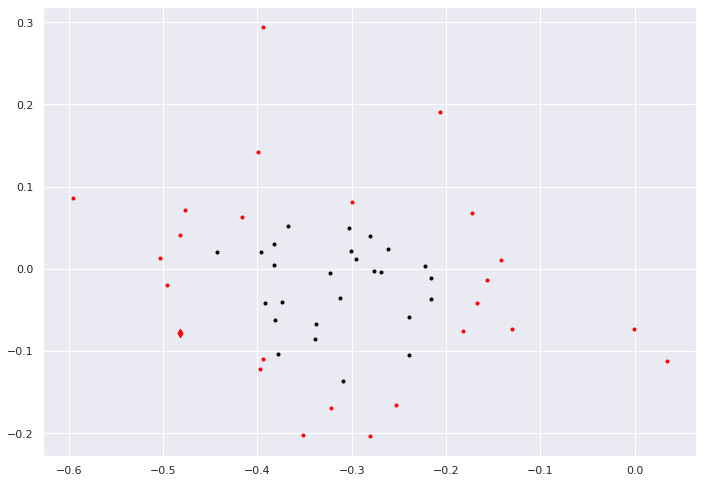

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.005203319717980071
fowlkes_mallows_score: 0.6475881732368012
homogeneity_completeness_v_measure: 0.0 0.0 0.0


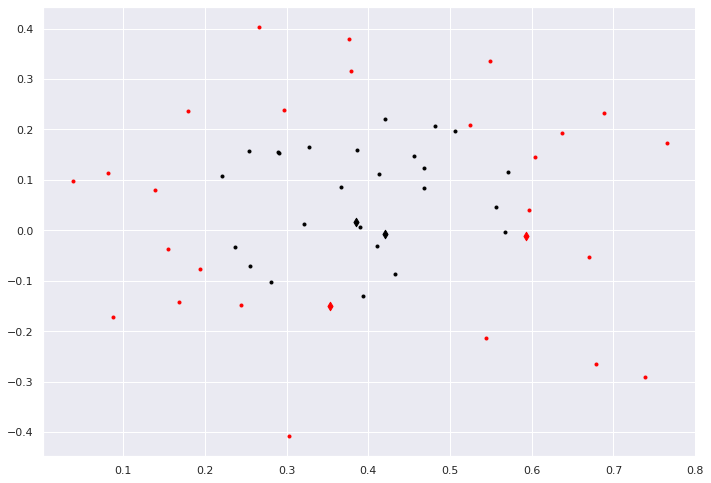

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.00340642743958801
fowlkes_mallows_score: 0.6879162727700022
homogeneity_completeness_v_measure: 0.15523438183024274 0.026980118808811848 0.04597045844654071


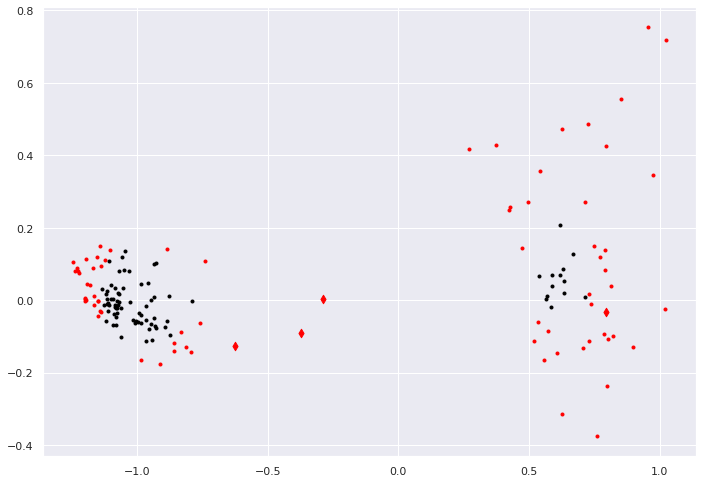

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


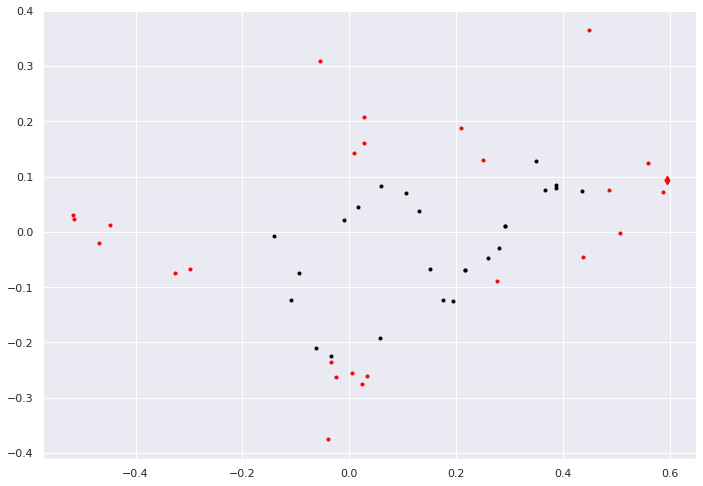

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.0040912300130731384
fowlkes_mallows_score: 0.6378019122470585
homogeneity_completeness_v_measure: 0.01850567096165278 0.008989779582641024 0.012101049423150082


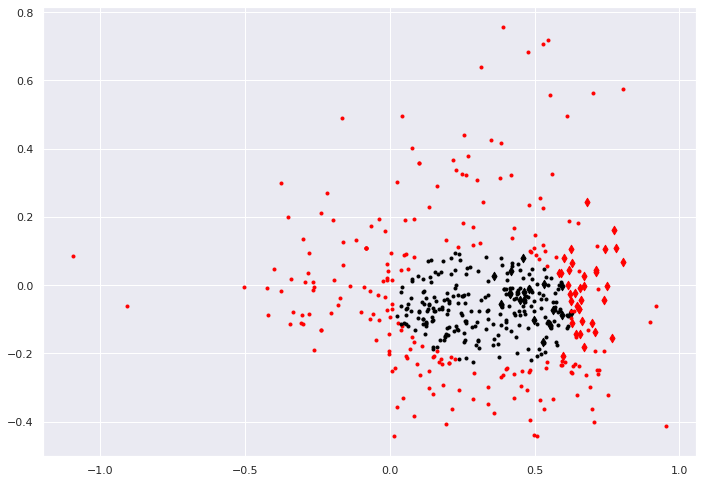

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.0091950932616367
fowlkes_mallows_score: 0.6772042036654343
homogeneity_completeness_v_measure: 0.17788766669657974 0.041882705225973815 0.06780183008667459


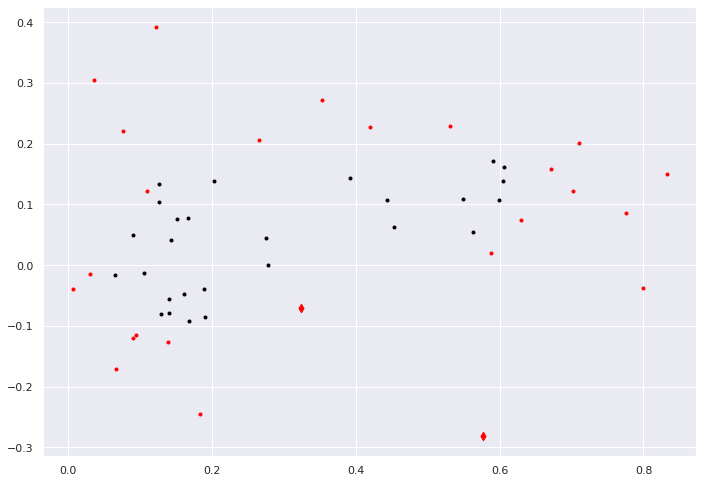

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.0017694075008898812
fowlkes_mallows_score: 0.6828875858648081
homogeneity_completeness_v_measure: 0.010778707465936704 0.0020491088950688858 0.0034435705538997754


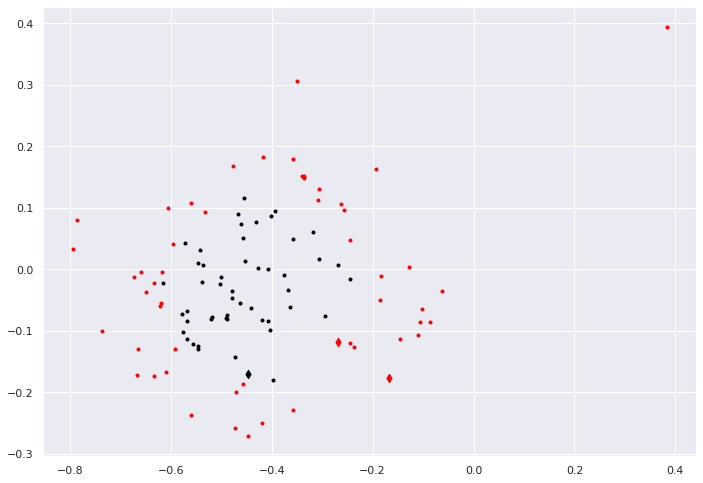

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


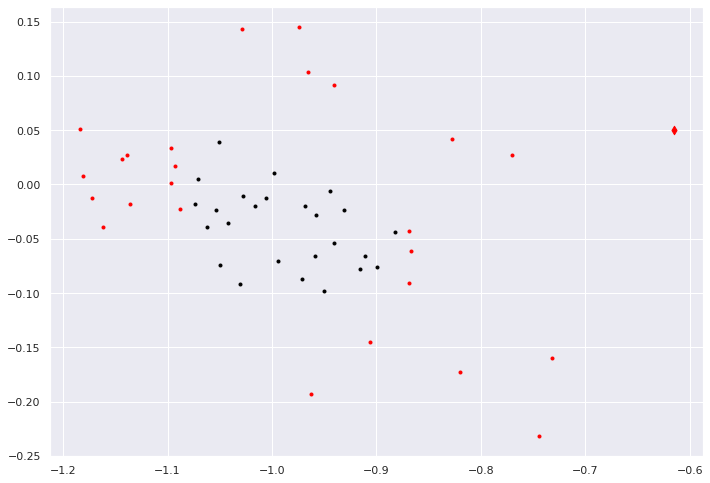

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.01685875588625543
fowlkes_mallows_score: 0.6561939961369581
homogeneity_completeness_v_measure: 0.20568053456521845 0.0783532973886795 0.11347766553715974


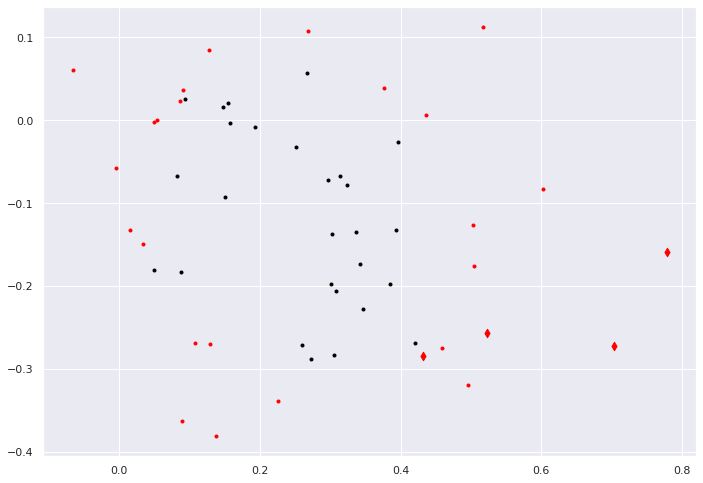

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


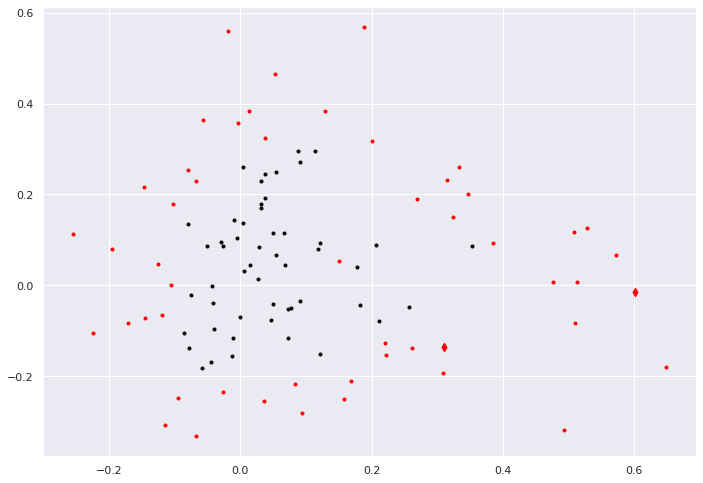

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.02056617469150738
fowlkes_mallows_score: 0.6470995952589369
homogeneity_completeness_v_measure: 0.21586504084499003 0.09489466505068185 0.1318345999079695


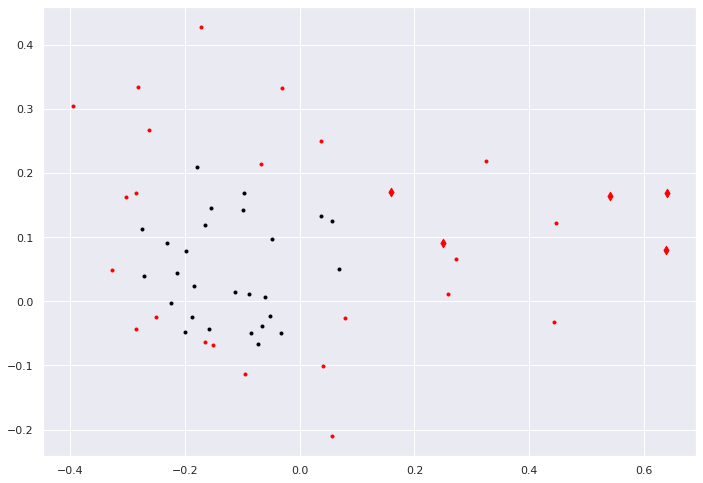

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: -0.000661859361504274
fowlkes_mallows_score: 0.6863679169389767
homogeneity_completeness_v_measure: 0.0 0.0 0.0


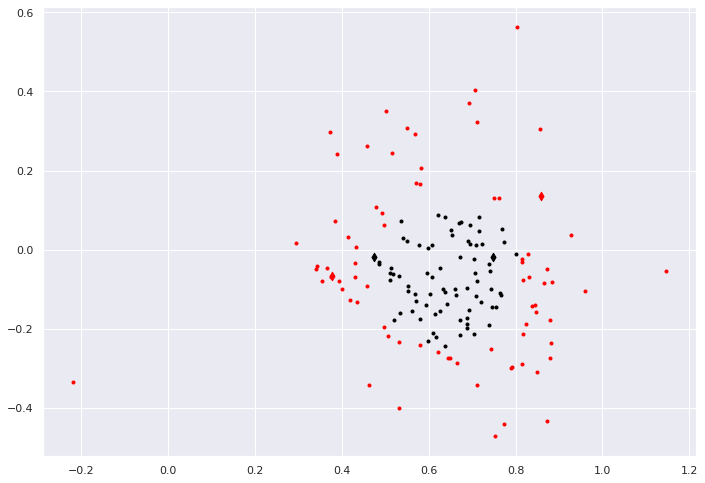

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


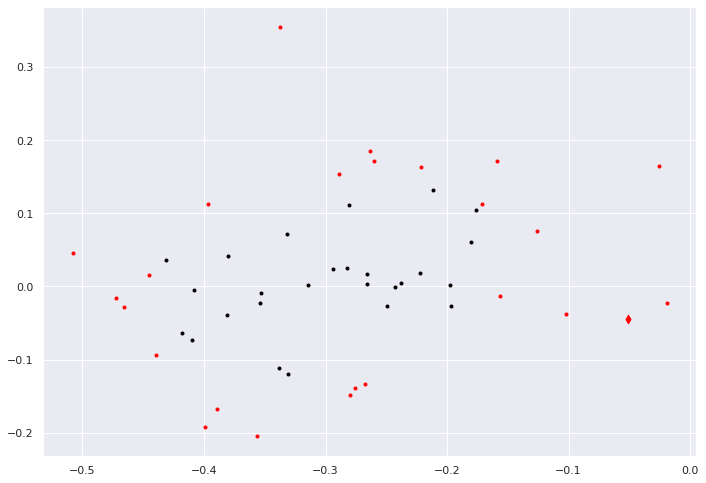

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


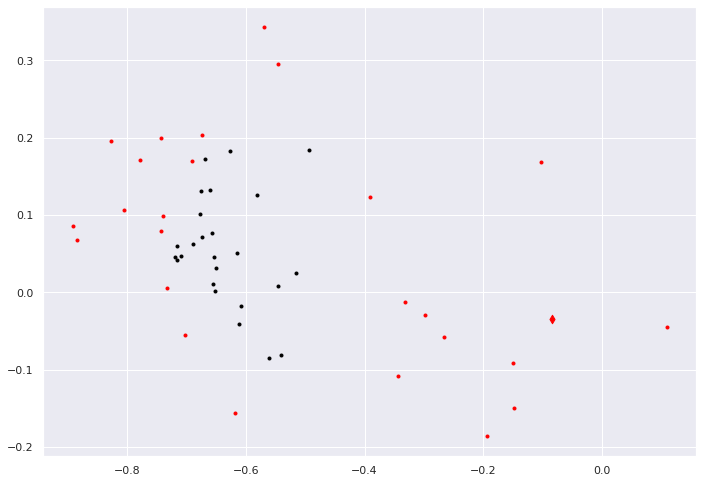

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.002346893026870311
fowlkes_mallows_score: 0.6907959838293899
homogeneity_completeness_v_measure: 0.14696457212882502 0.020467994981116955 0.035931720771617735


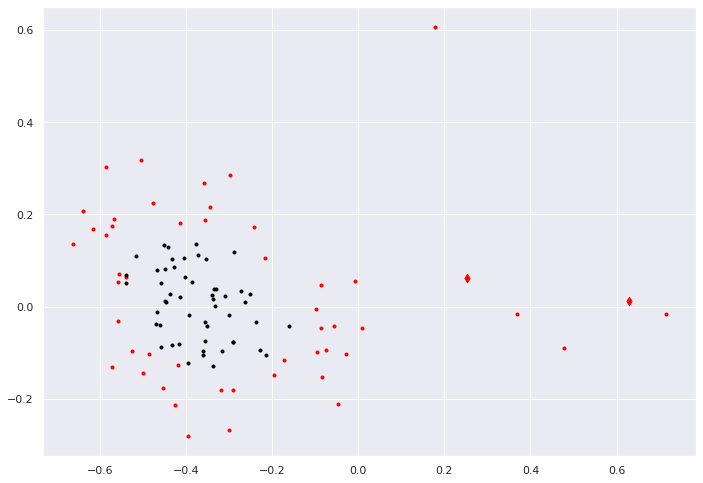

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


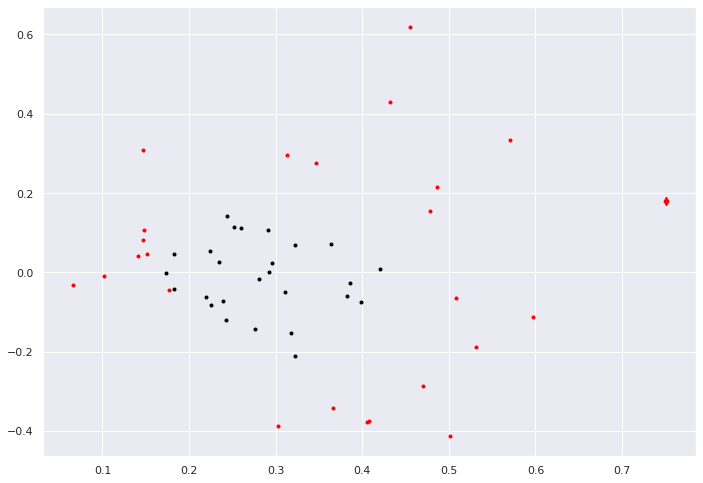

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.02056617469150738
fowlkes_mallows_score: 0.6470995952589369
homogeneity_completeness_v_measure: 0.21586504084499003 0.09489466505068185 0.1318345999079695


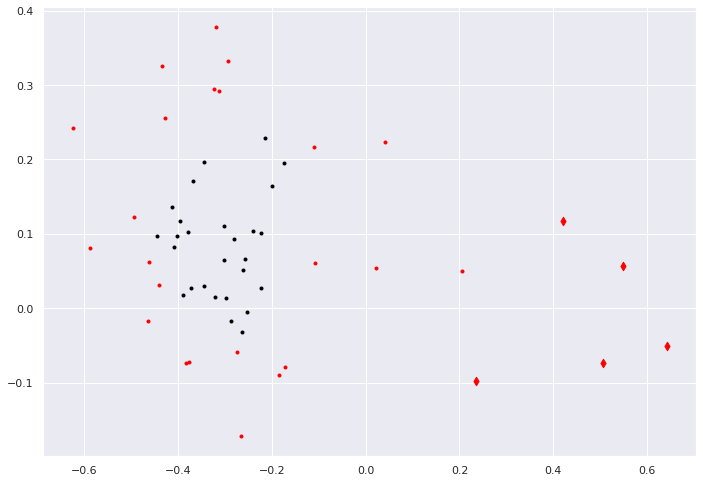

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.0053940294571291885
fowlkes_mallows_score: 0.6715710773569845
homogeneity_completeness_v_measure: 0.06105917919850565 0.01803880108234019 0.027849873888108063


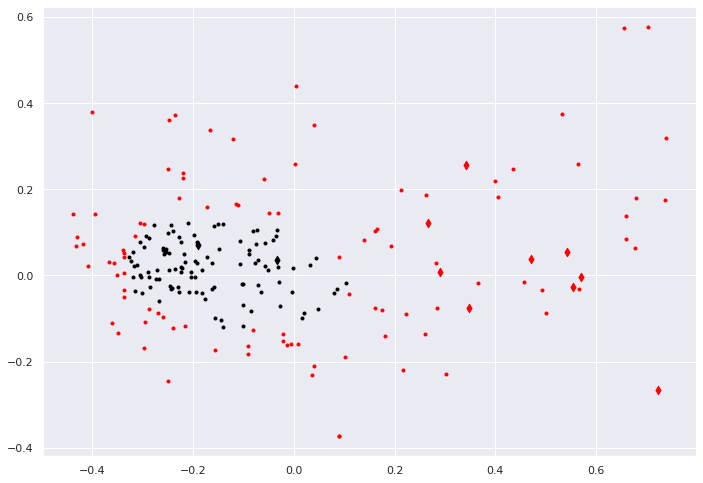

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


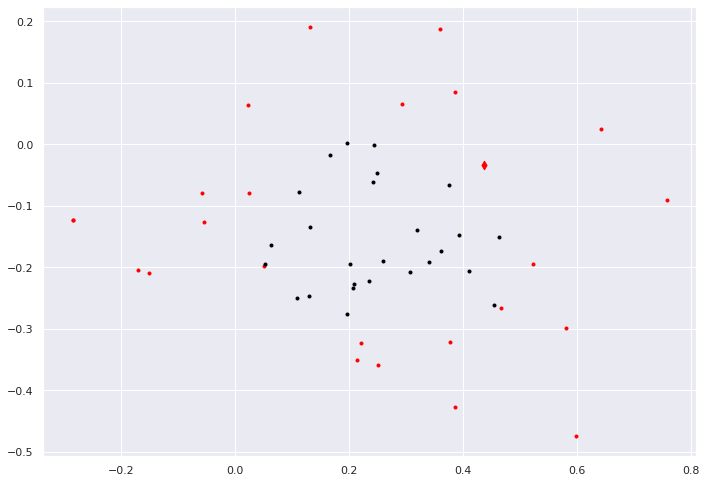

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


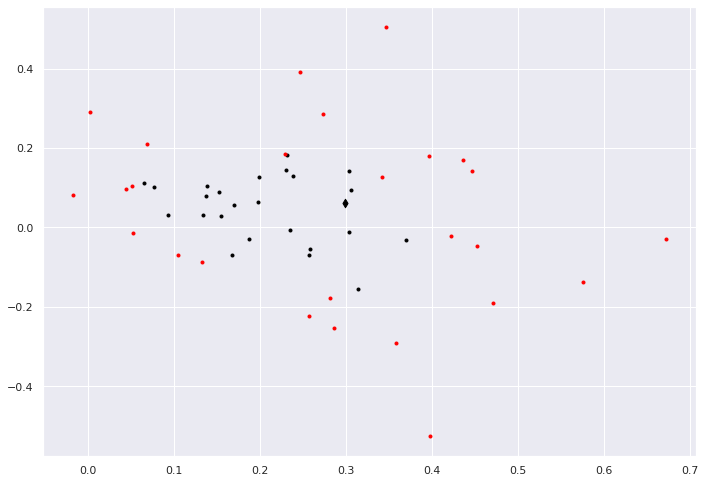

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: -0.0026886237607124854
fowlkes_mallows_score: 0.6727268205007042
homogeneity_completeness_v_measure: 0.15899339002802354 0.03743414825256139 0.06060028227798269


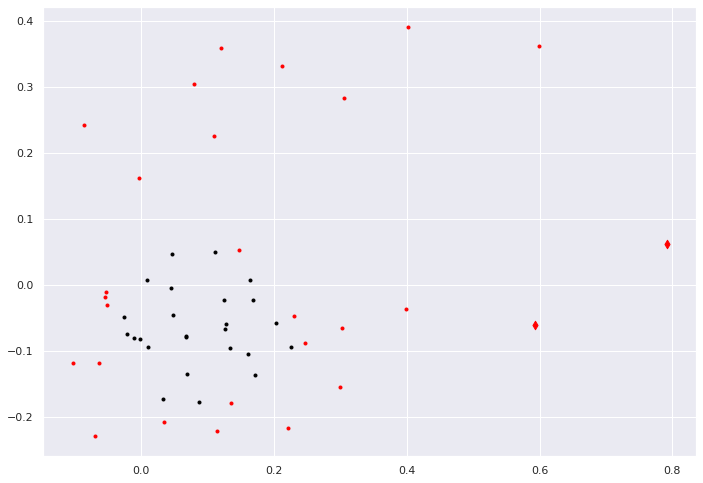

-------------------
Frankia
23 Frankia
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


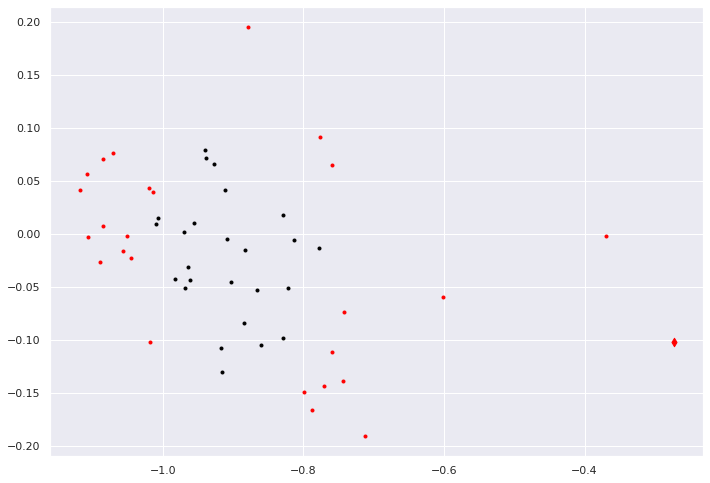

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.023987422072913198
fowlkes_mallows_score: 0.6637070480984305
homogeneity_completeness_v_measure: 0.20945424546817668 0.07979965344862487 0.1155688913048068


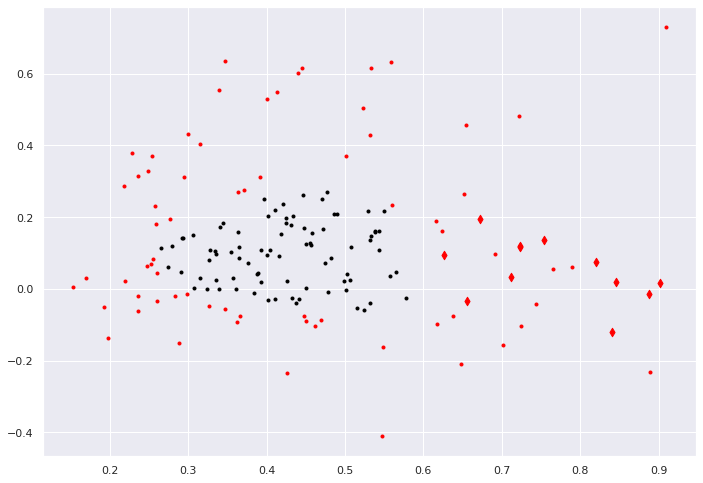

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.003399142118262776
fowlkes_mallows_score: 0.6888127538500617
homogeneity_completeness_v_measure: 0.15506812783764654 0.02758679361751137 0.04684059323702636


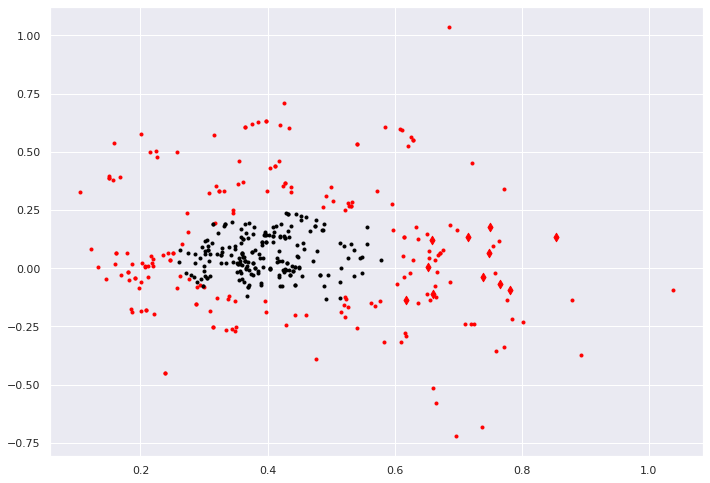

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


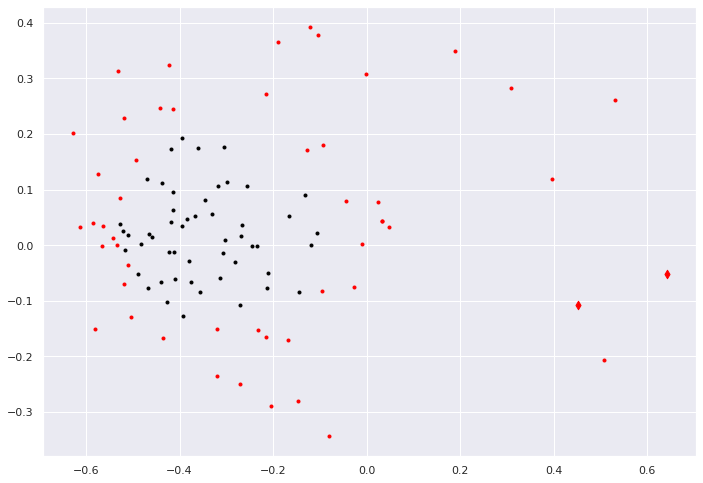

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: 0.018179329226557153
fowlkes_mallows_score: 0.6495929971690442
homogeneity_completeness_v_measure: 0.11939683017492952 0.052474547109861124 0.07290678283680524


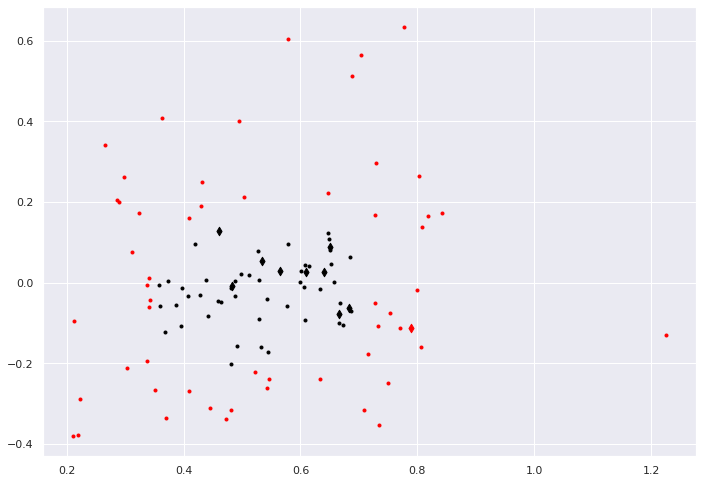

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.0001705657396269099
fowlkes_mallows_score: 0.6398989712956425
homogeneity_completeness_v_measure: 0.0106827829371052 0.004705153929370268 0.006532927519690681


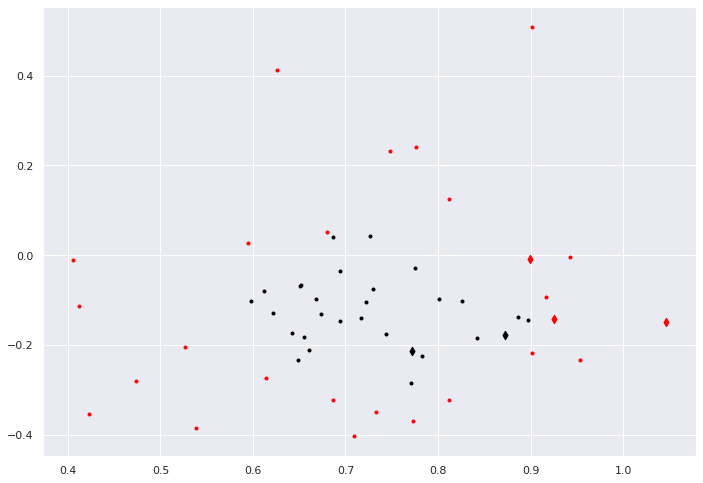

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


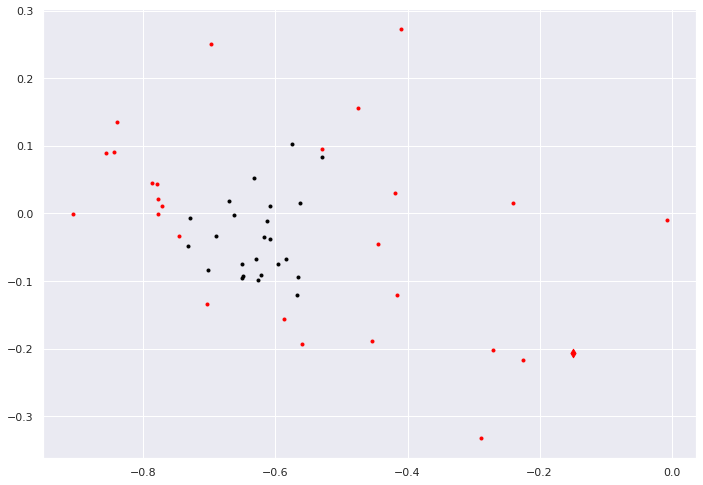

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.01685875588625543
fowlkes_mallows_score: 0.6561939961369581
homogeneity_completeness_v_measure: 0.20568053456521845 0.0783532973886795 0.11347766553715974


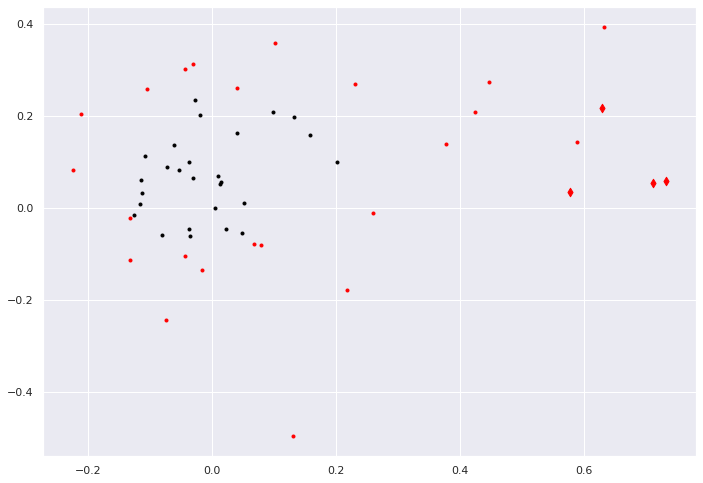

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.0026886237607124854
fowlkes_mallows_score: 0.6727268205007042
homogeneity_completeness_v_measure: 0.00018162147592430526 4.276181075452958e-05 6.922497033880974e-05


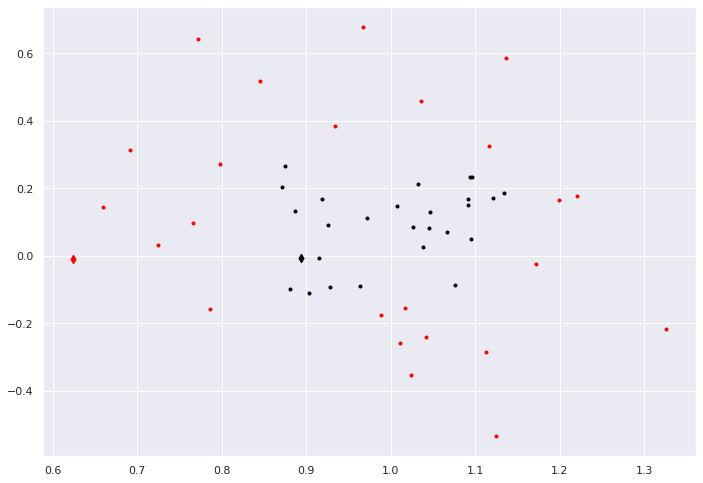

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.011561658017476753
fowlkes_mallows_score: 0.6643158765782217
homogeneity_completeness_v_measure: 0.10156532577246785 0.03608260045978397 0.053248038974917505


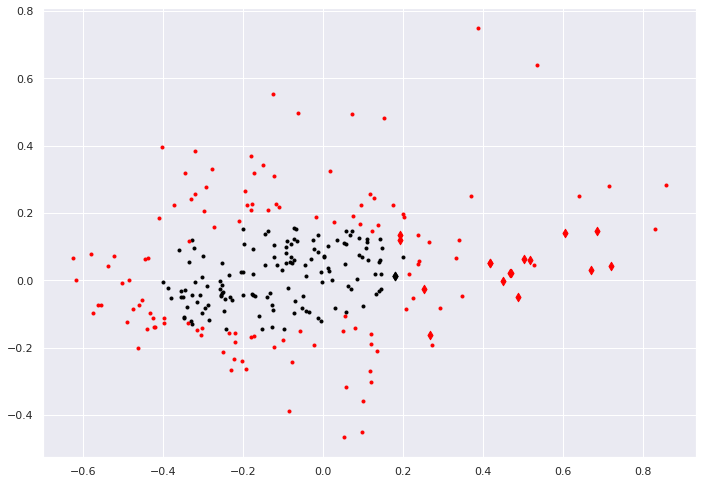

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.0011654499076435923
fowlkes_mallows_score: 0.683707302170224
homogeneity_completeness_v_measure: 0.15441999878924076 0.02934036723786607 0.049311389297938386


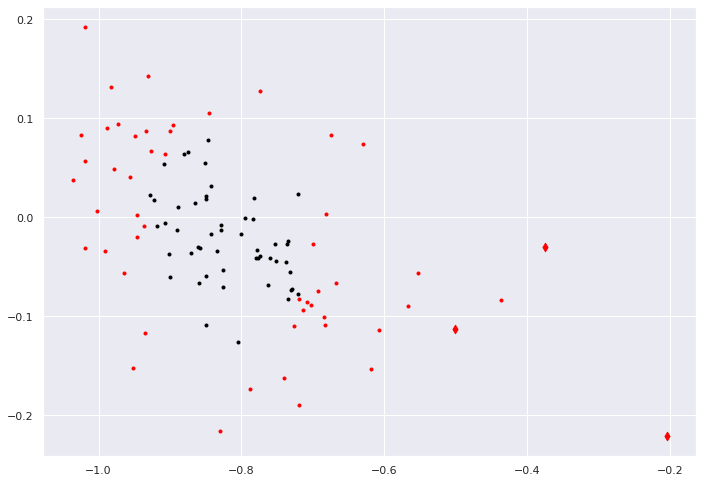

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: -0.0048226797123368005
fowlkes_mallows_score: 0.6482023827903773
homogeneity_completeness_v_measure: 0.00020795312530768855 7.929751613355203e-05 0.0001148137823217512


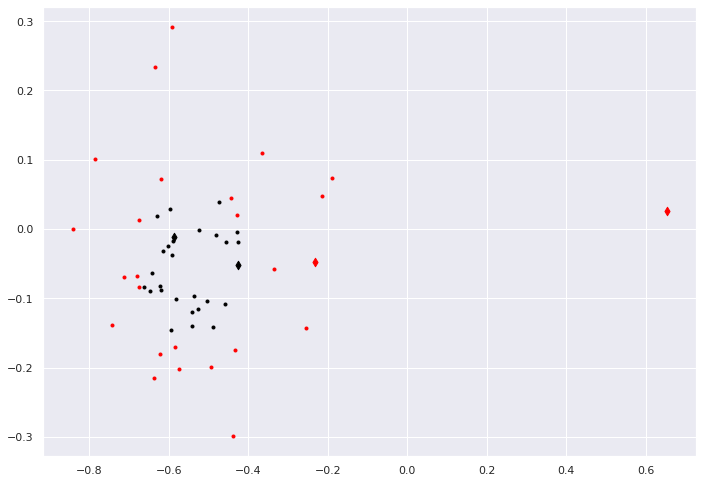

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.0034303808602339694
fowlkes_mallows_score: 0.6845431301679872
homogeneity_completeness_v_measure: 0.1588448730374049 0.030181109605696983 0.050724397317342976


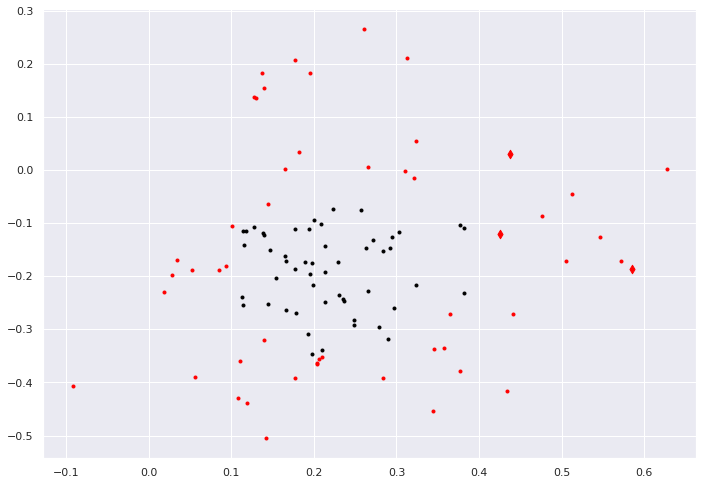

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


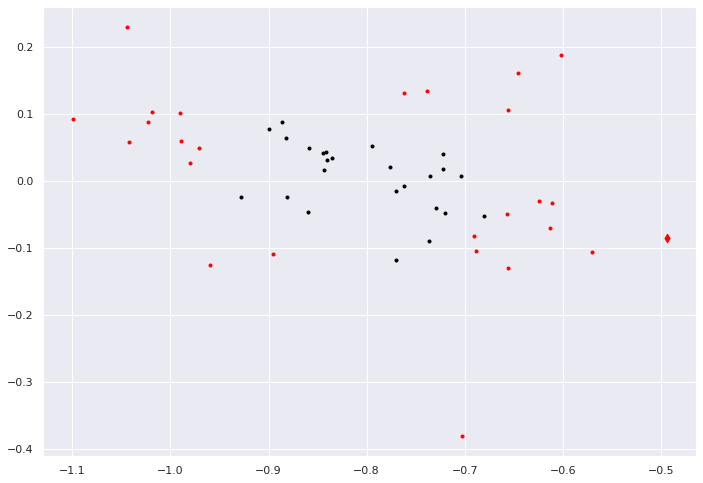

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.0044874007594062825
fowlkes_mallows_score: 0.6785513179854324
homogeneity_completeness_v_measure: 0.16825133300318107 0.039571600004613385 0.0640735298408591


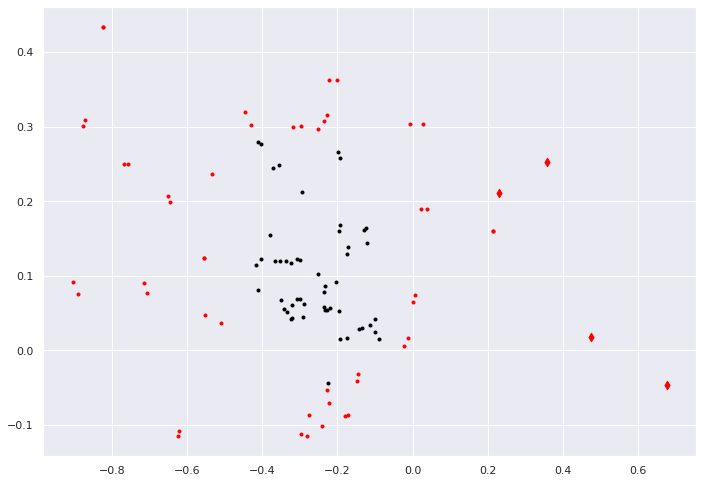

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


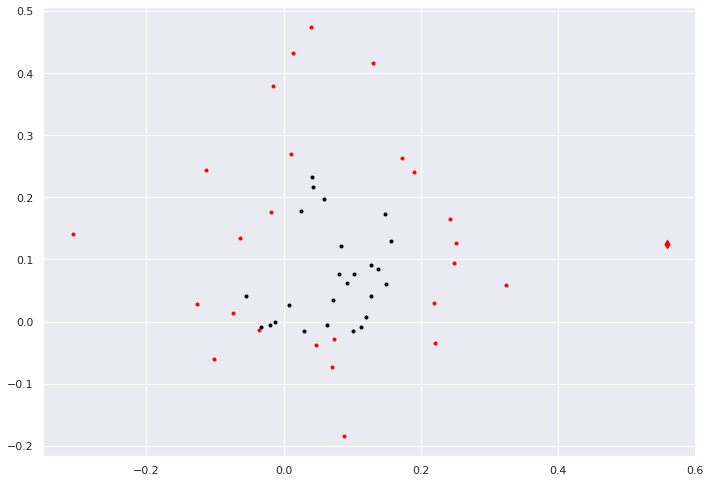

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: -0.003432851347134089
fowlkes_mallows_score: 0.6608505895985824
homogeneity_completeness_v_measure: 0.1730054389688834 0.05441718522336549 0.08279272170442442


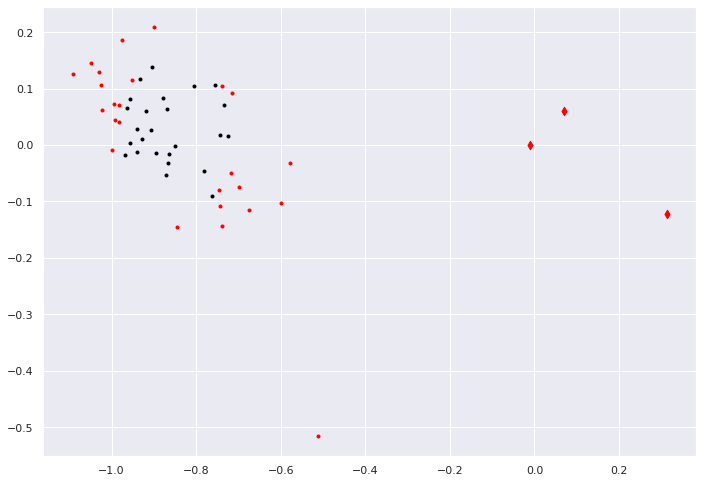

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.006926621244056664
fowlkes_mallows_score: 0.6658212168671197
homogeneity_completeness_v_measure: 0.07666477528523019 0.025858267163133677 0.03867263775995612


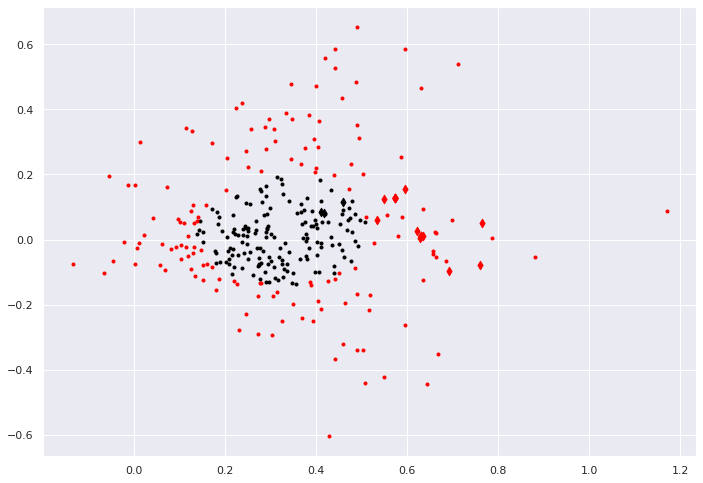

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.008011308134240632
fowlkes_mallows_score: 0.6769438137158869
homogeneity_completeness_v_measure: 0.1769166546221436 0.04651936403254008 0.07366807114931687


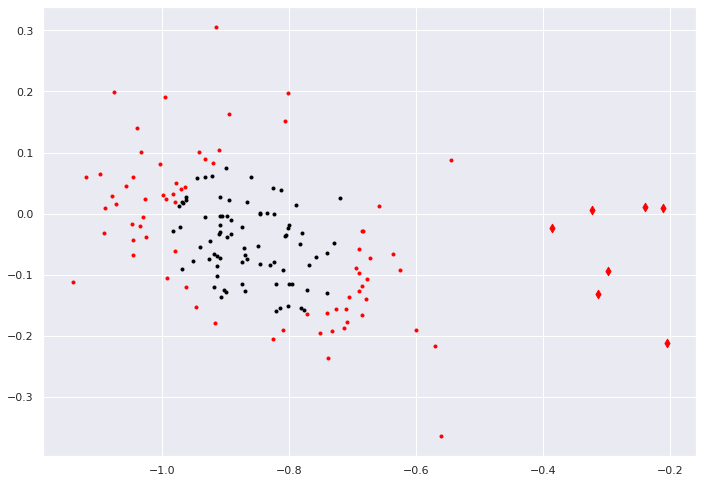

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


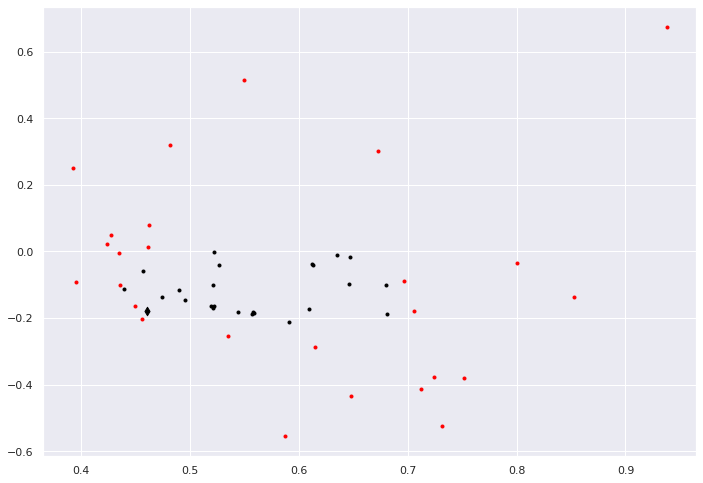

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


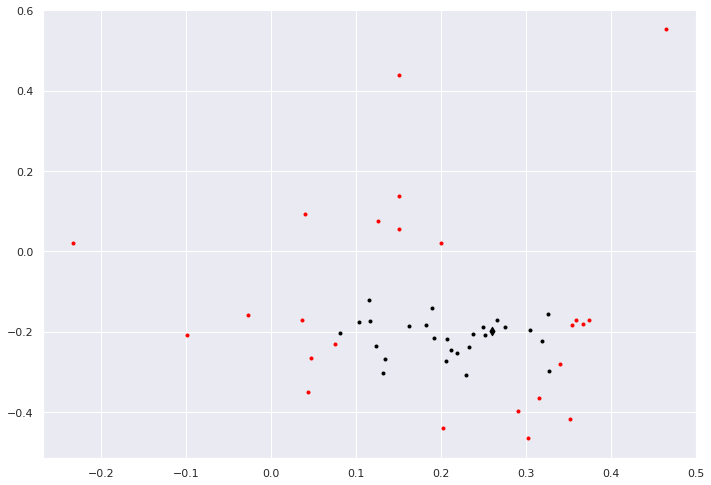

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


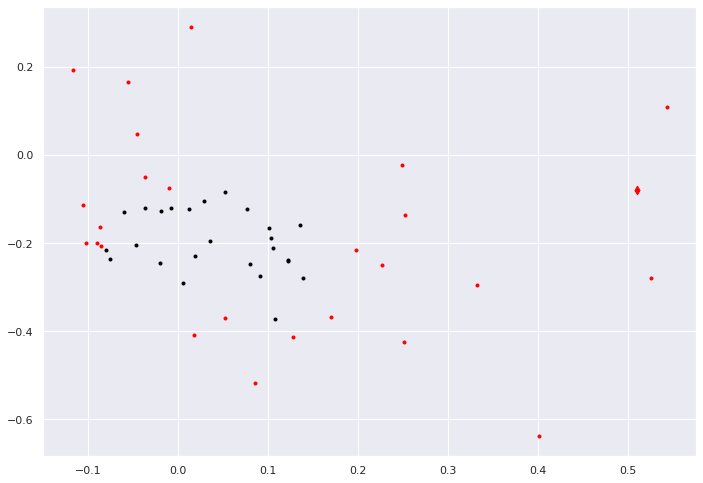

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


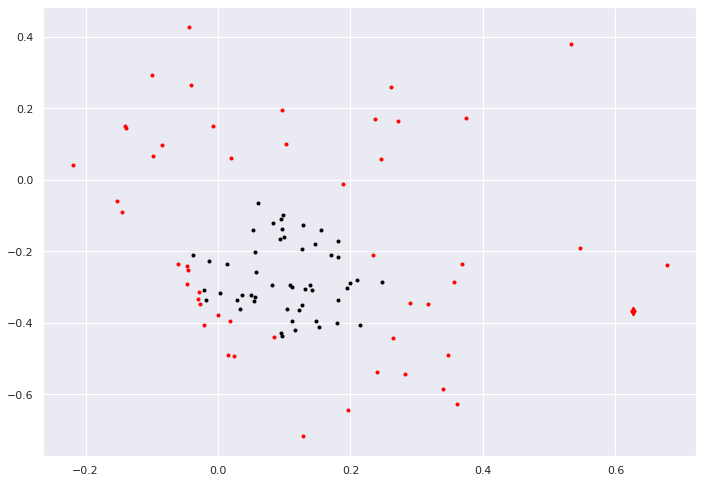

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.004599311186362356
fowlkes_mallows_score: 0.683537738771191
homogeneity_completeness_v_measure: 0.16377881383959197 0.0349156023676983 0.057560107117561383


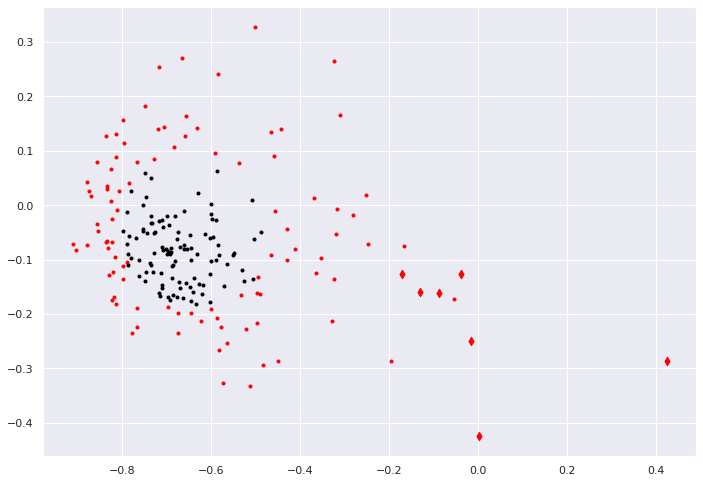

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.005206247496996396
fowlkes_mallows_score: 0.6806031838197856
homogeneity_completeness_v_measure: 0.1682513330031776 0.03957160000461275 0.064073529840858


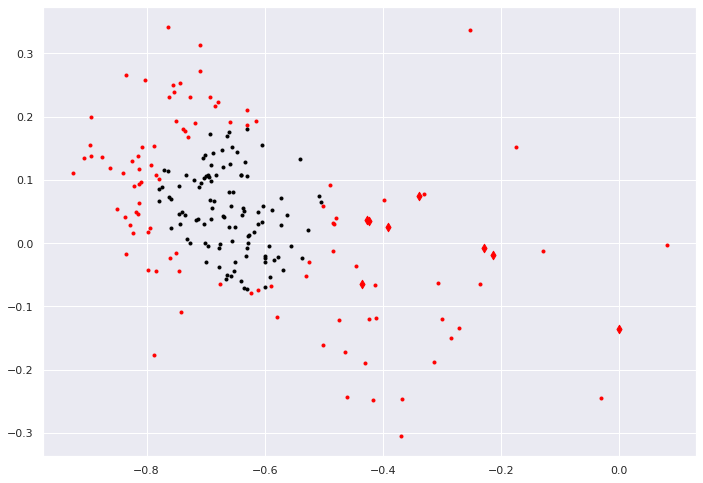

In [51]:
from sklearn.svm import OneClassSVM



# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, OneClassSVM, params=None)



# EllipticEnvelope

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

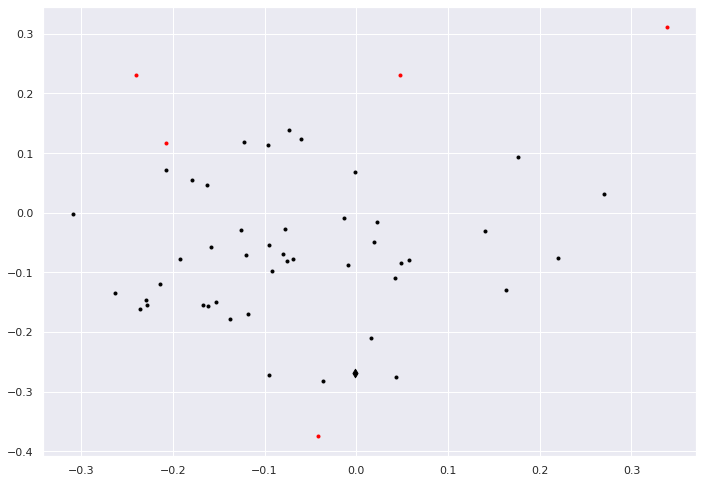

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


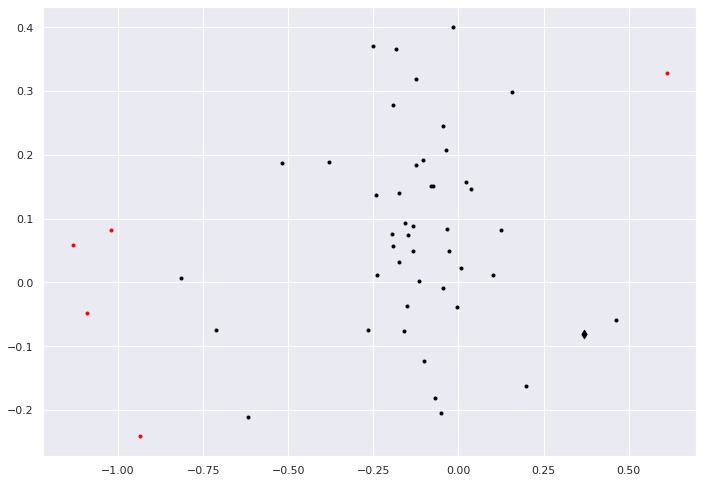

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


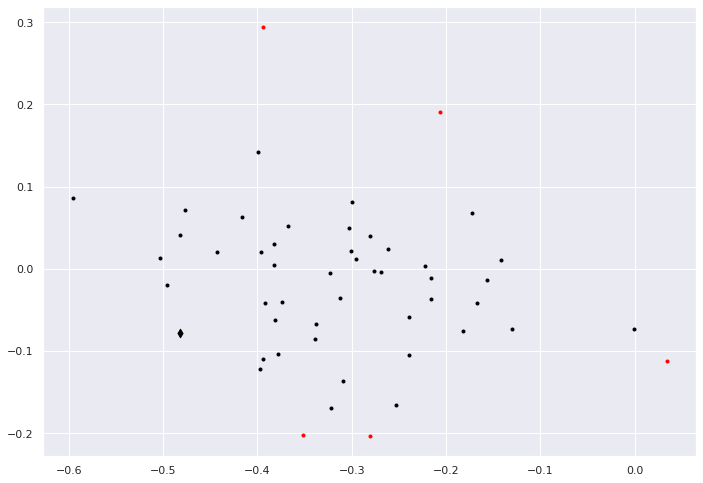

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.07976293369551797
fowlkes_mallows_score: 0.8152190738955344
homogeneity_completeness_v_measure: 0.034412660271568175 0.026049018028360408 0.02965236933619754


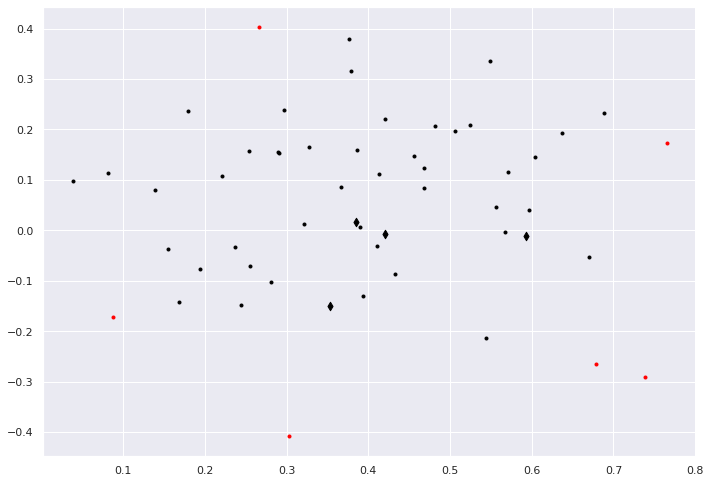

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


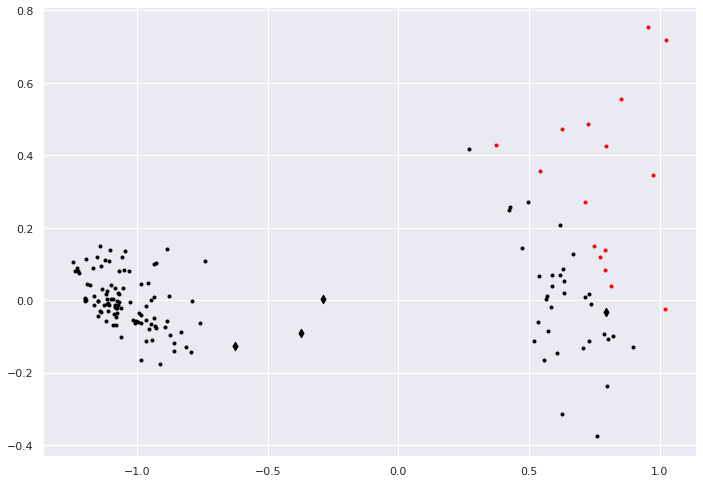

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


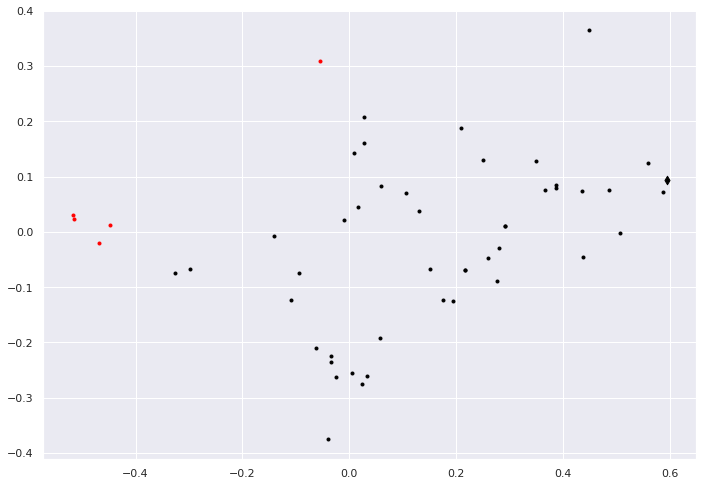

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.07093878307065
fowlkes_mallows_score: 0.801070215347033
homogeneity_completeness_v_measure: 0.018386741113376043 0.01886805870805866 0.018624290692199716


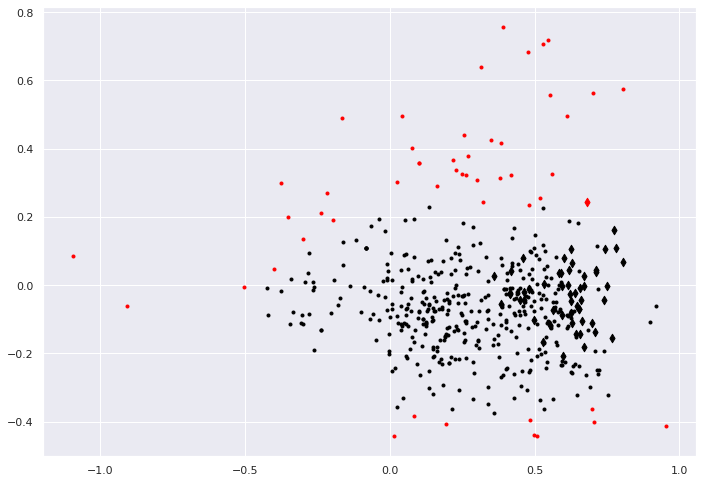

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


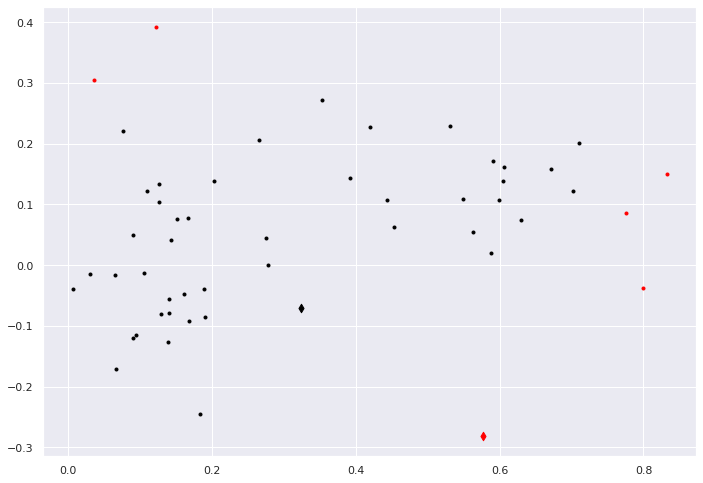

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.08726858216478783
fowlkes_mallows_score: 0.8838812942987014
homogeneity_completeness_v_measure: 0.04260093205262327 0.016512001215638228 0.02379941589594289


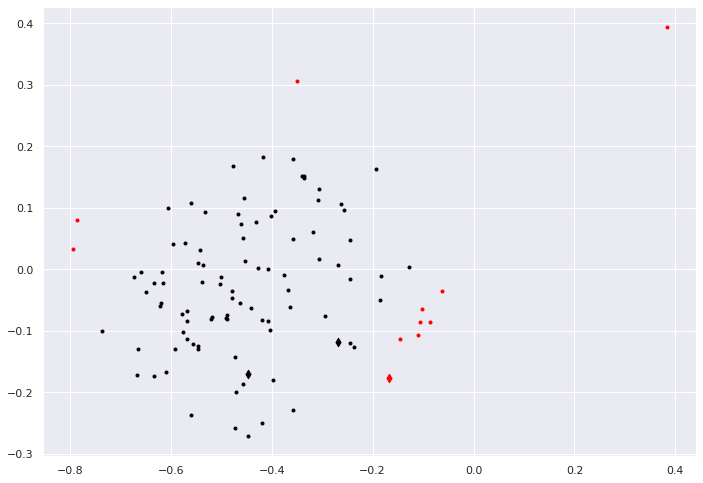

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


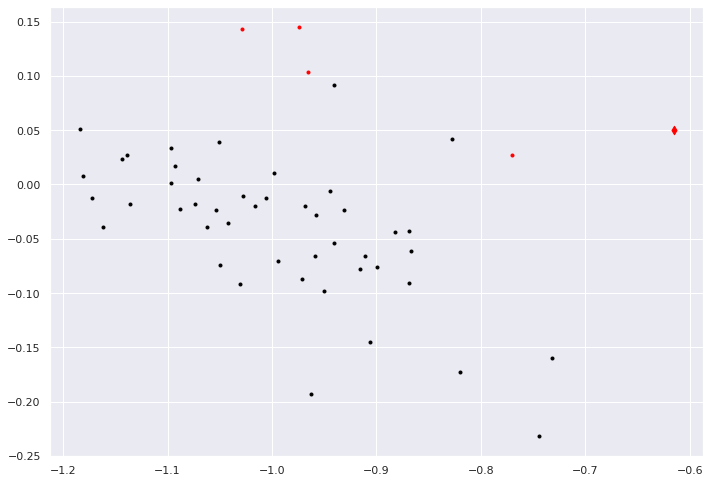

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


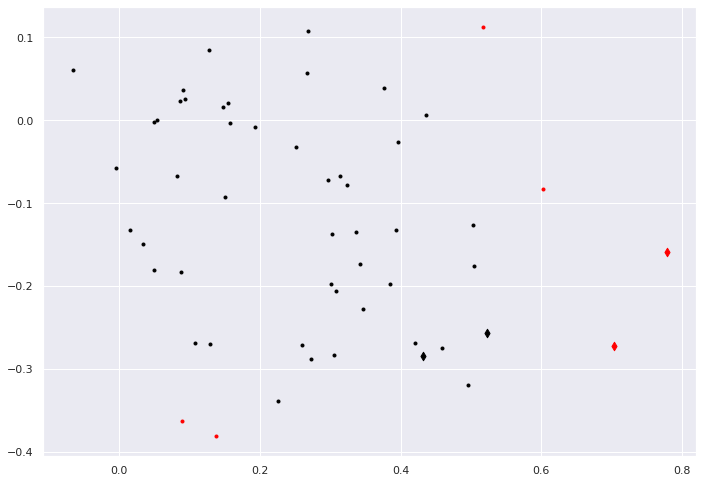

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.10884986754986345
fowlkes_mallows_score: 0.8934793337539082
homogeneity_completeness_v_measure: 0.10032311958540002 0.028311665665171255 0.0441609105135304


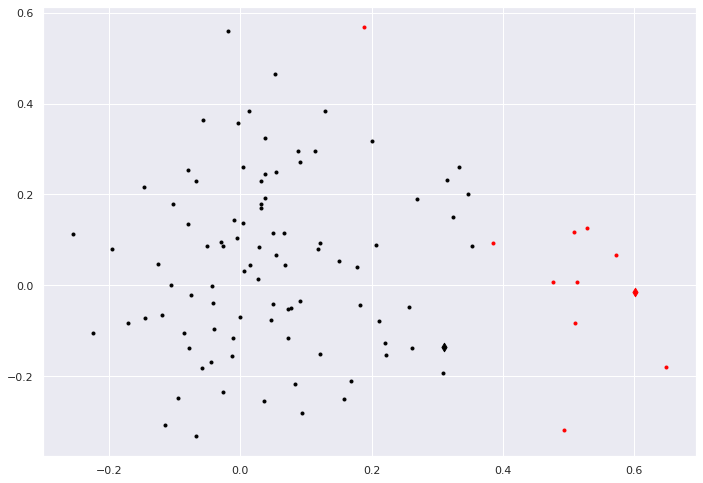

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.4382149990920646
fowlkes_mallows_score: 0.8970972715858277
homogeneity_completeness_v_measure: 0.25306732386104097 0.2237118633928022 0.23748588066886883


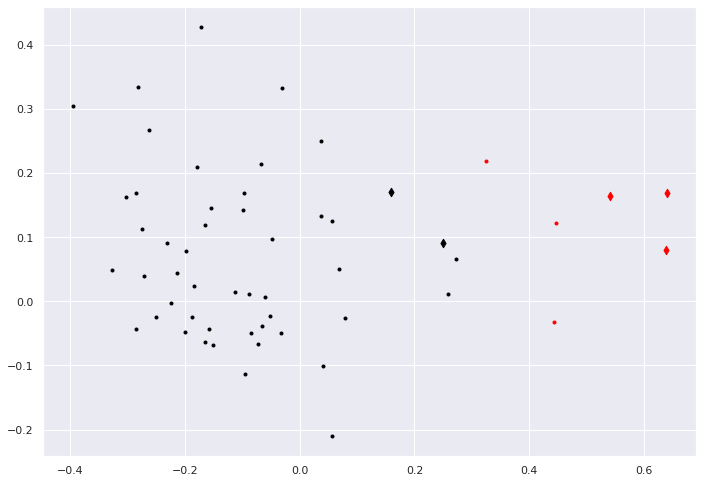

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


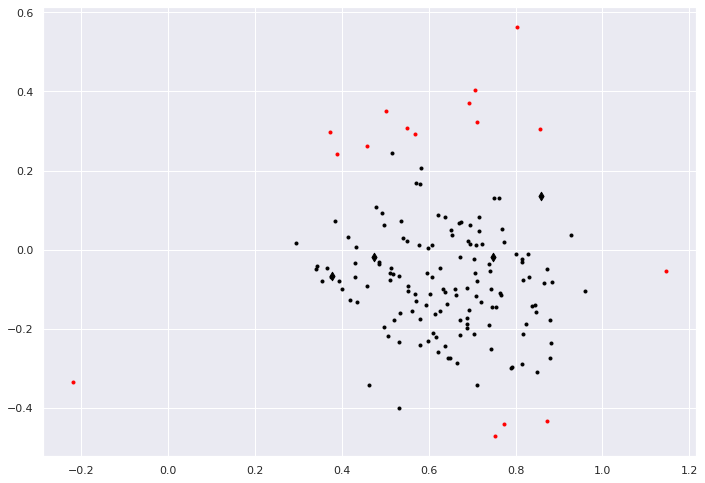

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


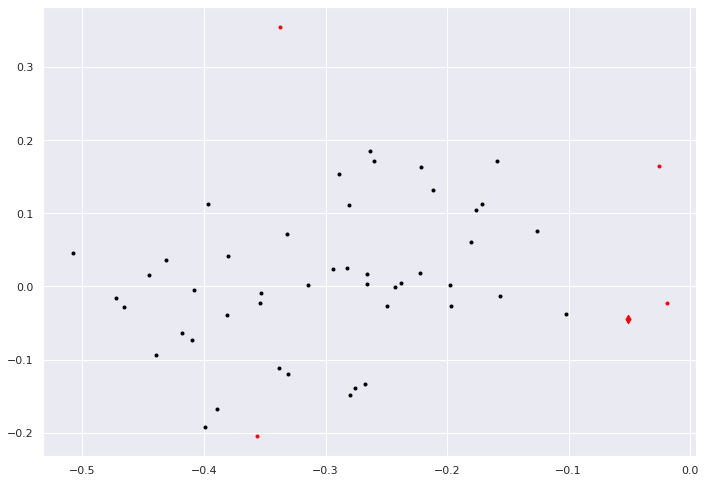

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


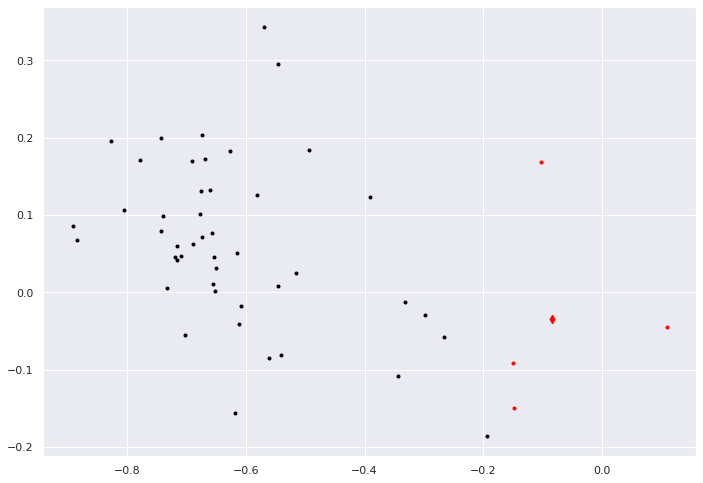

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


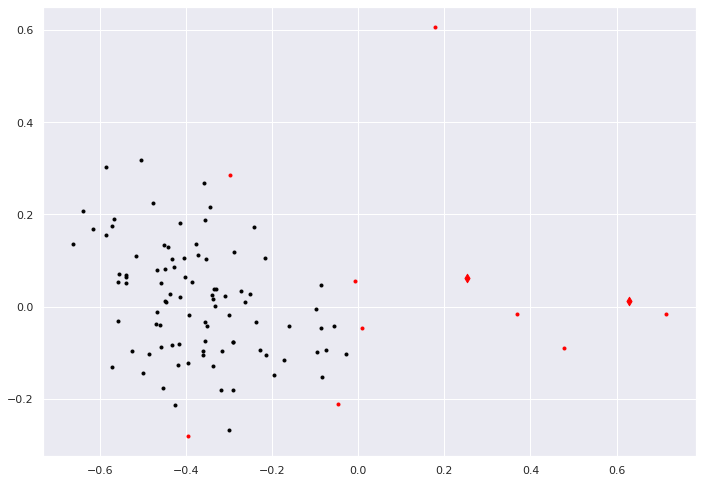

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


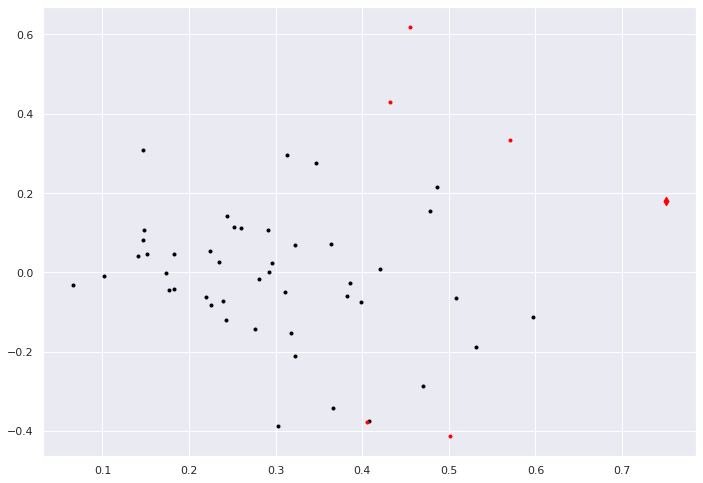

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.8786544398038859
fowlkes_mallows_score: 0.9779019890632276
homogeneity_completeness_v_measure: 0.8386529623245021 0.7413703755943142 0.7870168076007836


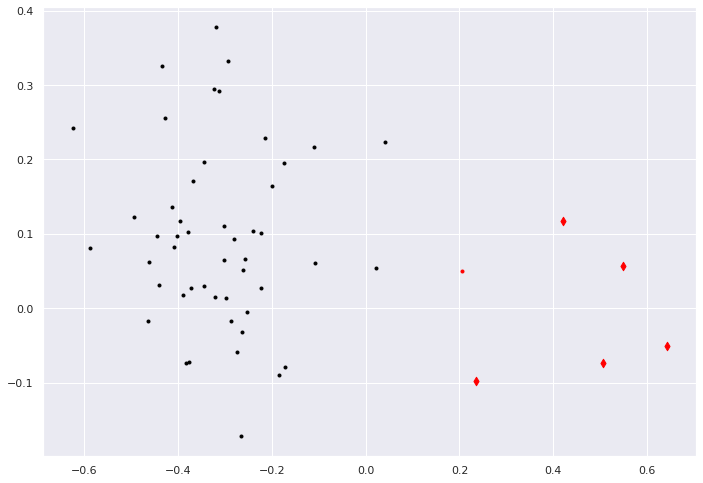

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.22965519058030187
fowlkes_mallows_score: 0.8919072513434483
homogeneity_completeness_v_measure: 0.11665142926393078 0.07370717345035277 0.09033526205162619


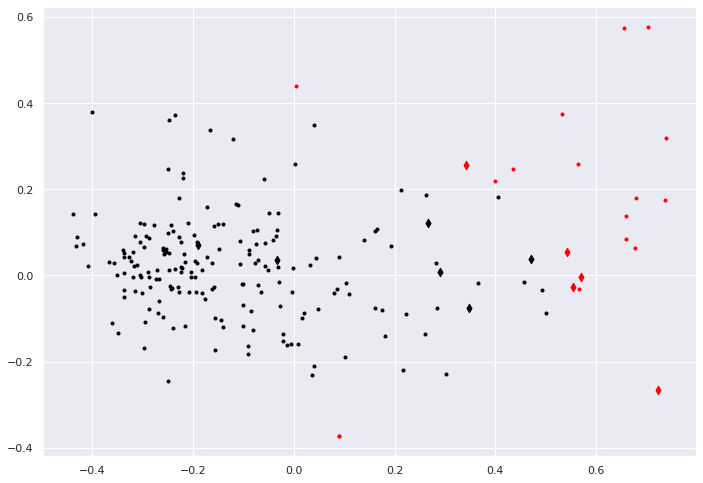

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


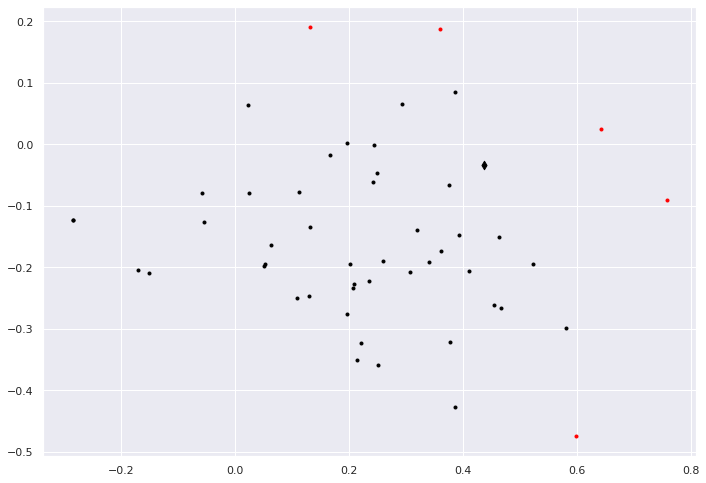

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


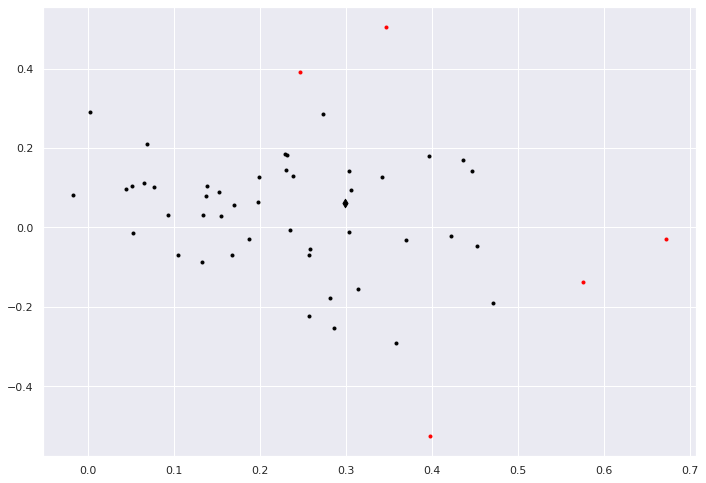

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


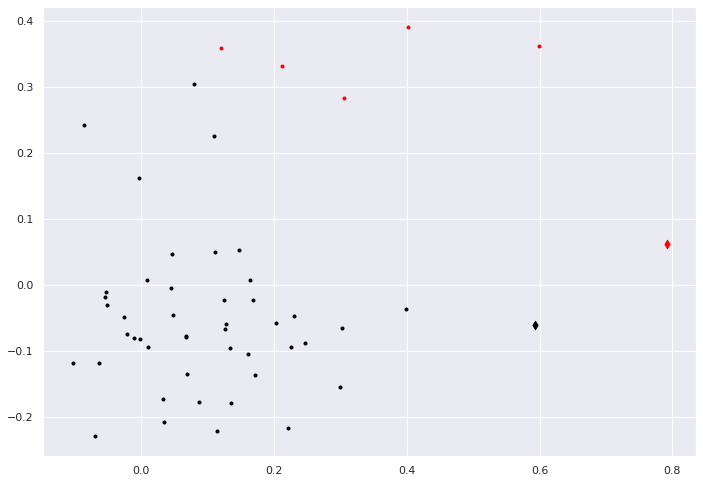

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


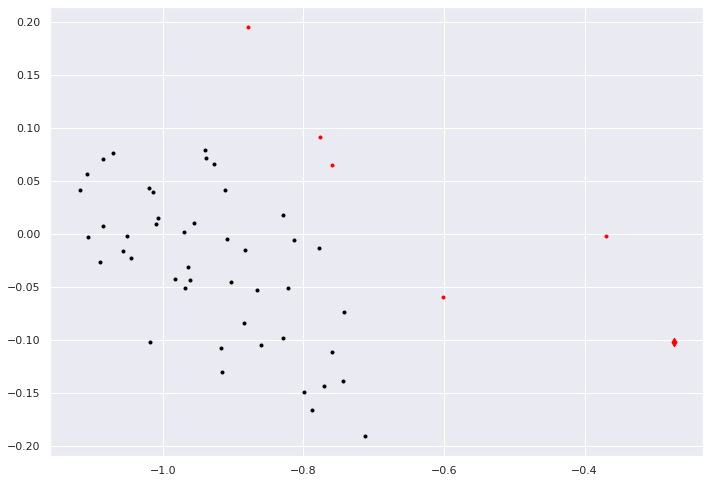

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.1739504446008219
fowlkes_mallows_score: 0.864681921296602
homogeneity_completeness_v_measure: 0.059562030222914765 0.04683585498894389 0.0524378582302237


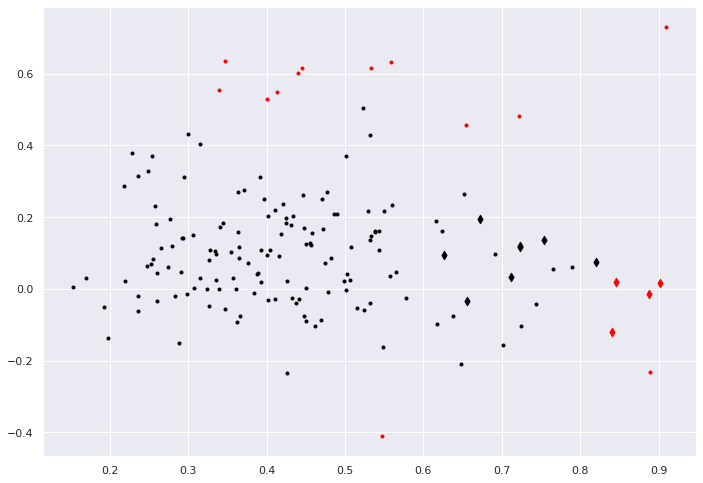

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.03122345973455338
fowlkes_mallows_score: 0.88533097251156
homogeneity_completeness_v_measure: 0.0069405316935464995 0.0026369457977027657 0.003821842630242101


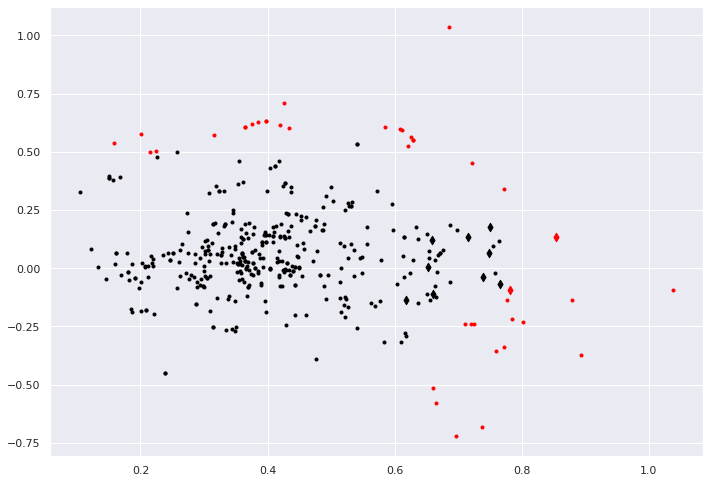

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


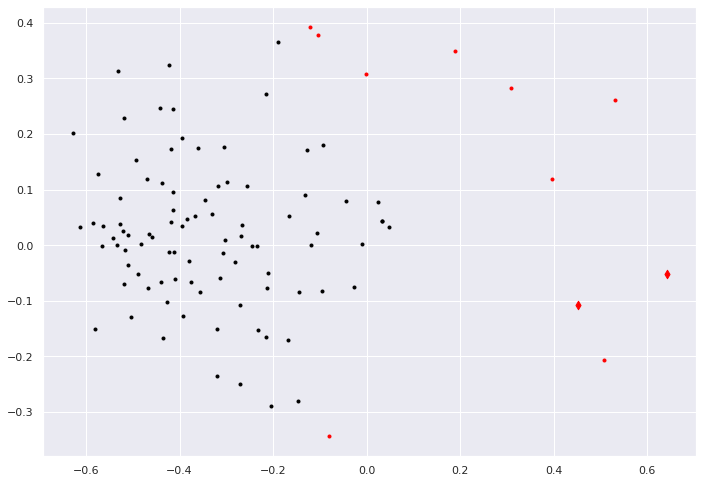

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.08304049420258265
fowlkes_mallows_score: 0.8112639652899177
homogeneity_completeness_v_measure: 0.03305265142814905 0.03097372536331339 0.03197943719974265


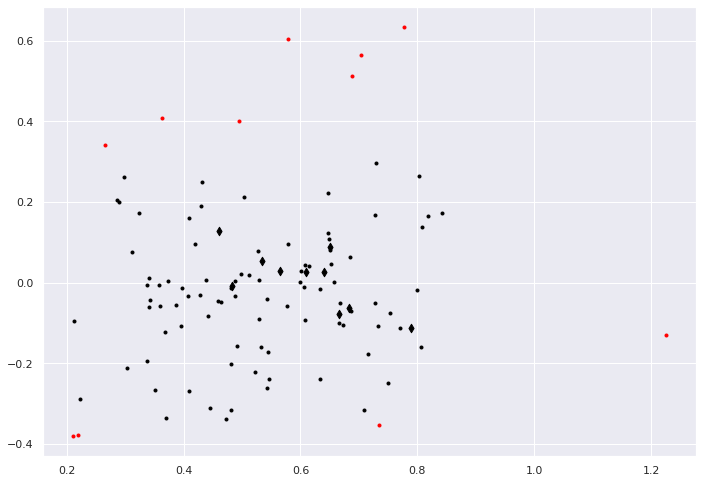

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.08761576175776285
fowlkes_mallows_score: 0.8006263333730135
homogeneity_completeness_v_measure: 0.03624737285782633 0.032042727608605194 0.03401560949765492


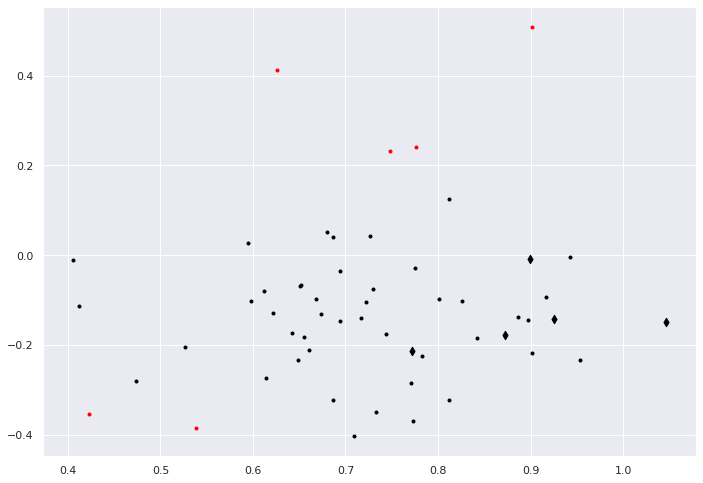

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


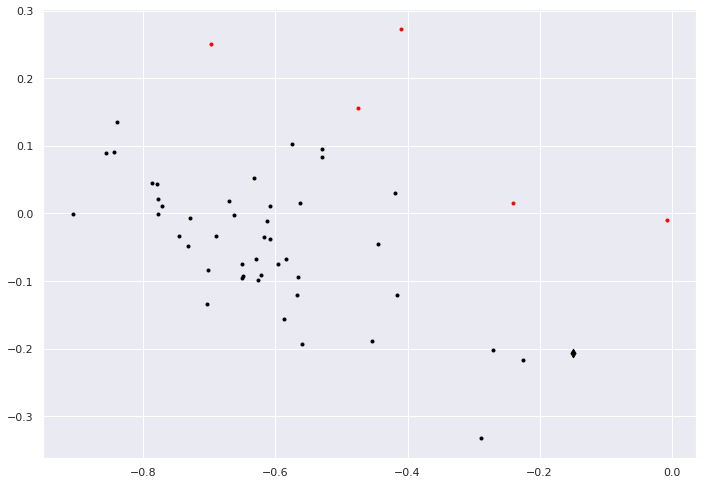

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.7447833065810594
fowlkes_mallows_score: 0.9568496885950687
homogeneity_completeness_v_measure: 0.7321596405397185 0.5542157893504782 0.6308802604336415


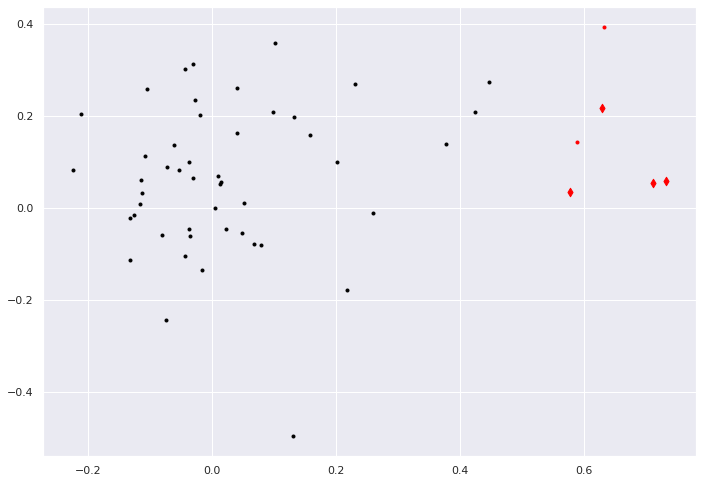

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


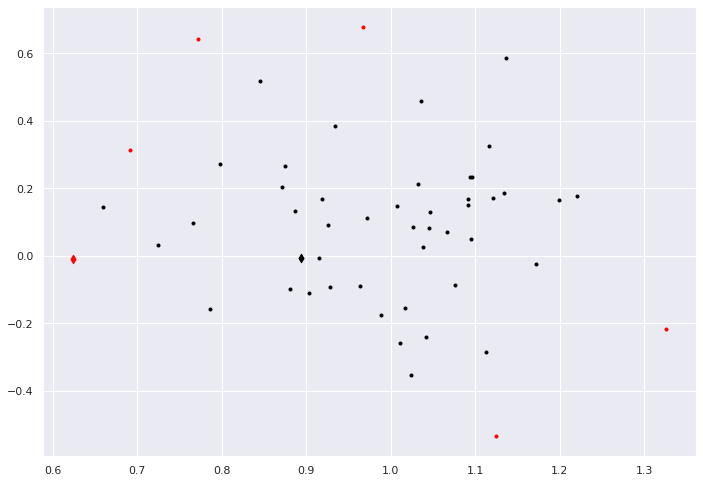

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.046867535972434954
fowlkes_mallows_score: 0.852968337137084
homogeneity_completeness_v_measure: 0.006057118901998522 0.004565110344215214 0.005206330143083896


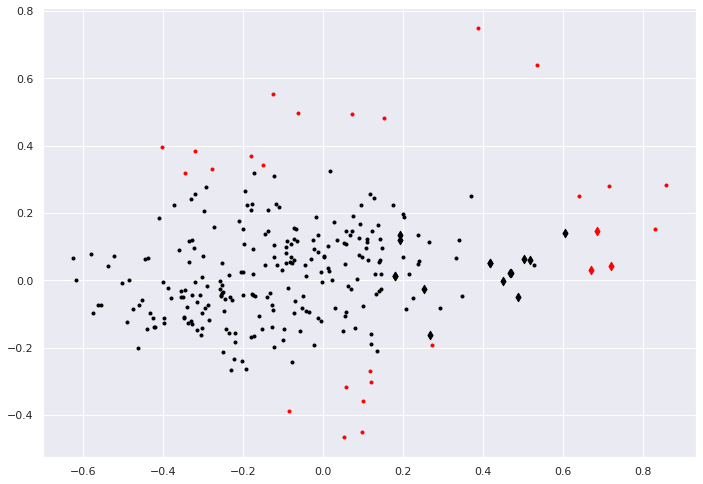

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.22267379250297864
fowlkes_mallows_score: 0.9015545564162515
homogeneity_completeness_v_measure: 0.20881124961107098 0.08093465192634508 0.11665439073273529


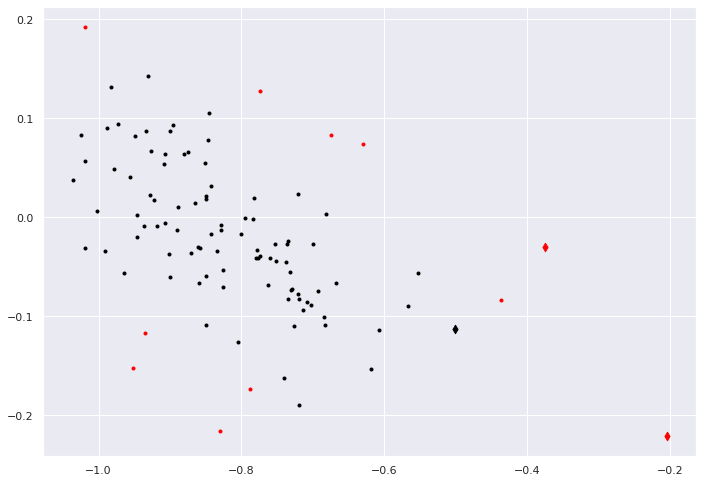

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


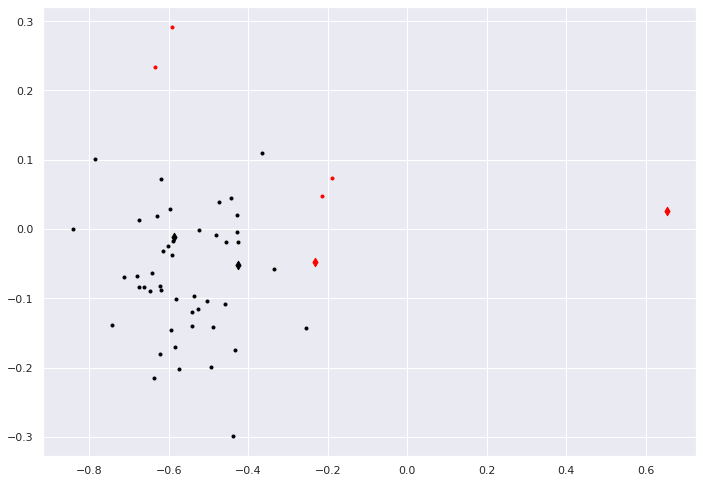

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.22267379250297864
fowlkes_mallows_score: 0.9015545564162515
homogeneity_completeness_v_measure: 0.20881124961107098 0.08093465192634508 0.11665439073273529


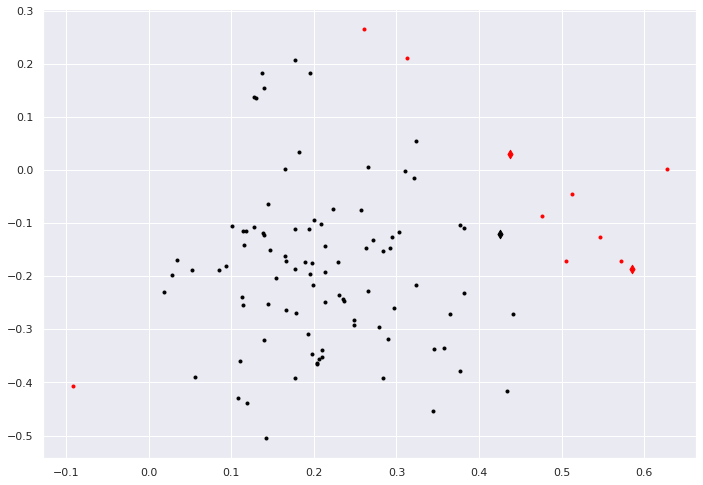

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


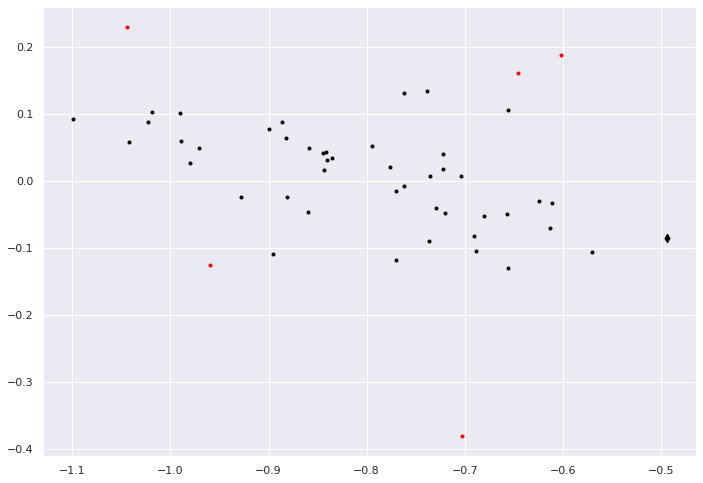

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.46543826217943707
fowlkes_mallows_score: 0.9289945419419103
homogeneity_completeness_v_measure: 0.5747254356694508 0.2775476627133153 0.3743253228915326


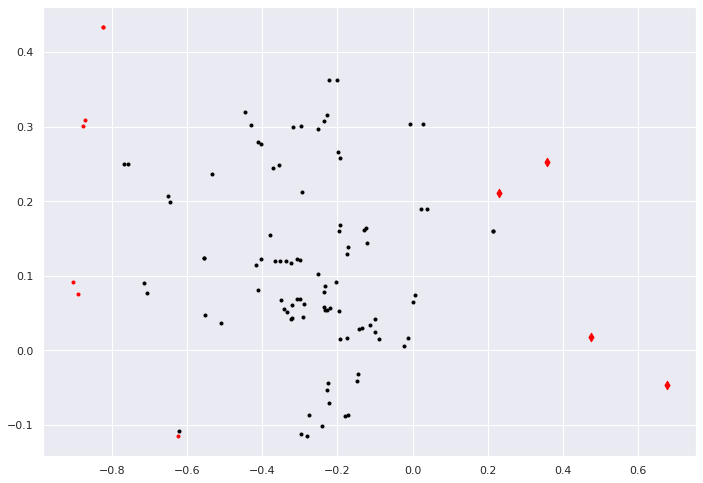

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


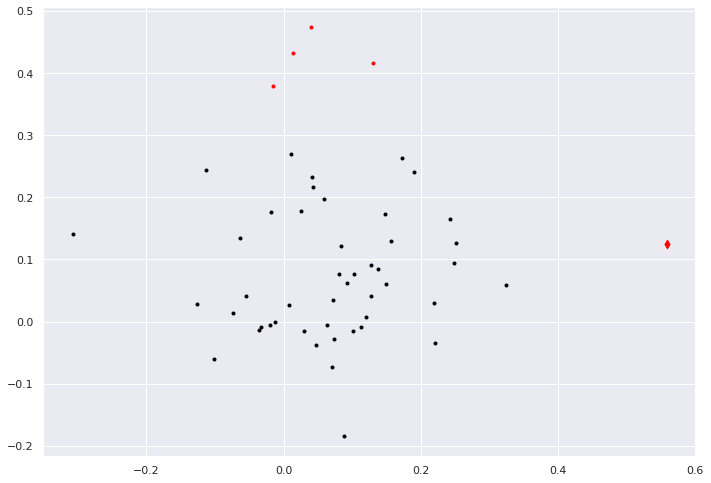

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.5952582358193524
fowlkes_mallows_score: 0.9369687007474506
homogeneity_completeness_v_measure: 0.6392515284712909 0.3937178184645023 0.48730336091078497


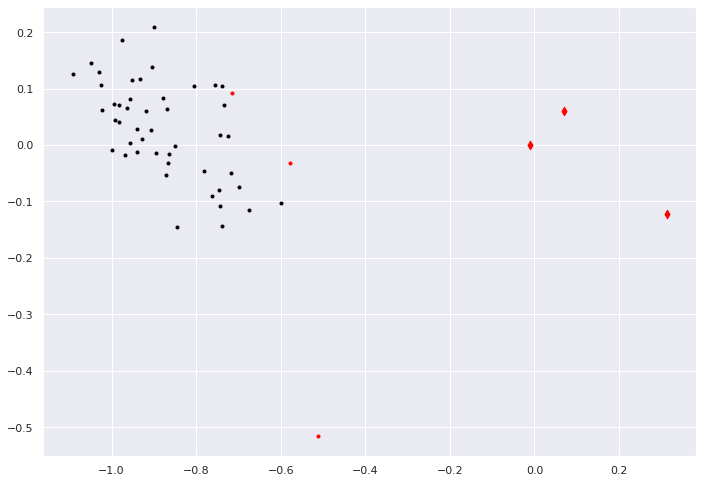

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.06795582871133764
fowlkes_mallows_score: 0.8401412990524931
homogeneity_completeness_v_measure: 0.029137437566274186 0.020954926639213358 0.02437788179257259


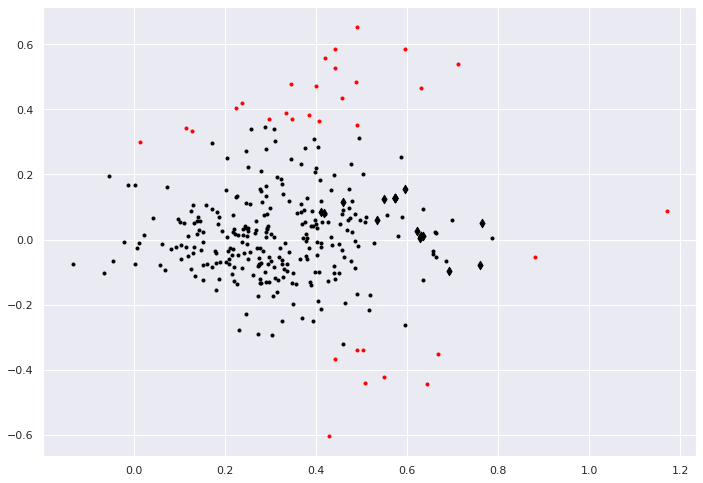

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.5436997918410137
fowlkes_mallows_score: 0.9386503207015755
homogeneity_completeness_v_measure: 0.6167940320942551 0.3414107948907943 0.43953053637556627


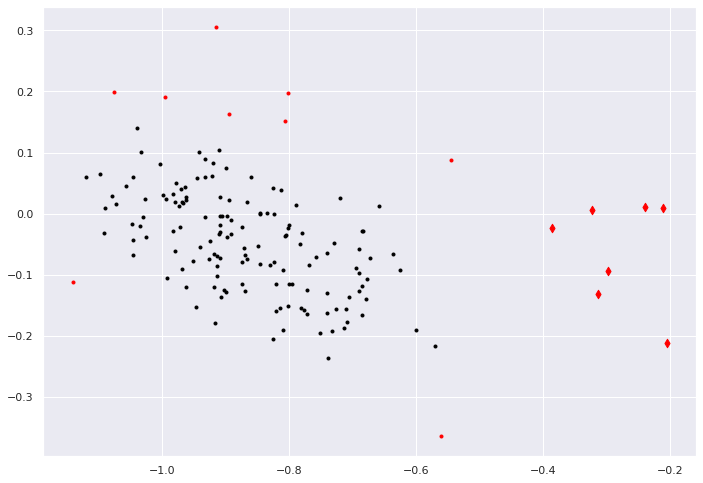

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


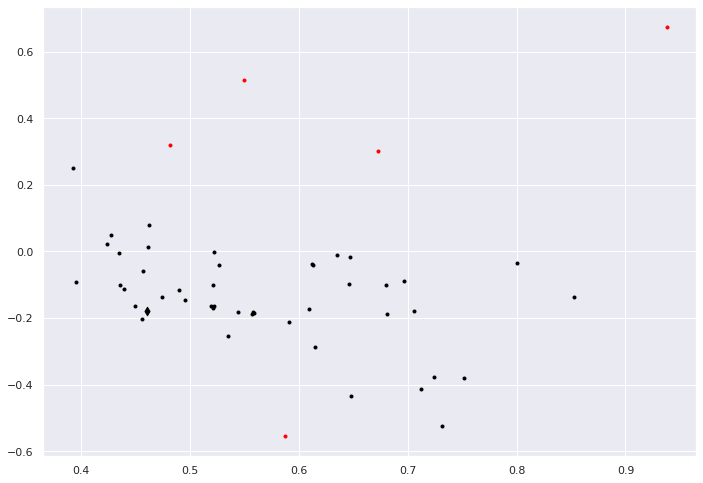

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


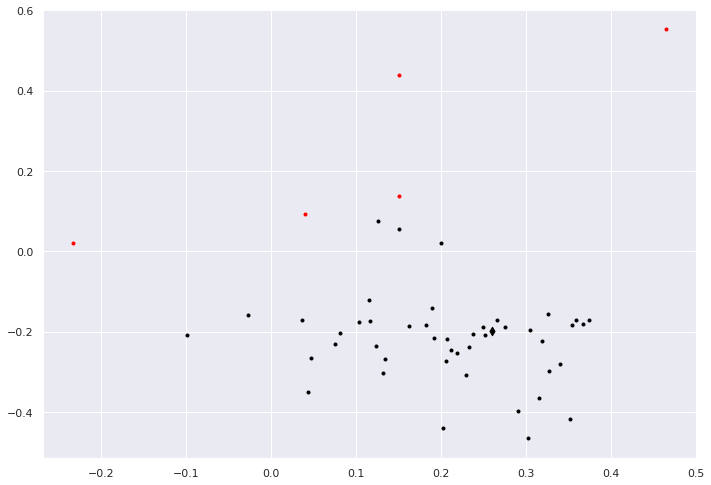

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


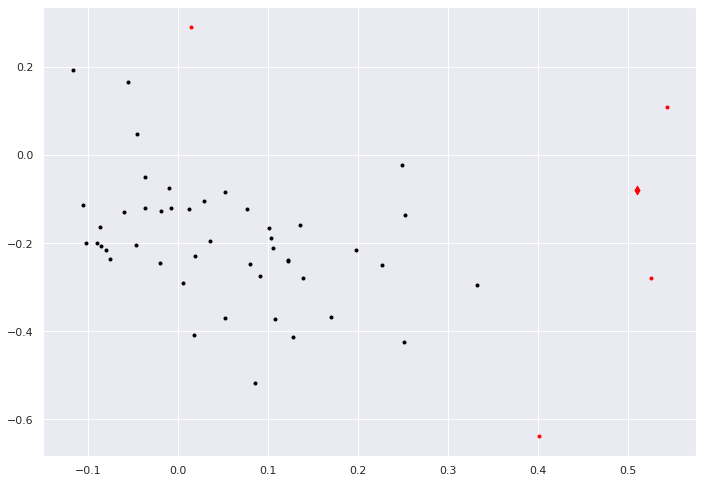

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


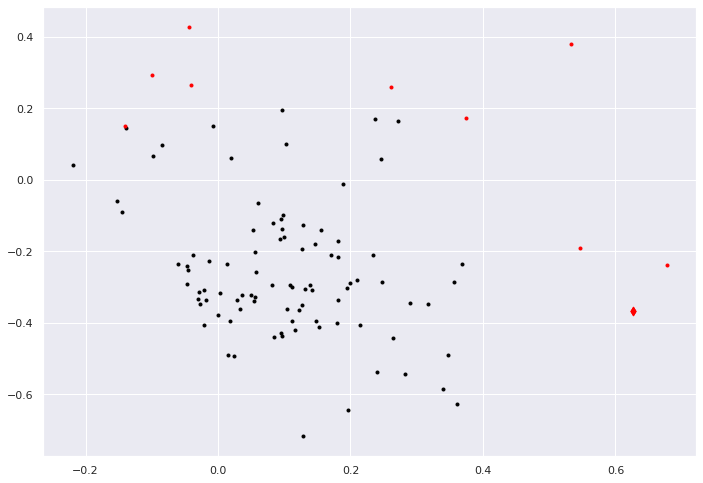

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.43626603012634224
fowlkes_mallows_score: 0.9297267996688643
homogeneity_completeness_v_measure: 0.5630044070805916 0.2534424952159976 0.34953710118009346


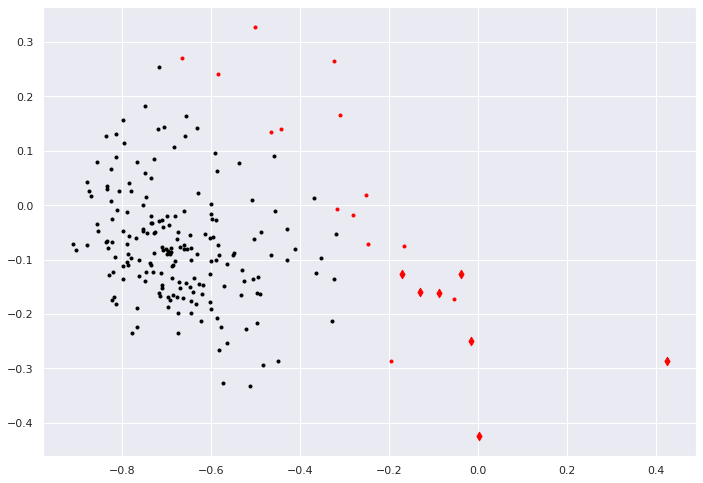

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.20558762631314134
fowlkes_mallows_score: 0.8970870823718041
homogeneity_completeness_v_measure: 0.12821348330016935 0.06388273219273119 0.08527630381624712


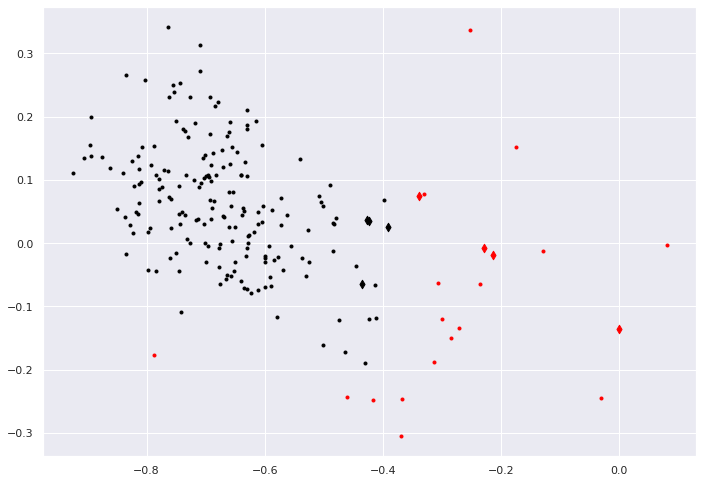

In [52]:
from sklearn.covariance import EllipticEnvelope


# add grid search to nu


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  values.append({'contamination':0.02})
clustering_function(familyes,df_data, df, EllipticEnvelope, params=None)




In [53]:
import pandas as pd

a = pd.DataFrame(all_res_table)
len(a.family_lable.unique())
a

algo   family_lable  \
0             <class 'sklearn.cluster._dbscan.DBSCAN'>      Aeropyrum   
1             <class 'sklearn.cluster._dbscan.DBSCAN'>     Agmenellum   
2             <class 'sklearn.cluster._dbscan.DBSCAN'>  Agrobacterium   
3             <class 'sklearn.cluster._dbscan.DBSCAN'>       Anabaena   
4             <class 'sklearn.cluster._dbscan.DBSCAN'>   Arthrobacter   
..                                                 ...            ...   
187  <class 'sklearn.covariance._elliptic_envelope....   Thermococcus   
188  <class 'sklearn.covariance._elliptic_envelope....   Thermoplasma   
189  <class 'sklearn.covariance._elliptic_envelope....     Thermotoga   
190  <class 'sklearn.covariance._elliptic_envelope....        Thermus   
191  <class 'sklearn.covariance._elliptic_envelope....    Xanthomonas   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
0   -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
1    0.073735  0.786200     0.283728      0.048237   0.082456  0.019608   
2   -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
3   -0.083557  0.782397     0.046891      0.029516   0.036228  0.000000   
4    0.072720  0.709096     0.334480      0.046798   0.082108  0.019481   
..        ...       ...          ...           ...        ...       ...   
187 -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
188  0.282335  0.920078     0.491663      0.147933   0.227434  0.019608   
189  0.254852  0.911570     0.470177      0.132686   0.206966  0.019608   
190  0.436266  0.929727     0.563004      0.253442   0.349537  0.033816   
191  0.205588  0.897087     0.128213      0.063883   0.085276  0.019231   

           fp        fn        tn  family_size  re_size  
0    0.019608  0.098039  0.882353           51        1  
1    0.000000  0.235294  0.745098           51        1  
2    0.019608  0.098039  0.882353           51        1  
3    0.074074  0.148148  0.777778           54        4  
4    0.006494  0.084416  0.889610          154        4  
..        ...       ...       ...          ...      ...  
187  0.019608  0.098039  0.882353           51        1  
188  0.000000  0.078431  0.901961           51        1  
189  0.000000  0.088235  0.892157          102        2  
190  0.000000  0.067633  0.898551          207        7  
191  0.019231  0.081731  0.879808          208        8  

[192 rows x 13 columns]

# to csv

In [54]:
a.sort_values(by =['fmi'] , ascending = False).to_csv('res_of_iadf_pca.csv')

In [55]:
a.sort_values(by =['tp'], ascending = False)

algo  family_lable  \
114         <class 'sklearn.svm._classes.OneClassSVM'>  Enterobacter   
108         <class 'sklearn.svm._classes.OneClassSVM'>   Citrobacter   
162  <class 'sklearn.covariance._elliptic_envelope....  Enterobacter   
18            <class 'sklearn.cluster._dbscan.DBSCAN'>  Enterobacter   
66   <class 'sklearn.ensemble._iforest.IsolationFor...  Enterobacter   
..                                                 ...           ...   
48   <class 'sklearn.ensemble._iforest.IsolationFor...     Aeropyrum   
43            <class 'sklearn.cluster._dbscan.DBSCAN'>  Thermococcus   
90   <class 'sklearn.ensemble._iforest.IsolationFor...    Sulfolobus   
164  <class 'sklearn.covariance._elliptic_envelope....   Eubacterium   
0             <class 'sklearn.cluster._dbscan.DBSCAN'>     Aeropyrum   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
114  0.020566  0.647100     0.215865      0.094895   0.131835  0.090909   
108  0.020566  0.647100     0.215865      0.094895   0.131835  0.090909   
162  0.878654  0.977902     0.838653      0.741370   0.787017  0.090909   
18   0.775836  0.956159     0.750051      0.599452   0.666349  0.090909   
66   0.385783  0.834821     0.483042      0.269089   0.345635  0.090909   
..        ...       ...          ...           ...        ...       ...   
48  -0.028414  0.801453     0.044836      0.008743   0.014633  0.000000   
43  -0.028976  0.920937     0.012443      0.005368   0.007500  0.000000   
90  -0.025225  0.760640     0.060473      0.010281   0.017575  0.000000   
164 -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
0   -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   

           fp        fn        tn  family_size  re_size  
114  0.000000  0.418182  0.490909           55        5  
108  0.000000  0.418182  0.490909           55        5  
162  0.000000  0.018182  0.890909           55        5  
18   0.000000  0.036364  0.872727           55        5  
66   0.000000  0.145455  0.763636           55        5  
..        ...       ...       ...          ...      ...  
48   0.019608  0.196078  0.784314           51        1  
43   0.019608  0.058824  0.921569           51        1  
90   0.019608  0.254902  0.725490           51        1  
164  0.019608  0.098039  0.882353           51        1  
0    0.019608  0.098039  0.882353           51        1  

[192 rows x 13 columns]

In [56]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['family_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ family_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.0923002834929104
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.633
Date:                Sun, 05 Mar 2023   Prob (F-statistic):              0.203
Time:                        17:24:21   Log-Likelihood:                 176.25
No. Observations:                 192   AIC:                            -348.5
Df Residuals:                     190   BIC:                            -342.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Inter

In [57]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['re_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ re_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.13263933498329505
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.403
Date:                Sun, 05 Mar 2023   Prob (F-statistic):             0.0667
Time:                        17:24:21   Log-Likelihood:                 177.14
No. Observations:                 192   AIC:                            -350.3
Df Residuals:                     190   BIC:                            -343.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc